# Bank Marketing Classification Task.

## Introduction

*Information*

The data is related to direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required to assess if the product (bank term deposit) would be subscribed ('yes') or not ('no').

*Classification Goal*

The goal is to predict if the client will subscribe (yes/no) to a term deposit (variable y).

## Preparation

### Imports

In [3]:
import os
import pathlib
from functools import partial
from itertools import product
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import squarify 

from scipy.stats import chi2_contingency
from scipy import stats


from statsmodels.stats.outliers_influence import variance_inflation_factor


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.svm import SVC

from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, confusion_matrix, precision_score


from aws.aws_funcs import upload_to_s3

### Useful Functions

#### AWS

In [4]:
path_to_local_plots = 'path/to/file'
def upload_to_aws_png(file_name):
    upload_to_s3(f'{path_to_local_plots}{file_name}.png', f'path/png/{file_name}.png')

def upload_plot(plot_name):
    plt.savefig(f'{path_to_local_plots}{plot_name}.png', dpi=300)
    upload_to_aws_png(plot_name)

In [5]:
path_to_local_csv = 'path/to/file'
def upload_to_aws_csv(file_name):
    upload_to_s3(f'{path_to_local_csv}{file_name}.csv', f'path/csv/{file_name}.csv')

def upload_csv(df, csv_name, index=False):
    df.to_csv(f'{path_to_local_csv}{csv_name}.csv', index=index)
    upload_to_aws_csv(csv_name)

#### Visualization

In [6]:
def count_categorical(df, column, target=0):
    '''
    Visualizes the distribution of a categorical variable and its relationship with a binary target variable in a DataFrame.

    This function creates a two-part visualization: a treemap and a bar chart. The treemap shows the frequency of each category
    in the specified column, providing a visual representation of the size of each category. The bar chart displays the count
    of observations for each category, split by the values of a binary target variable ('y'), allowing for an examination of
    the relationship between the categorical variable and the target.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data to be visualized.
    - column (str): The name of the categorical column to visualize.
    - target (int, optional): The binary target variable to compare against. Defaults to 0, assuming 'y' is the target column.

    The function does not return any value but displays two plots:
    1. A treemap visualization of the categorical variable's frequency.
    2. A bar chart showing the count of observations for each category, colored by the binary target variable's value.
    '''
    fig, ax = plt.subplots(2, 1, figsize=(17,14), dpi=300)
    category_sizes = df[column].value_counts().reset_index()
    category_sizes.columns = [column, 'counts']

    colors = plt.cm.tab20c.colors
    squarify.plot(sizes=category_sizes['counts'], label=category_sizes[column], alpha=0.6, color=colors, ax=ax[0])
    ax[0].axis('off')
    ax[0].set_title(f'Treemap of {column.capitalize()}s', pad=20)
    ax[0].set_xlabel('Category', labelpad=20)
    ax[0].set_ylabel('Frequency', labelpad=20);
    ax[0].tick_params(axis='x', rotation=45);

    temp_df = df.groupby([column, 'y']).size().unstack(fill_value=0)
    colormap = plt.cm.coolwarm
    colors = [colormap(i) for i in np.linspace(0.1, 0.85, temp_df.shape[1])]
    temp_df.plot(kind='bar', stacked=False, ax=ax[1], color=colors)
    ax[1].tick_params(axis='x', rotation=45)

In [7]:
def summary_numerical(df, col, q_min, q_max, upload=1, engineered=0):
    """
    Generates and visualizes statistical summaries for a numerical column in a DataFrame.

    This function creates a 2x2 grid of plots for a specified numerical column: histogram with KDE, Q-Q plot, boxplot,
    and a quantile line plot for detecting outliers. It allows for an extensive examination of the distribution,
    normality, and potential outliers within the data.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - col (str): The numerical column to analyze.
    - q_min (float): The minimum quantile to start the range for the outlier plot.
    - q_max (float): The maximum quantile to end the range for the outlier plot.
    - upload (int, optional): Flag to upload the plot. Defaults to 1 (true).
    - engineered (int, optional): Flag indicating if the column is engineered. Defaults to 0 (false).

    No return value; the function plots and optionally uploads the visualizations.
    """
    
    fig, ax = plt.subplots(2, 2, figsize=(15, 8))

    sns.histplot(data=df, x=col, kde=True, ax=ax[0, 0])

    stats.probplot(x=df[col], dist=stats.norm, plot=ax[0, 1])

    sns.boxplot(data=df, x=col, ax=ax[1, 0])

    pts = df[col].quantile(q=np.arange(q_min, q_max, 0.01))
    sns.lineplot(x=pts.index, y=pts, ax=ax[1, 1])

    titles_name = [["Histogram", "QQ plot"], ["Boxplot", "Outlier"]]

    for i, j in product(range(2), repeat=2):
        ax[i, j].set_title(titles_name[i][j].capitalize(), pad=20)

    plt.suptitle(f"Distribution of: {col.capitalize()}", fontsize=15)
    plt.tight_layout()
    if upload:
        if engineered:
            upload_plot(f'distribution_{col}_engineered')
        else:
            upload_plot(f'distribution_{col}')

#### Statistical

In [8]:
def cat_to_target(df, cat, target='y'):
    """
    Calculates the Chi-squared test statistic and p-value for the relationship between a categorical variable and a target variable.

    This function applies a Chi-squared test of independence to examine if there is a significant relationship between the categorical
    variable and the target variable in the provided DataFrame.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - cat (str): Column name of the categorical variable.
    - target (str, optional): Column name of the target variable. Defaults to 'y'.

    Returns:
    - chi2 (float): The Chi-squared test statistic.
    - p_value (float): The p-value of the test.
    - dof (int): Degrees of freedom of the Chi-squared test.
    - expected (numpy.ndarray): The expected frequencies, based on the marginal sums of the table.
    """
    
    temp = pd.crosstab(df[cat], df[target])
    chi2, p_value, dof, expected = chi2_contingency(temp)
    return chi2, p_value, dof, expected

#### Modeling

In [9]:
def train_models(features, labels, models, n_folds=5):
    """
    Trains multiple models and evaluates their performance using cross-validation.

    This function iterates over a dictionary of models, trains each model using stratified k-fold cross-validation, and 
    calculates the average accuracy, recall, f1 score, and precision for each model. The performance metrics are then 
    aggregated into a DataFrame for comparison.

    Parameters:
    - features (pandas.DataFrame): The feature variables.
    - labels (pandas.Series): The target variable.
    - models (dict): A dictionary of model name and model instance pairs.

    Returns:
    - results_df (pandas.DataFrame): A DataFrame containing the average accuracy, recall, f1 score, and precision for each model.
    - models (dict): The same dictionary of models that was passed in, after they have been fit to the data.
    """

    results = {
        'accuracy': [],
        'recall': [],
        'f1 score': [],
        'precision': []
    }

    s_fold = StratifiedKFold(
    n_splits=n_folds,
    shuffle=True,
    random_state=42
    )

    for name, model in models.items():
        fold_accuracy, fold_recall, fold_f1_score, fold_precision = [], [], [], []

        for train_idx, val_idx in s_fold.split(features, labels):
            X_train, X_val = features.iloc[train_idx], features.iloc[val_idx]
            y_train, y_val = labels.iloc[train_idx], labels.iloc[val_idx]

            model.fit(X_train, y_train)
            preds = model.predict(X_val)
            fold_accuracy.append(accuracy_score(y_val, preds))
            fold_recall.append(recall_score(y_val, preds))
            fold_f1_score.append(f1_score(y_val, preds))
            fold_precision.append(precision_score(y_val, preds))

        avg_accuracy = np.mean(fold_accuracy)
        avg_recall = np.mean(fold_recall)
        avg_f1_score = np.mean(fold_f1_score)
        avg_precision = np.mean(fold_precision)
        
        results['accuracy'].append(avg_accuracy)
        results['recall'].append(avg_recall)
        results['f1 score'].append(avg_f1_score)
        results['precision'].append(avg_precision)

    results_df = pd.DataFrame(results)
    results_df.index = models.keys()
    return results_df, models


def test_models(features, labels, models):
    """
    Tests the performance of multiple trained models on a dataset.

    Evaluates each model's accuracy, recall, f1 score, and precision on the provided features and labels. The function iterates 
    through a dictionary of trained model instances, uses them to predict labels for the given features, and calculates the 
    performance metrics for each model. These metrics are compiled into a DataFrame for easy comparison.

    Parameters:
    - features (pandas.DataFrame): The feature variables for testing.
    - labels (pandas.Series): The true labels for performance evaluation.
    - models (dict): A dictionary where keys are model names and values are trained model instances.

    Returns:
    - results_df (pandas.DataFrame): A DataFrame with each model's accuracy, recall, f1 score, and precision.
    """

    results = {
        'accuracy': [],
        'recall': [],
        'f1 score': [],
        'precision': []
    }

    for name, model in models.items():
        preds = model.predict(features)
        results['accuracy'].append(accuracy_score(labels, preds))
        results['recall'].append(recall_score(labels, preds))
        results['f1 score'].append(f1_score(labels, preds))
        results['precision'].append(precision_score(labels, preds))

    results_df = pd.DataFrame(results)
    results_df.index = models.keys()
    return results_df 


def confusion_matrix_plot(features, labels, models, upload=0):
    """
    Plots confusion matrices for given models on a dataset and optionally uploads the plots.

    This function iterates over a dictionary of models, predicts labels for a given set of features using each model, and then 
    plots the confusion matrix for the predicted versus actual labels. It can also upload the generated plots if required.

    Parameters:
    - features (pandas.DataFrame): The feature variables for the dataset.
    - labels (pandas.Series): The true labels for the dataset.
    - models (dict): A dictionary of model name and model instance pairs.
    - upload (int, optional): Flag to determine whether to upload the plots. If 1, plots are uploaded. Defaults to 0.
    """

    for name, model in models.items():
        preds = model.predict(features)
        confusion_matrix_model = confusion_matrix(labels, preds)
        fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
        sns.heatmap(confusion_matrix_model, annot=True, fmt='d', cmap='coolwarm_r', ax=ax, alpha=0.5)
        ax.set_xlabel('Predictions', labelpad=20)
        ax.set_ylabel('True', labelpad=20)
        ax.set_title(name, pad=20)
        if upload:
            upload_plot(f'{upload}_{name}')

### Get the Data and the First Impression

In [10]:
path_data = pathlib.Path('data/bank_data.csv')
df = pd.read_csv(path_data.__str__())
df.head(20)

Unnamed: 0  age            job  marital  education default  balance  \
0            0   30     unemployed  married    primary      no     1787   
1            1   33       services  married  secondary      no     4789   
2            2   35     management   single   tertiary      no     1350   
3            3   30     management  married   tertiary      no     1476   
4            4   59    blue-collar  married  secondary      no        0   
5            5   35     management   single   tertiary      no      747   
6            6   36  self-employed  married   tertiary      no      307   
7            7   39     technician  married  secondary      no      147   
8            8   41   entrepreneur  married   tertiary      no      221   
9            9   43       services  married    primary      no      -88   
10          10   39       services  married  secondary      no     9374   
11          11   43         admin.  married  secondary      no      264   
12          12   36     technician  married   tertiary      no     1109   
13          13   20        student   single  secondary      no      502   
14          14   31    blue-collar  married  secondary      no      360   
15          15   40     management  married   tertiary      no      194   
16          16   56     technician  married  secondary      no     4073   
17          17   37         admin.   single   tertiary      no     2317   
18          18   25    blue-collar   single    primary      no     -221   
19          19   31       services  married  secondary      no      132   

   housing loan   contact  day month  duration  campaign  pdays  previous  \
0       no   no  cellular   19   oct        79         1     -1         0   
1      yes  yes  cellular   11   may       220         1    339         4   
2      yes   no  cellular   16   apr       185         1    330         1   
3      yes  yes   unknown    3   jun       199         4     -1         0   
4      yes   no   unknown    5   may       226         1     -1         0   
5       no   no  cellular   23   feb       141         2    176         3   
6      yes   no  cellular   14   may       341         1    330         2   
7      yes   no  cellular    6   may       151         2     -1         0   
8      yes   no   unknown   14   may        57         2     -1         0   
9      yes  yes  cellular   17   apr       313         1    147         2   
10     yes   no   unknown   20   may       273         1     -1         0   
11     yes   no  cellular   17   apr       113         2     -1         0   
12      no   no  cellular   13   aug       328         2     -1         0   
13      no   no  cellular   30   apr       261         1     -1         0   
14     yes  yes  cellular   29   jan        89         1    241         1   
15      no  yes  cellular   29   aug       189         2     -1         0   
16      no   no  cellular   27   aug       239         5     -1         0   
17     yes   no  cellular   20   apr       114         1    152         2   
18     yes   no   unknown   23   may       250         1     -1         0   
19      no   no  cellular    7   jul       148         1    152         1   

   poutcome    y  
0   unknown   no  
1   failure   no  
2   failure   no  
3   unknown   no  
4   unknown   no  
5   failure   no  
6     other   no  
7   unknown   no  
8   unknown   no  
9   failure   no  
10  unknown   no  
11  unknown   no  
12  unknown   no  
13  unknown  yes  
14  failure   no  
15  unknown   no  
16  unknown   no  
17  failure   no  
18  unknown   no  
19    other   no

In [12]:
upload_csv(df.head(20), 'raw_data')

We can immediately get rid of the column *Unnamed 0*, since it duplicates the index column and doesn't have any useful information 

In [13]:
df = df[[column for column in df.columns if column != 'Unnamed: 0']]
df.head()

age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no

In [ ]:
upload_csv(df.head(20), 'without_null')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [15]:
df_nulls = pd.DataFrame(df.isnull().sum()).reset_index()
df_nulls.columns = ['Column', 'Number of Nulls']

df_nulls

Column  Number of Nulls
0         age                0
1         job                0
2     marital                0
3   education                0
4     default                0
5     balance                0
6     housing                0
7        loan                0
8     contact                0
9         day                0
10      month                0
11   duration                0
12   campaign                0
13      pdays                0
14   previous                0
15   poutcome                0
16          y                0

We can see that there are no *NULL* values in our df and we want to separate numerical and categorical types of columns to make there analysis more productive

In [ ]:
upload_csv(df_nulls, 'is_there_null')

In [16]:
numerical_df = df.select_dtypes(include='number')
numerical_df.head()

age  balance  day  duration  campaign  pdays  previous
0   30     1787   19        79         1     -1         0
1   33     4789   11       220         1    339         4
2   35     1350   16       185         1    330         1
3   30     1476    3       199         4     -1         0
4   59        0    5       226         1     -1         0

In [ ]:
upload_csv(numerical_df.head(20), 'numerical_df')

In [17]:
numerical_df.describe()

age       balance          day     duration     campaign  \
count  4521.000000   4521.000000  4521.000000  4521.000000  4521.000000   
mean     41.170095   1422.657819    15.915284   263.961292     2.793630   
std      10.576211   3009.638142     8.247667   259.856633     3.109807   
min      19.000000  -3313.000000     1.000000     4.000000     1.000000   
25%      33.000000     69.000000     9.000000   104.000000     1.000000   
50%      39.000000    444.000000    16.000000   185.000000     2.000000   
75%      49.000000   1480.000000    21.000000   329.000000     3.000000   
max      87.000000  71188.000000    31.000000  3025.000000    50.000000   

             pdays     previous  
count  4521.000000  4521.000000  
mean     39.766645     0.542579  
std     100.121124     1.693562  
min      -1.000000     0.000000  
25%      -1.000000     0.000000  
50%      -1.000000     0.000000  
75%      -1.000000     0.000000  
max     871.000000    25.000000

In [ ]:
upload_csv(numerical_df.describe(), 'numerical_describe', index=True)

In [19]:
categorical_df = df[[column for column in df.columns if column not in numerical_df.columns]]
categorical_df.head()

job  marital  education default housing loan   contact month  \
0   unemployed  married    primary      no      no   no  cellular   oct   
1     services  married  secondary      no     yes  yes  cellular   may   
2   management   single   tertiary      no     yes   no  cellular   apr   
3   management  married   tertiary      no     yes  yes   unknown   jun   
4  blue-collar  married  secondary      no     yes   no   unknown   may   

  poutcome   y  
0  unknown  no  
1  failure  no  
2  failure  no  
3  unknown  no  
4  unknown  no

In [ ]:
upload_csv(categorical_df.head(20), 'categorical_df')

In [20]:
categorical_df.describe()

job  marital  education default housing  loan   contact month  \
count         4521     4521       4521    4521    4521  4521      4521  4521   
unique          12        3          4       2       2     2         3    12   
top     management  married  secondary      no     yes    no  cellular   may   
freq           969     2797       2306    4445    2559  3830      2896  1398   

       poutcome     y  
count      4521  4521  
unique        4     2  
top     unknown    no  
freq       3705  4000

In [ ]:
upload_csv(categorical_df.describe(), 'categorical_describe', index=True)

### EDA

#### Numerical

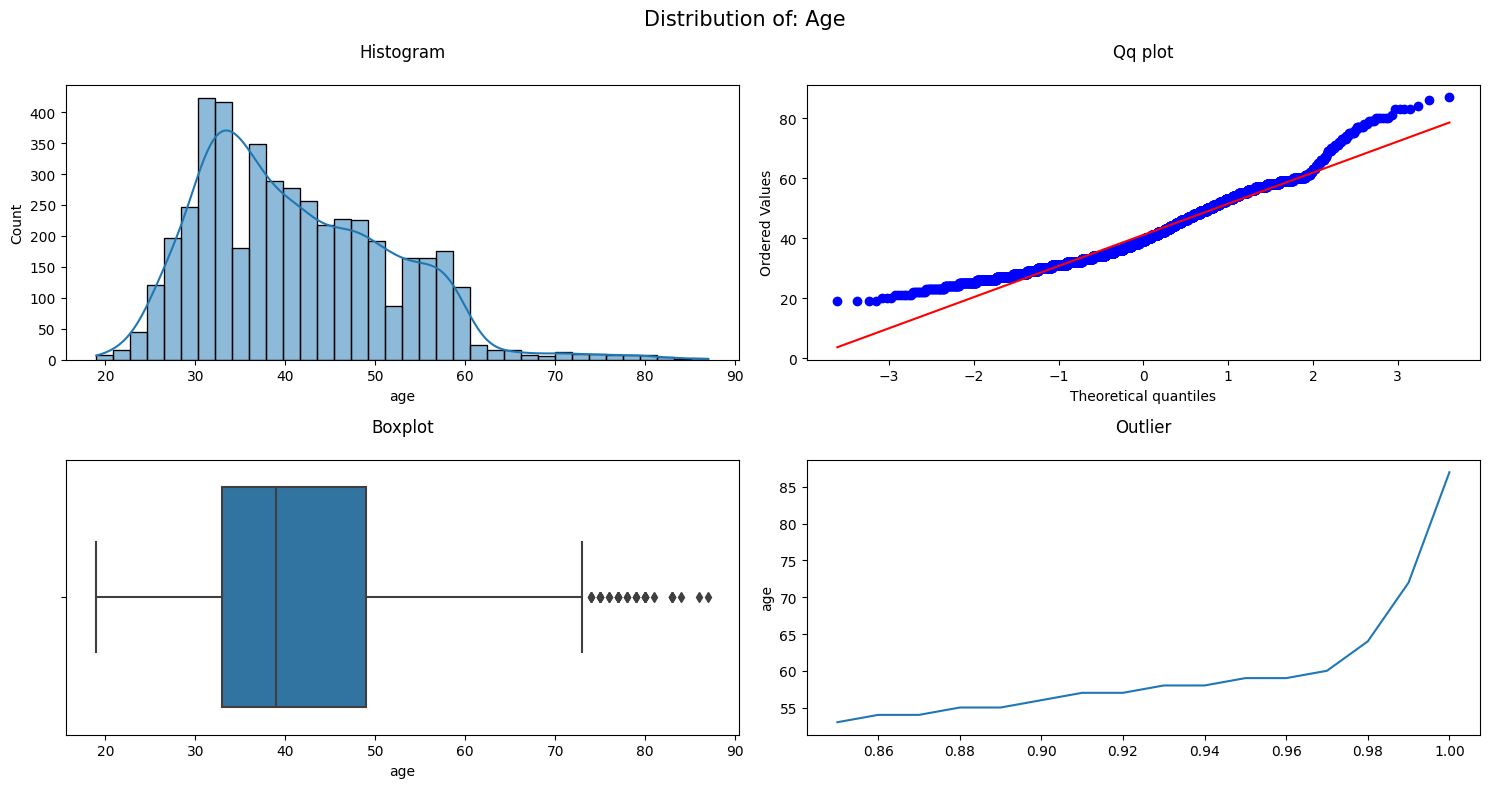

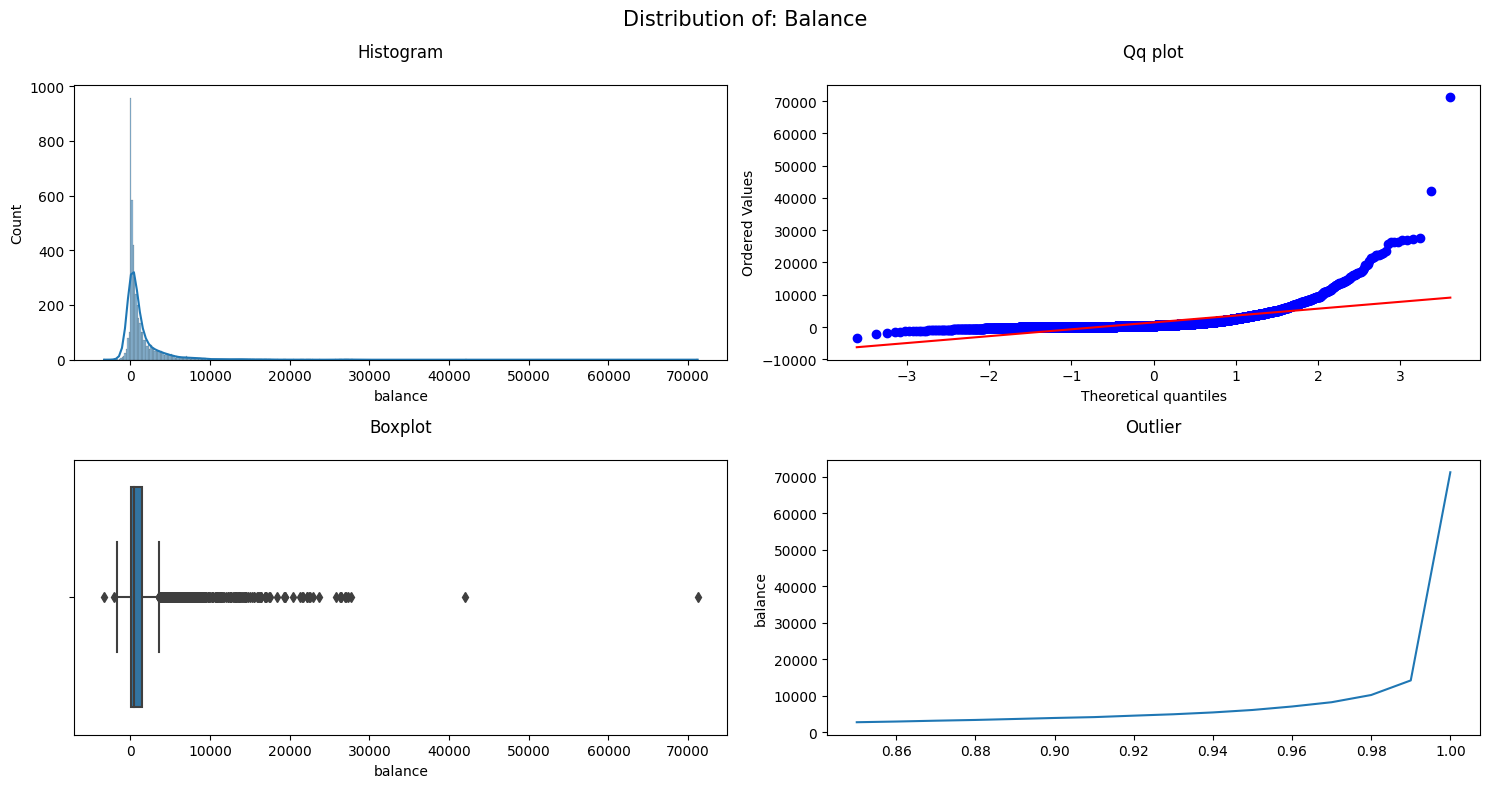

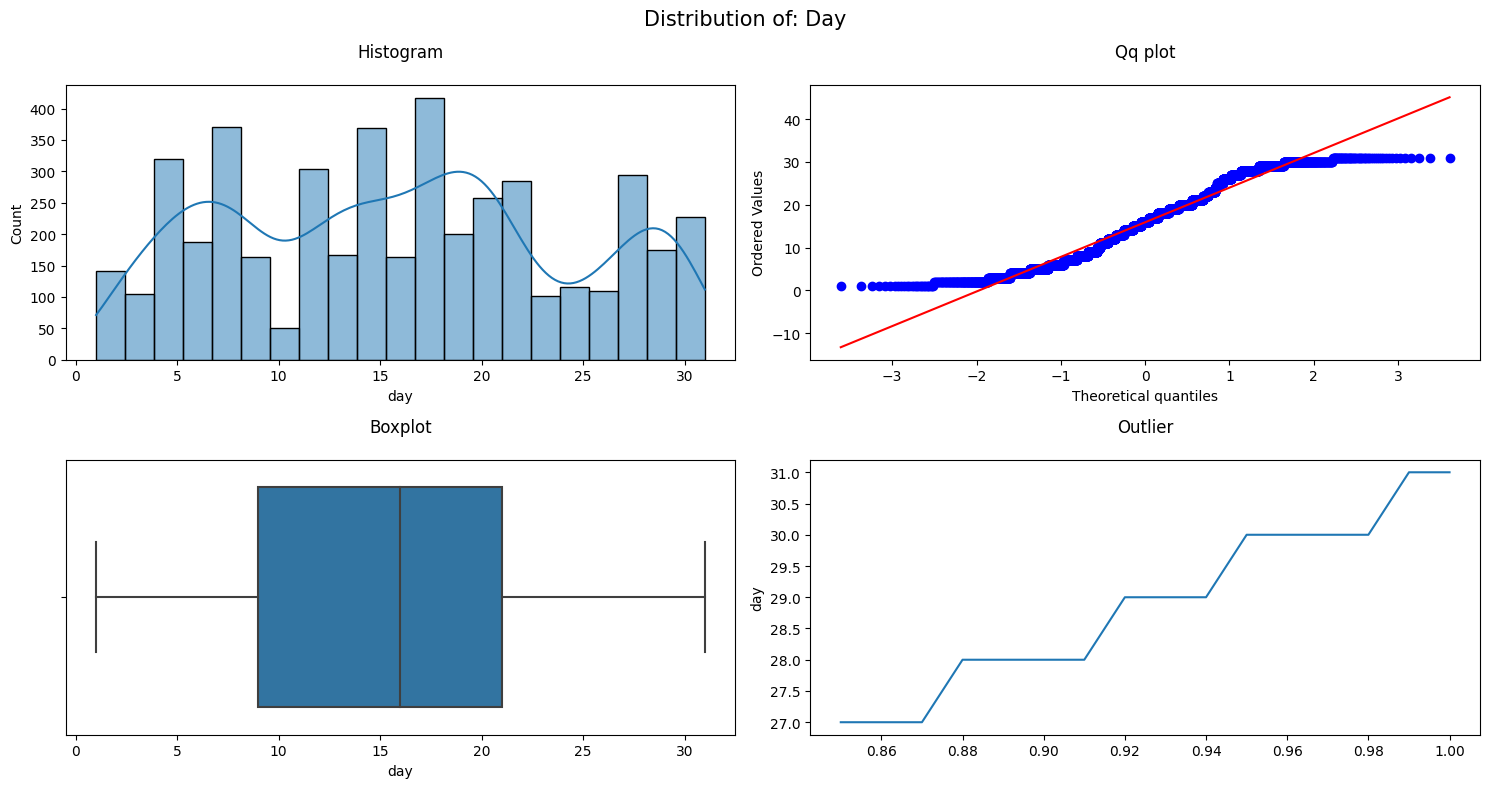

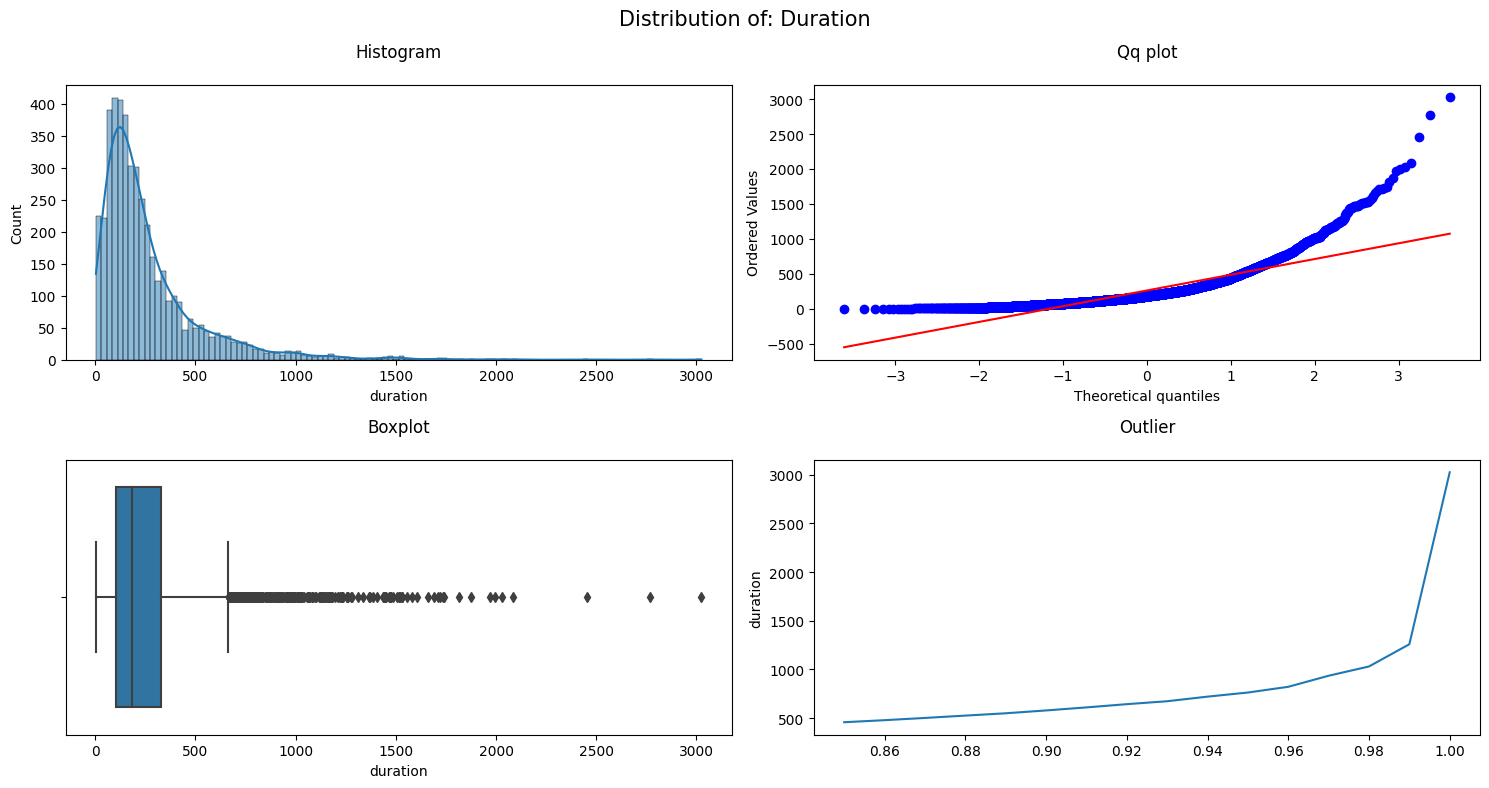

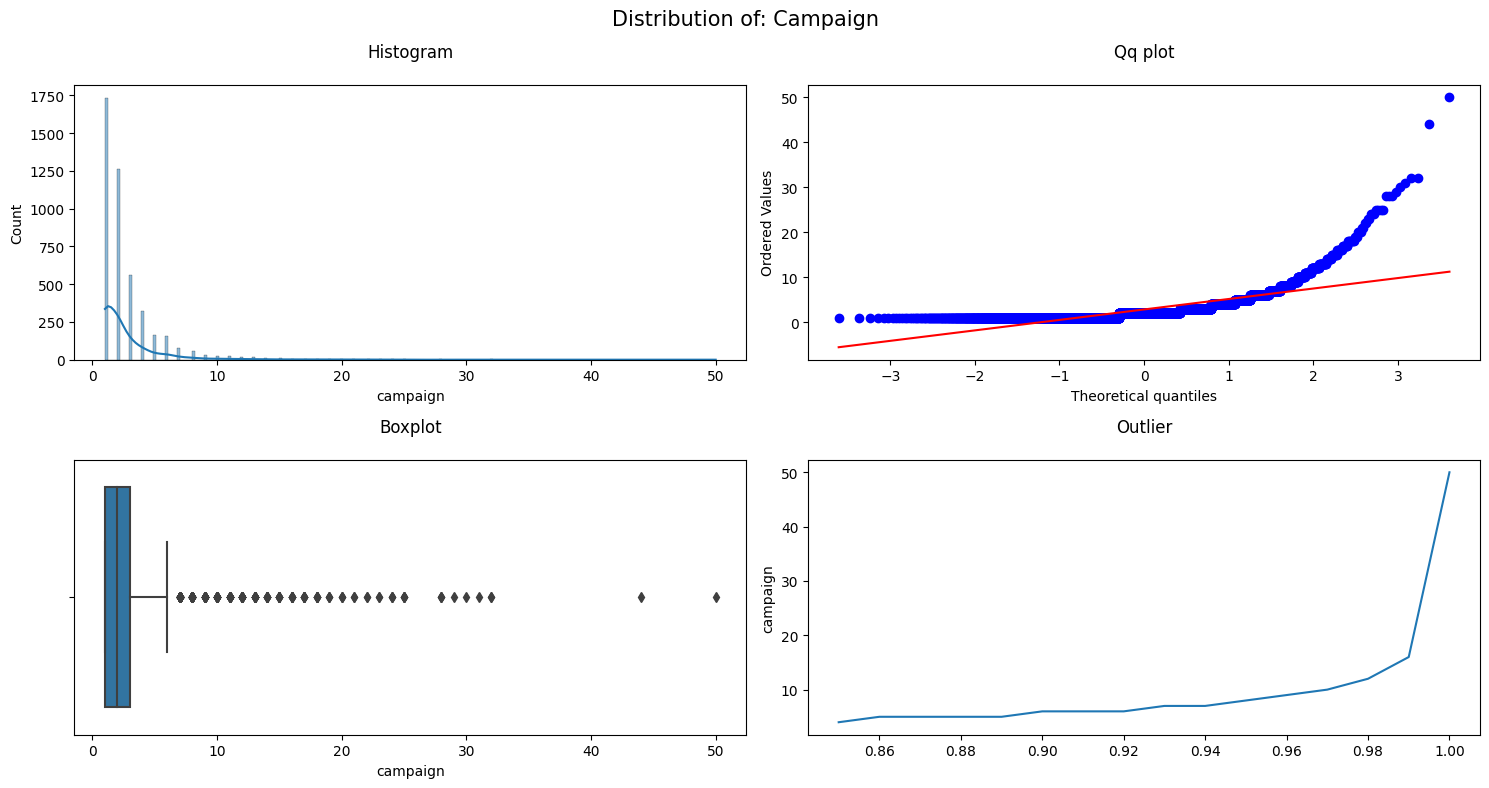

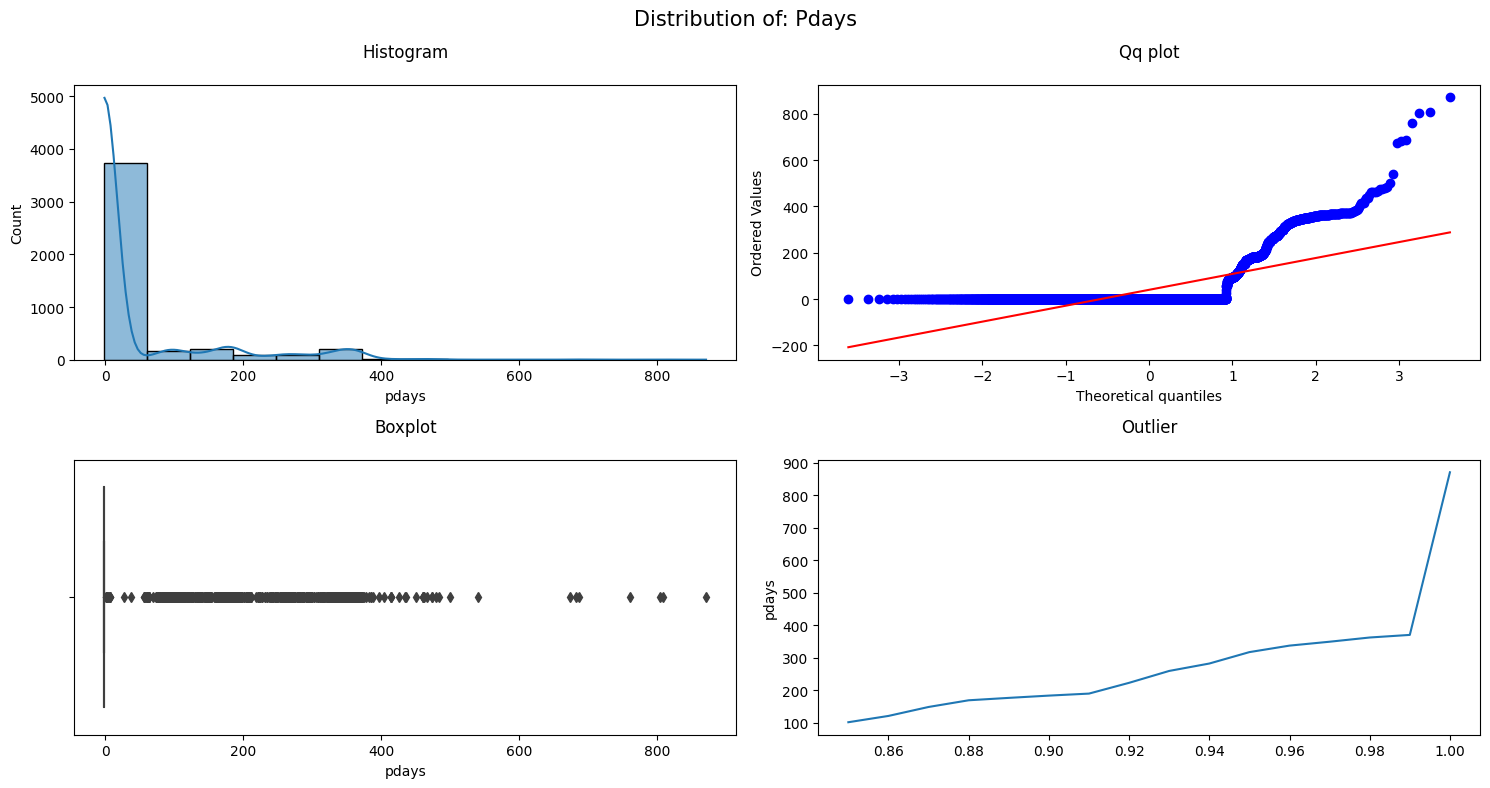

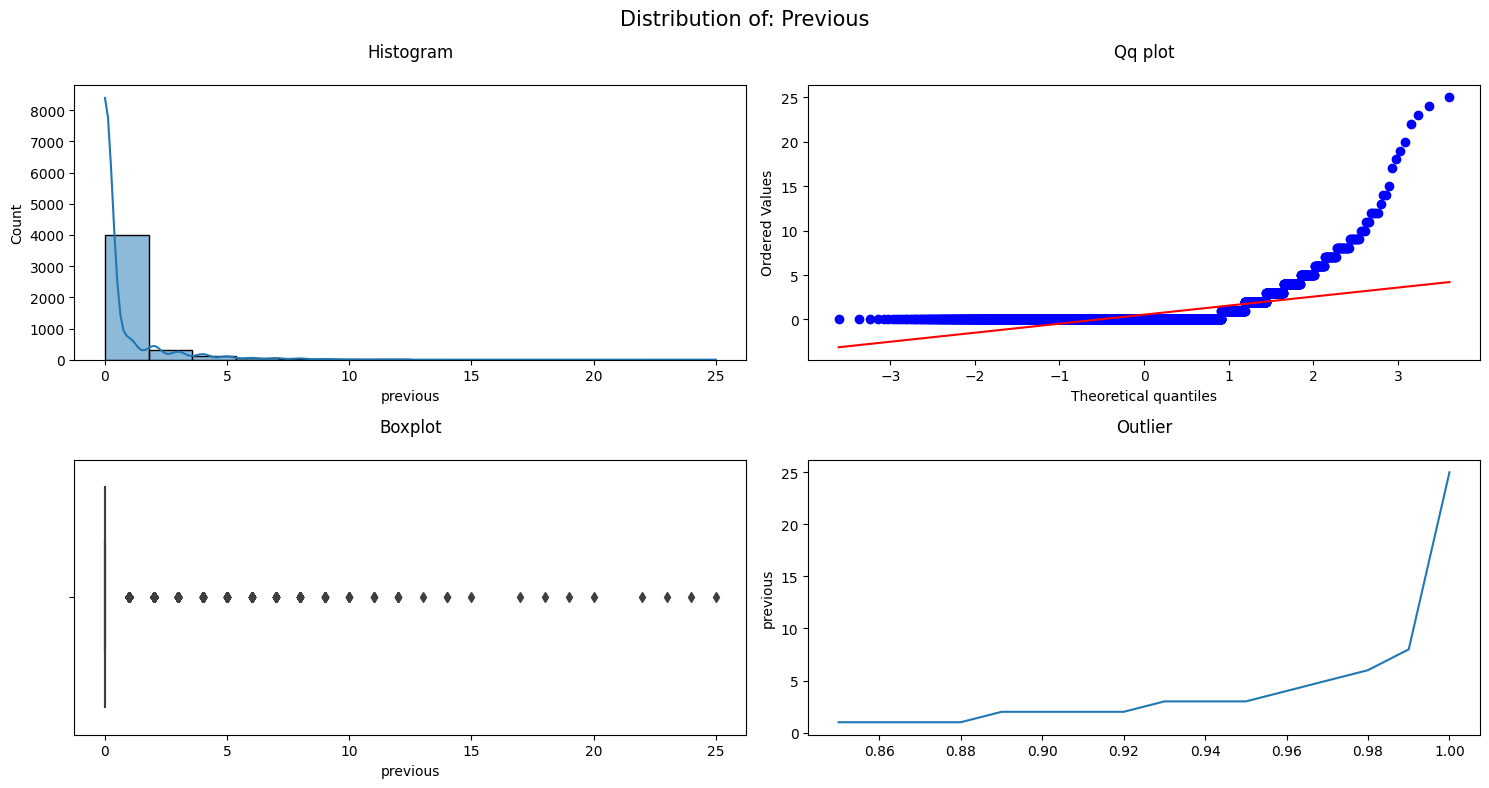

In [24]:
for column in numerical_df.columns:
    summary_numerical(numerical_df, column, 0.85, 1, upload=1)

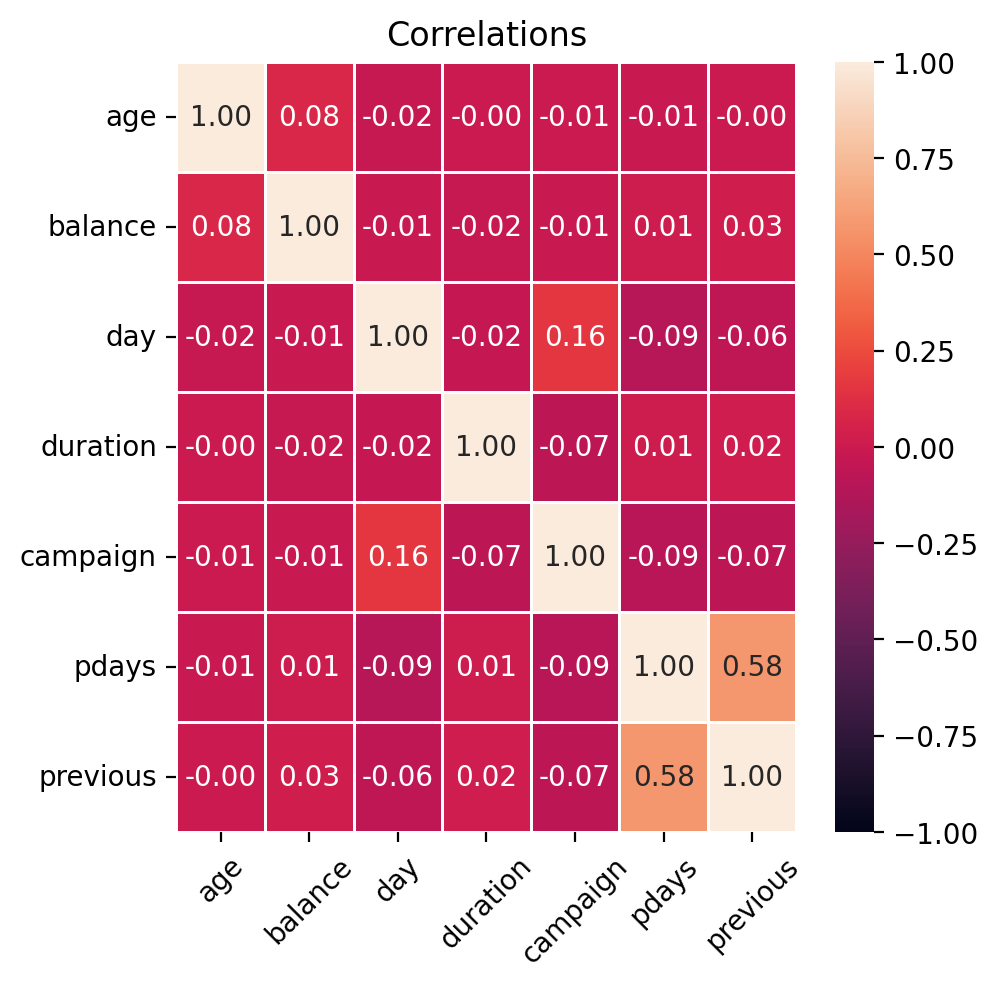

In [25]:
# %%writefile /Users/konstantinsokolovskiy/Desktop/My_Big_Project/final/projects/projects/project_3/data/code_snippets/correlation_matrix.txt
fig, ax = plt.subplots(figsize = (5, 5), dpi=200)

sns.heatmap(
    data=numerical_df.corr(),
    vmin=-1,
    vmax=1,
    linecolor="white",
    linewidth=0.5,
    annot=True,
    fmt=".2f",
    ax=ax
)
plt.xticks(rotation=45)
plt.title('Correlations'); 
# upload_plot('correlation_matrix')

##### Multicollinearity

In [26]:
# %%writefile /Users/konstantinsokolovskiy/Desktop/My_Big_Project/final/projects/projects/project_3/data/code_snippets/multicollinearity.txt
vif_data = pd.DataFrame()
vif_data["feature"] = numerical_df.columns

vif_data["VIF"] = [variance_inflation_factor(numerical_df.values, i) 
                   for i in range(numerical_df.shape[1])]

vif_data

feature       VIF
0       age  5.092604
1   balance  1.231819
2       day  4.057535
3  duration  1.928720
4  campaign  1.830360
5     pdays  1.733904
6  previous  1.655651

In [ ]:
upload_csv(vif_data, 'vif_data')

#### Categorical

In [31]:
count_categorical_features = partial(count_categorical, df=categorical_df)

##### Target 

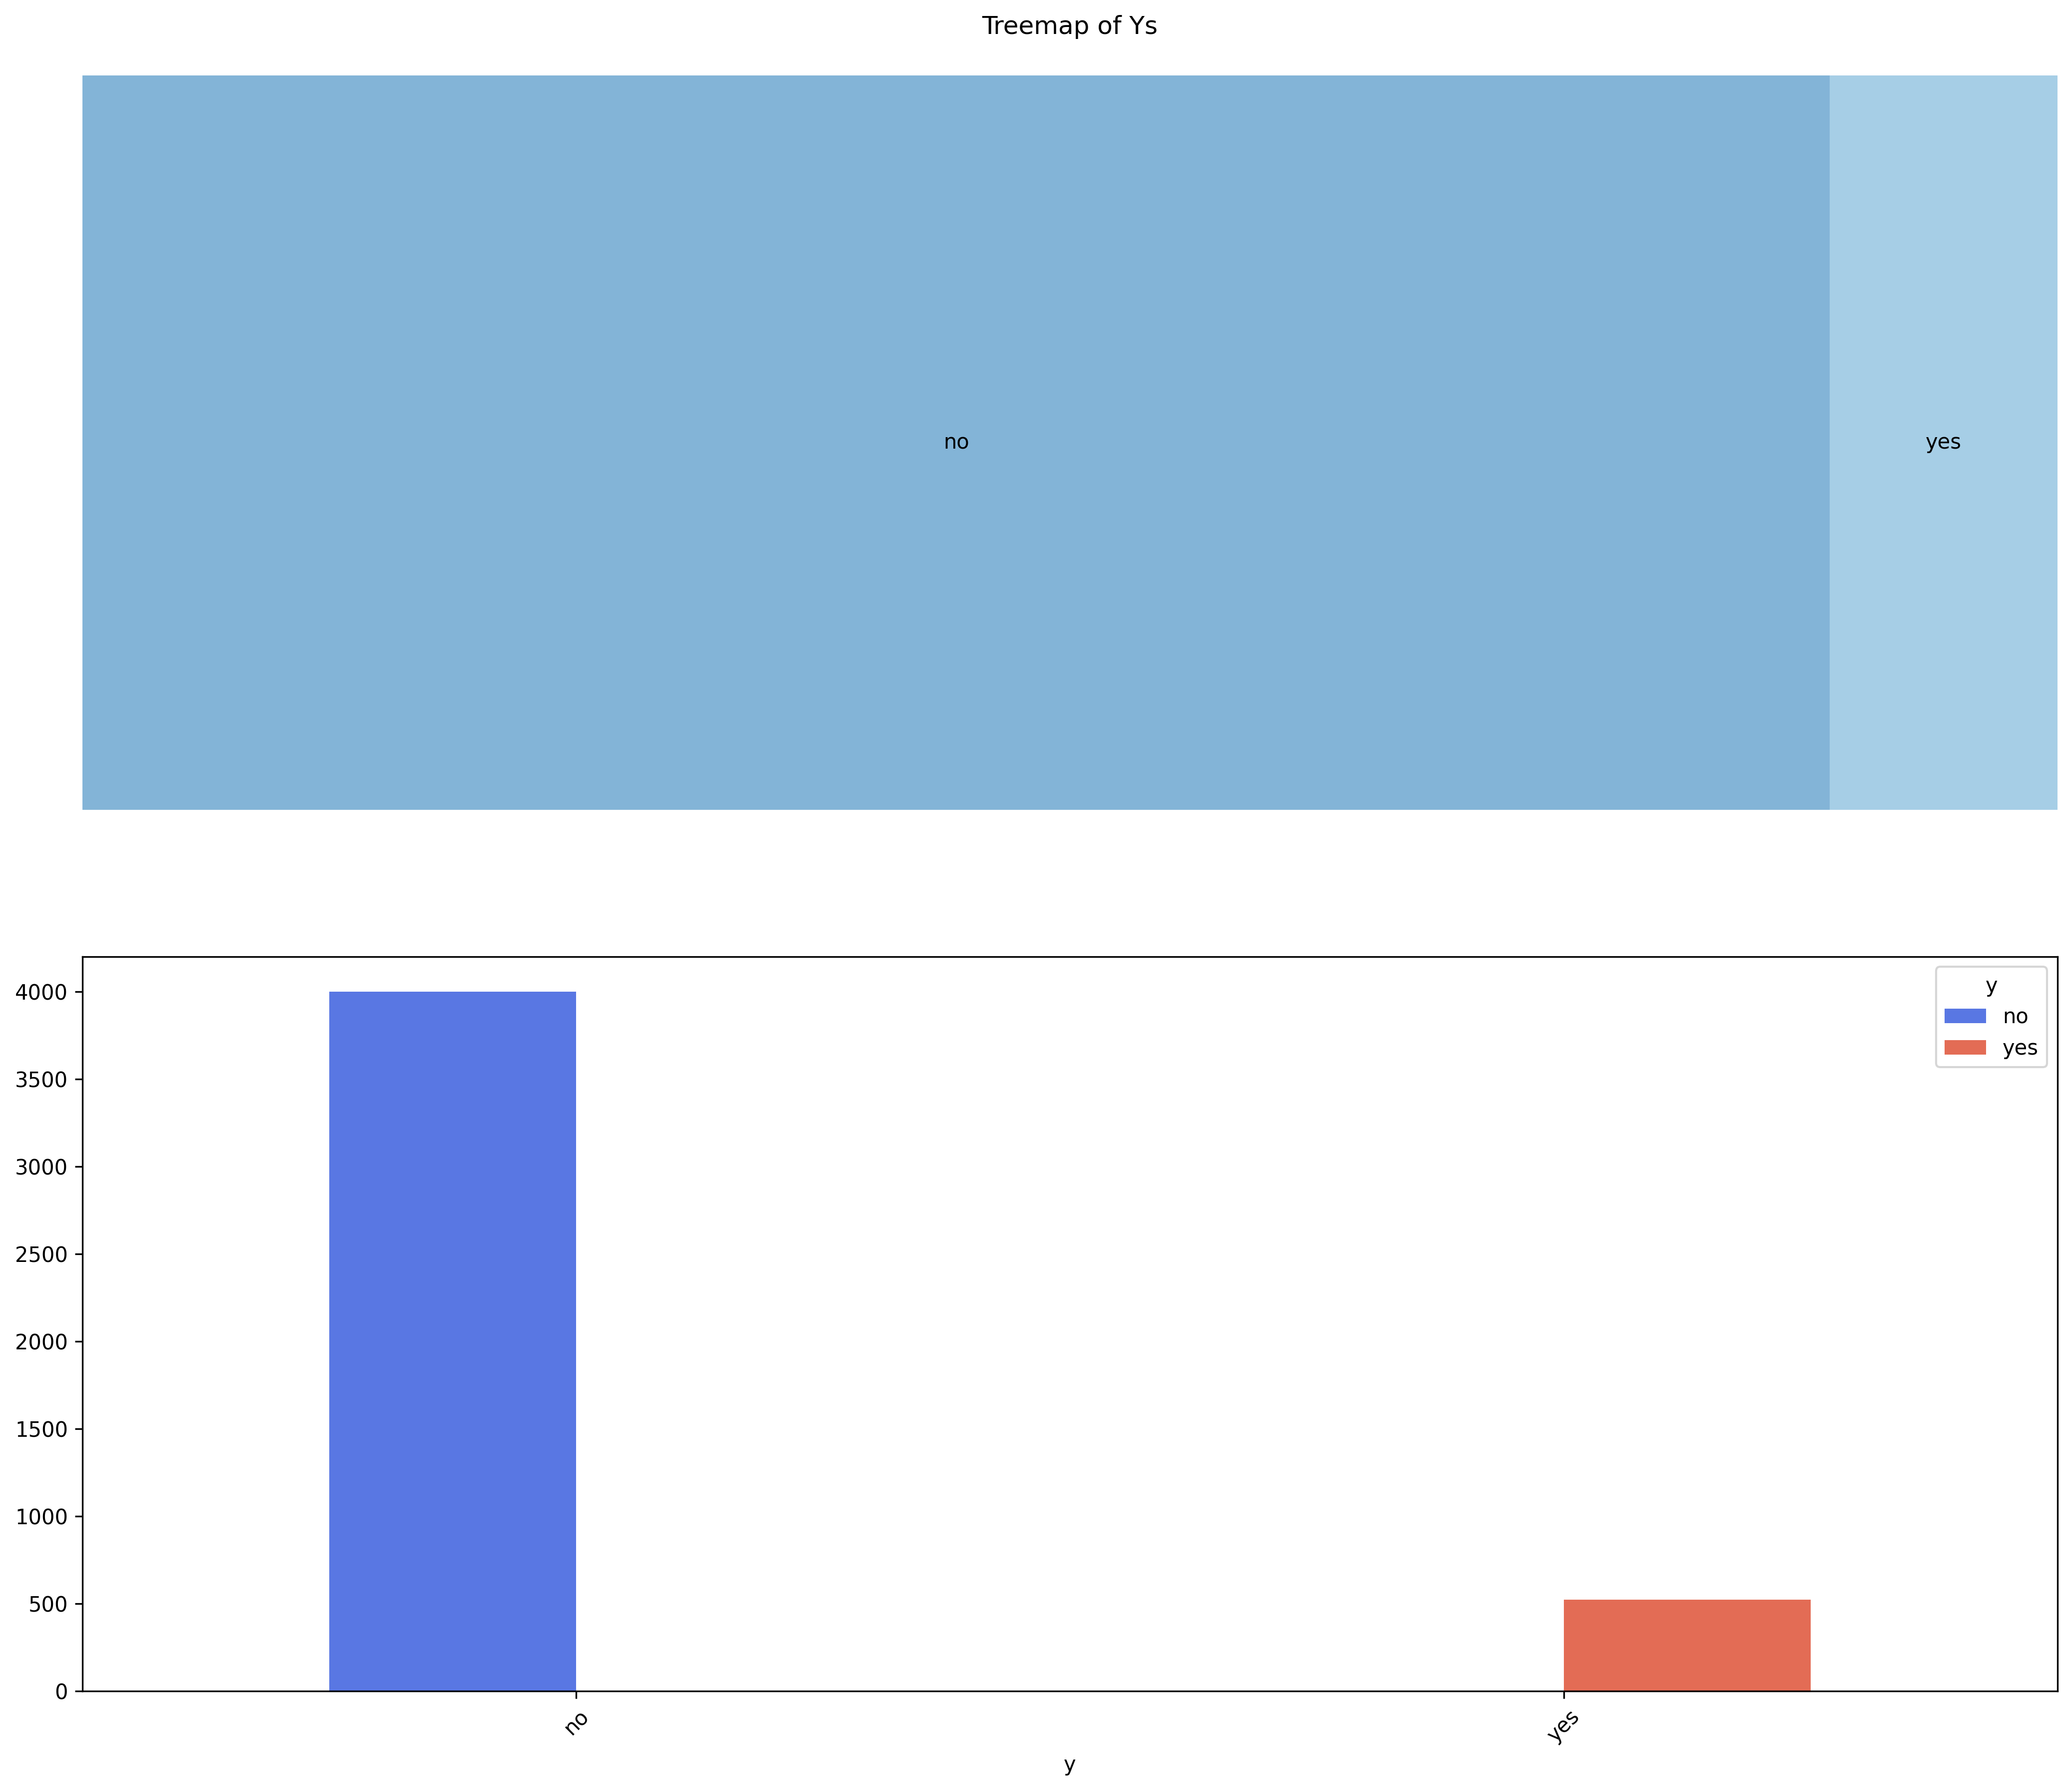

In [32]:
count_categorical_features(column='y', target=1)

##### Job

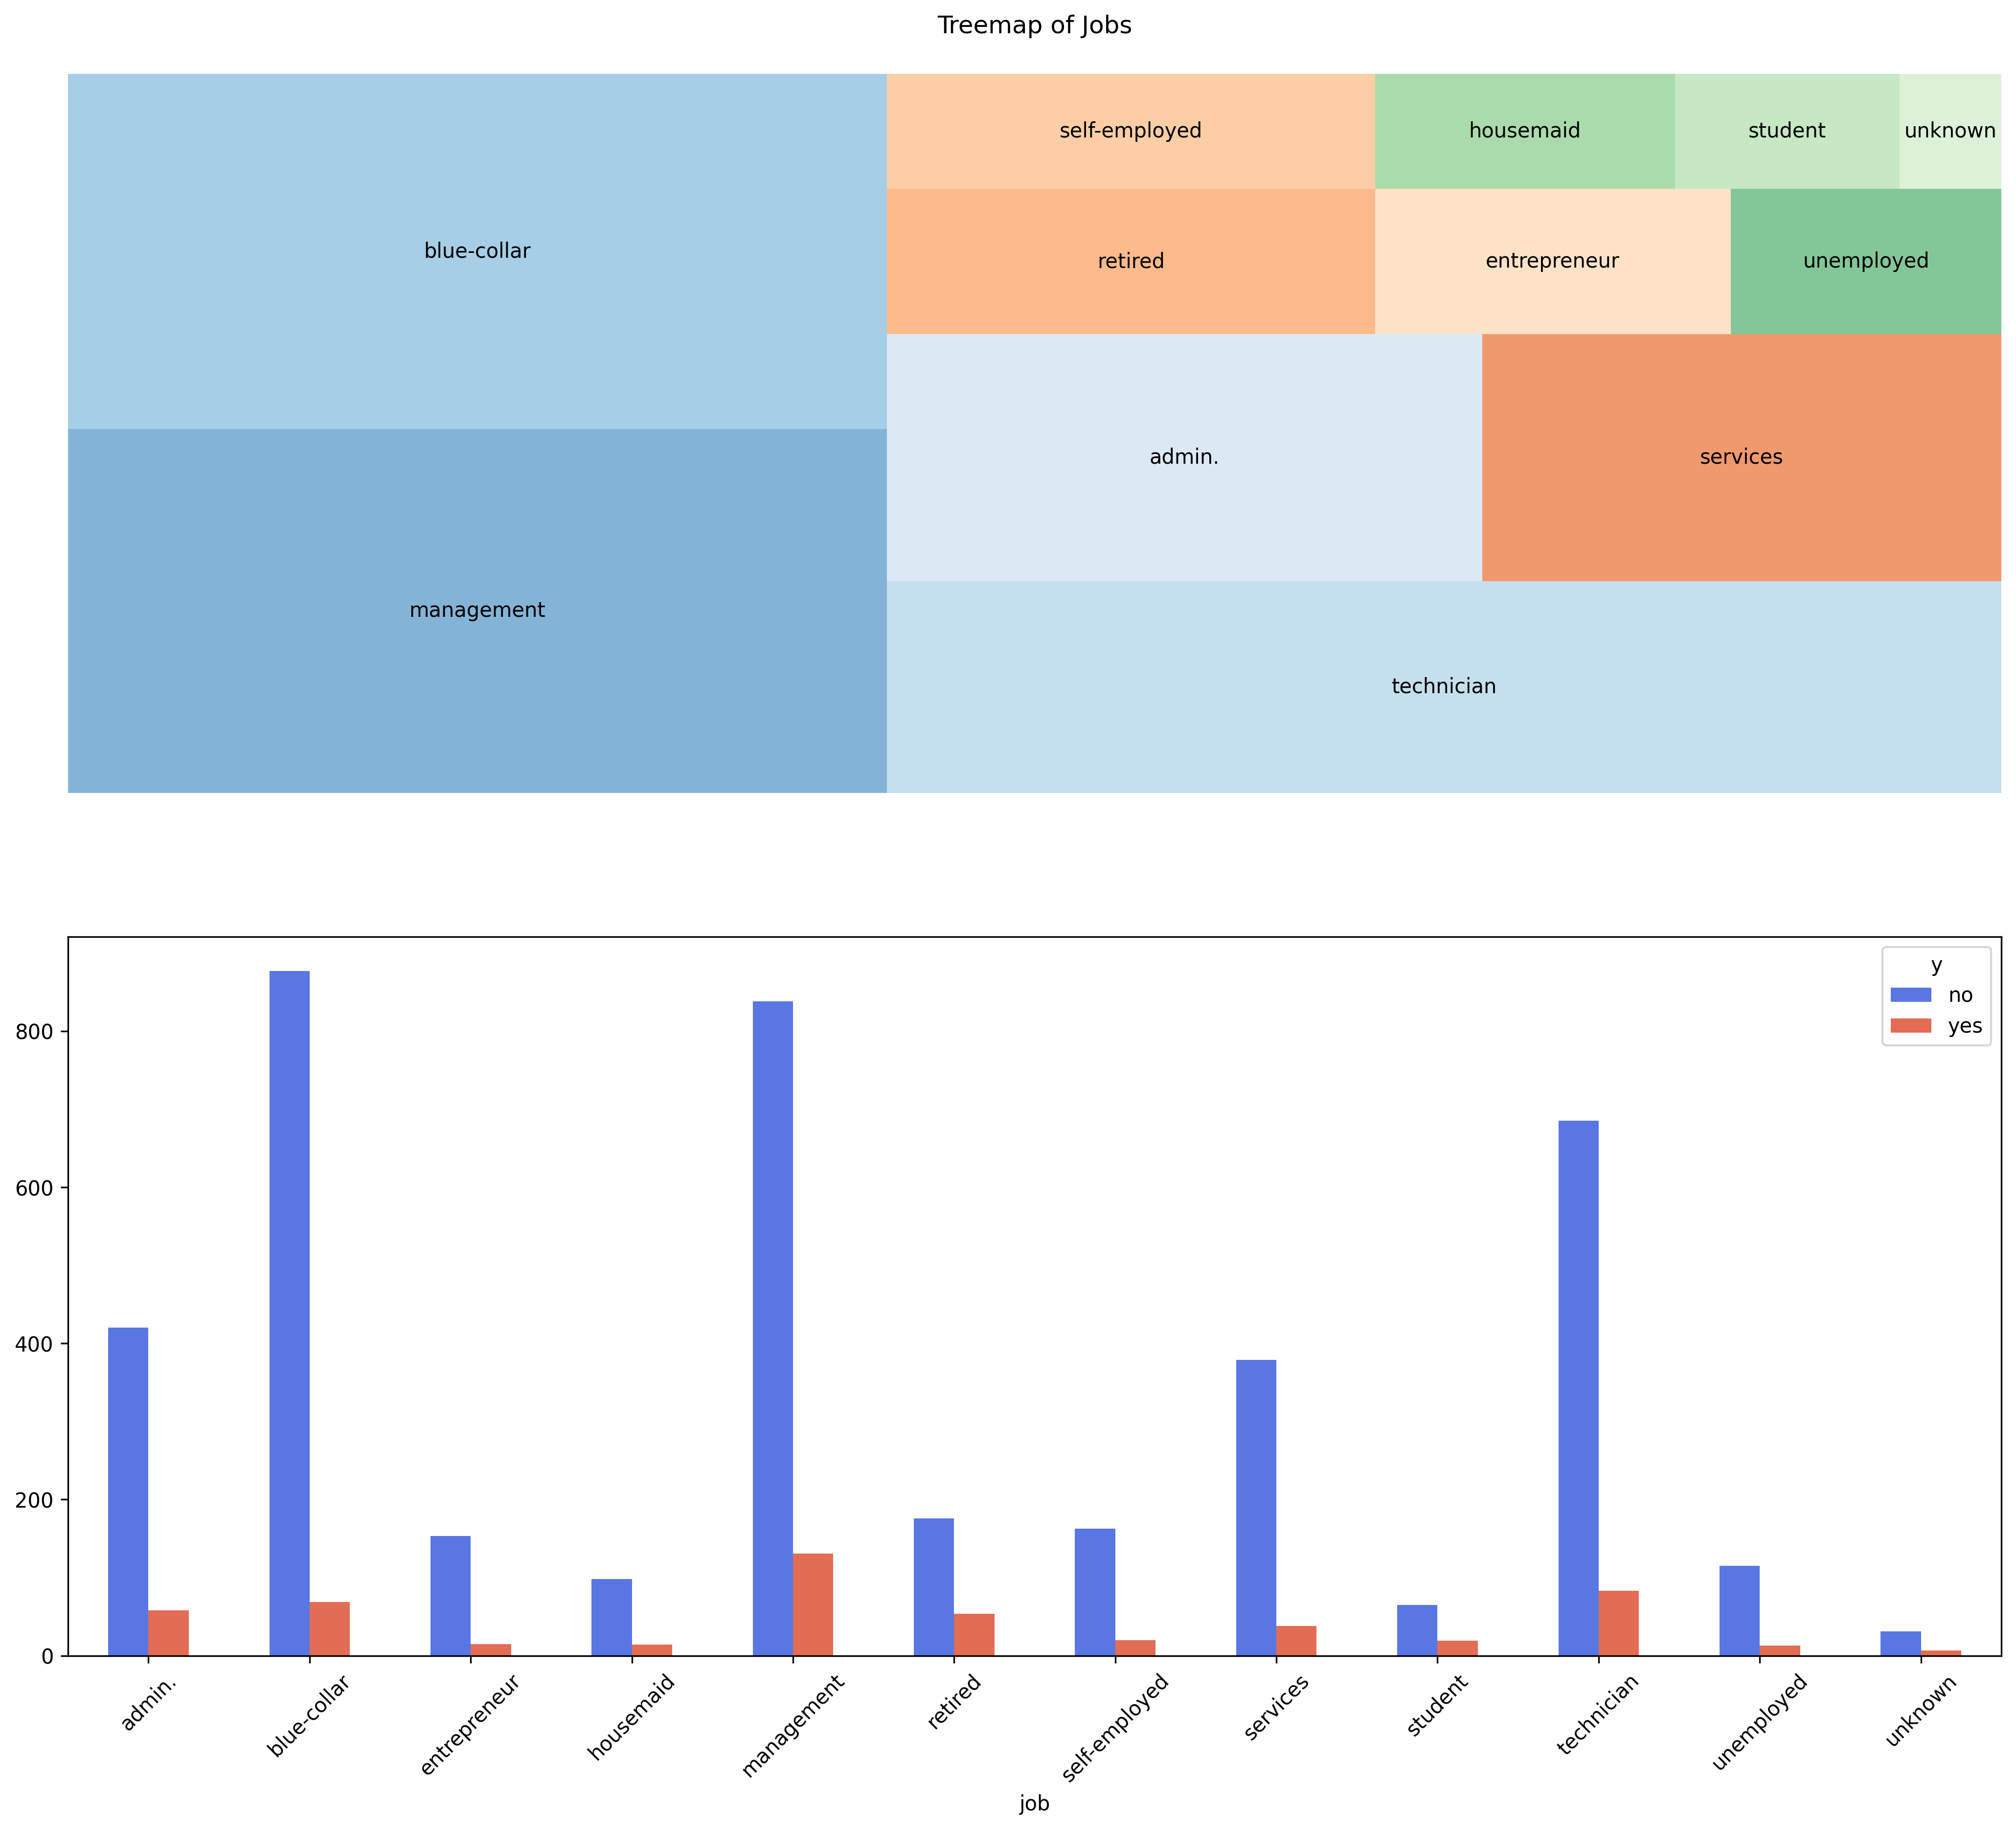

In [33]:
count_categorical_features(column='job')
# upload_plot('distribution_job')

In [34]:
chi2_job, p_job, _, _ = cat_to_target(categorical_df, 'job')
p_job

1.901391096662705e-10

##### Marital

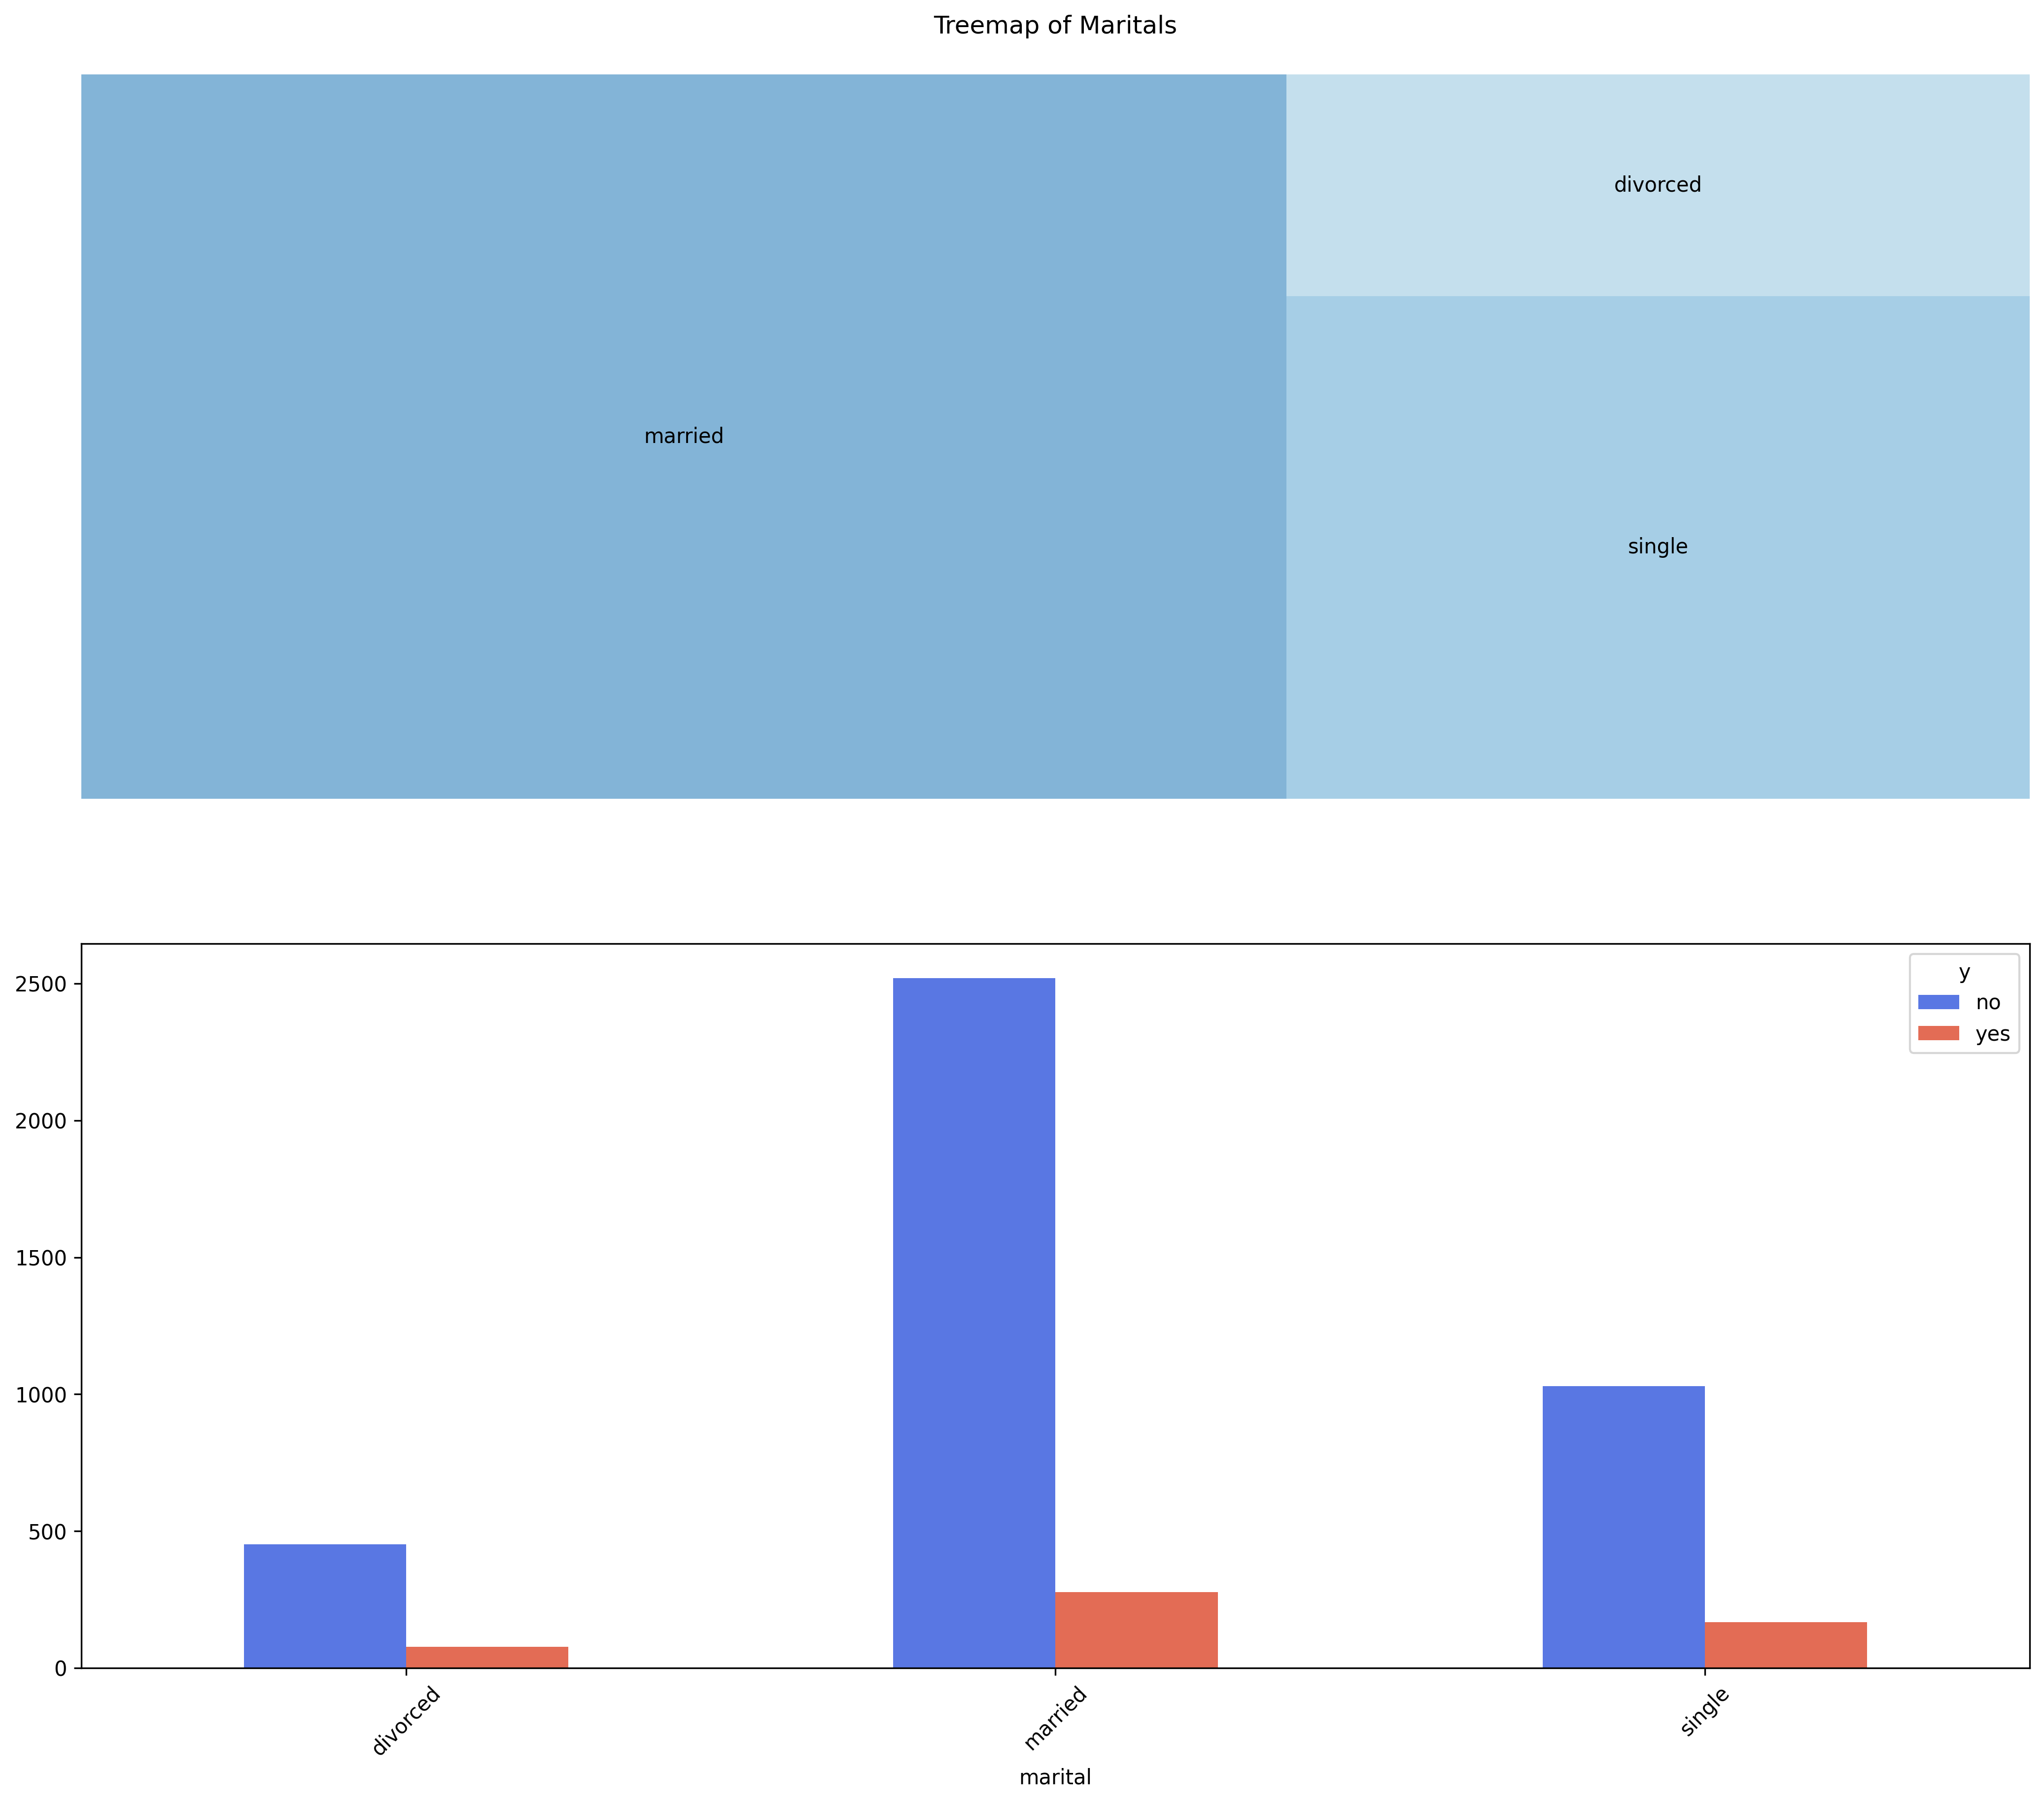

In [35]:
count_categorical_features(column='marital')
# upload_plot('distribution_marital')

In [36]:
chi2_marital, p_marital, _, _ = cat_to_target(categorical_df, 'marital')
p_marital

7.373535401823763e-05

##### Education

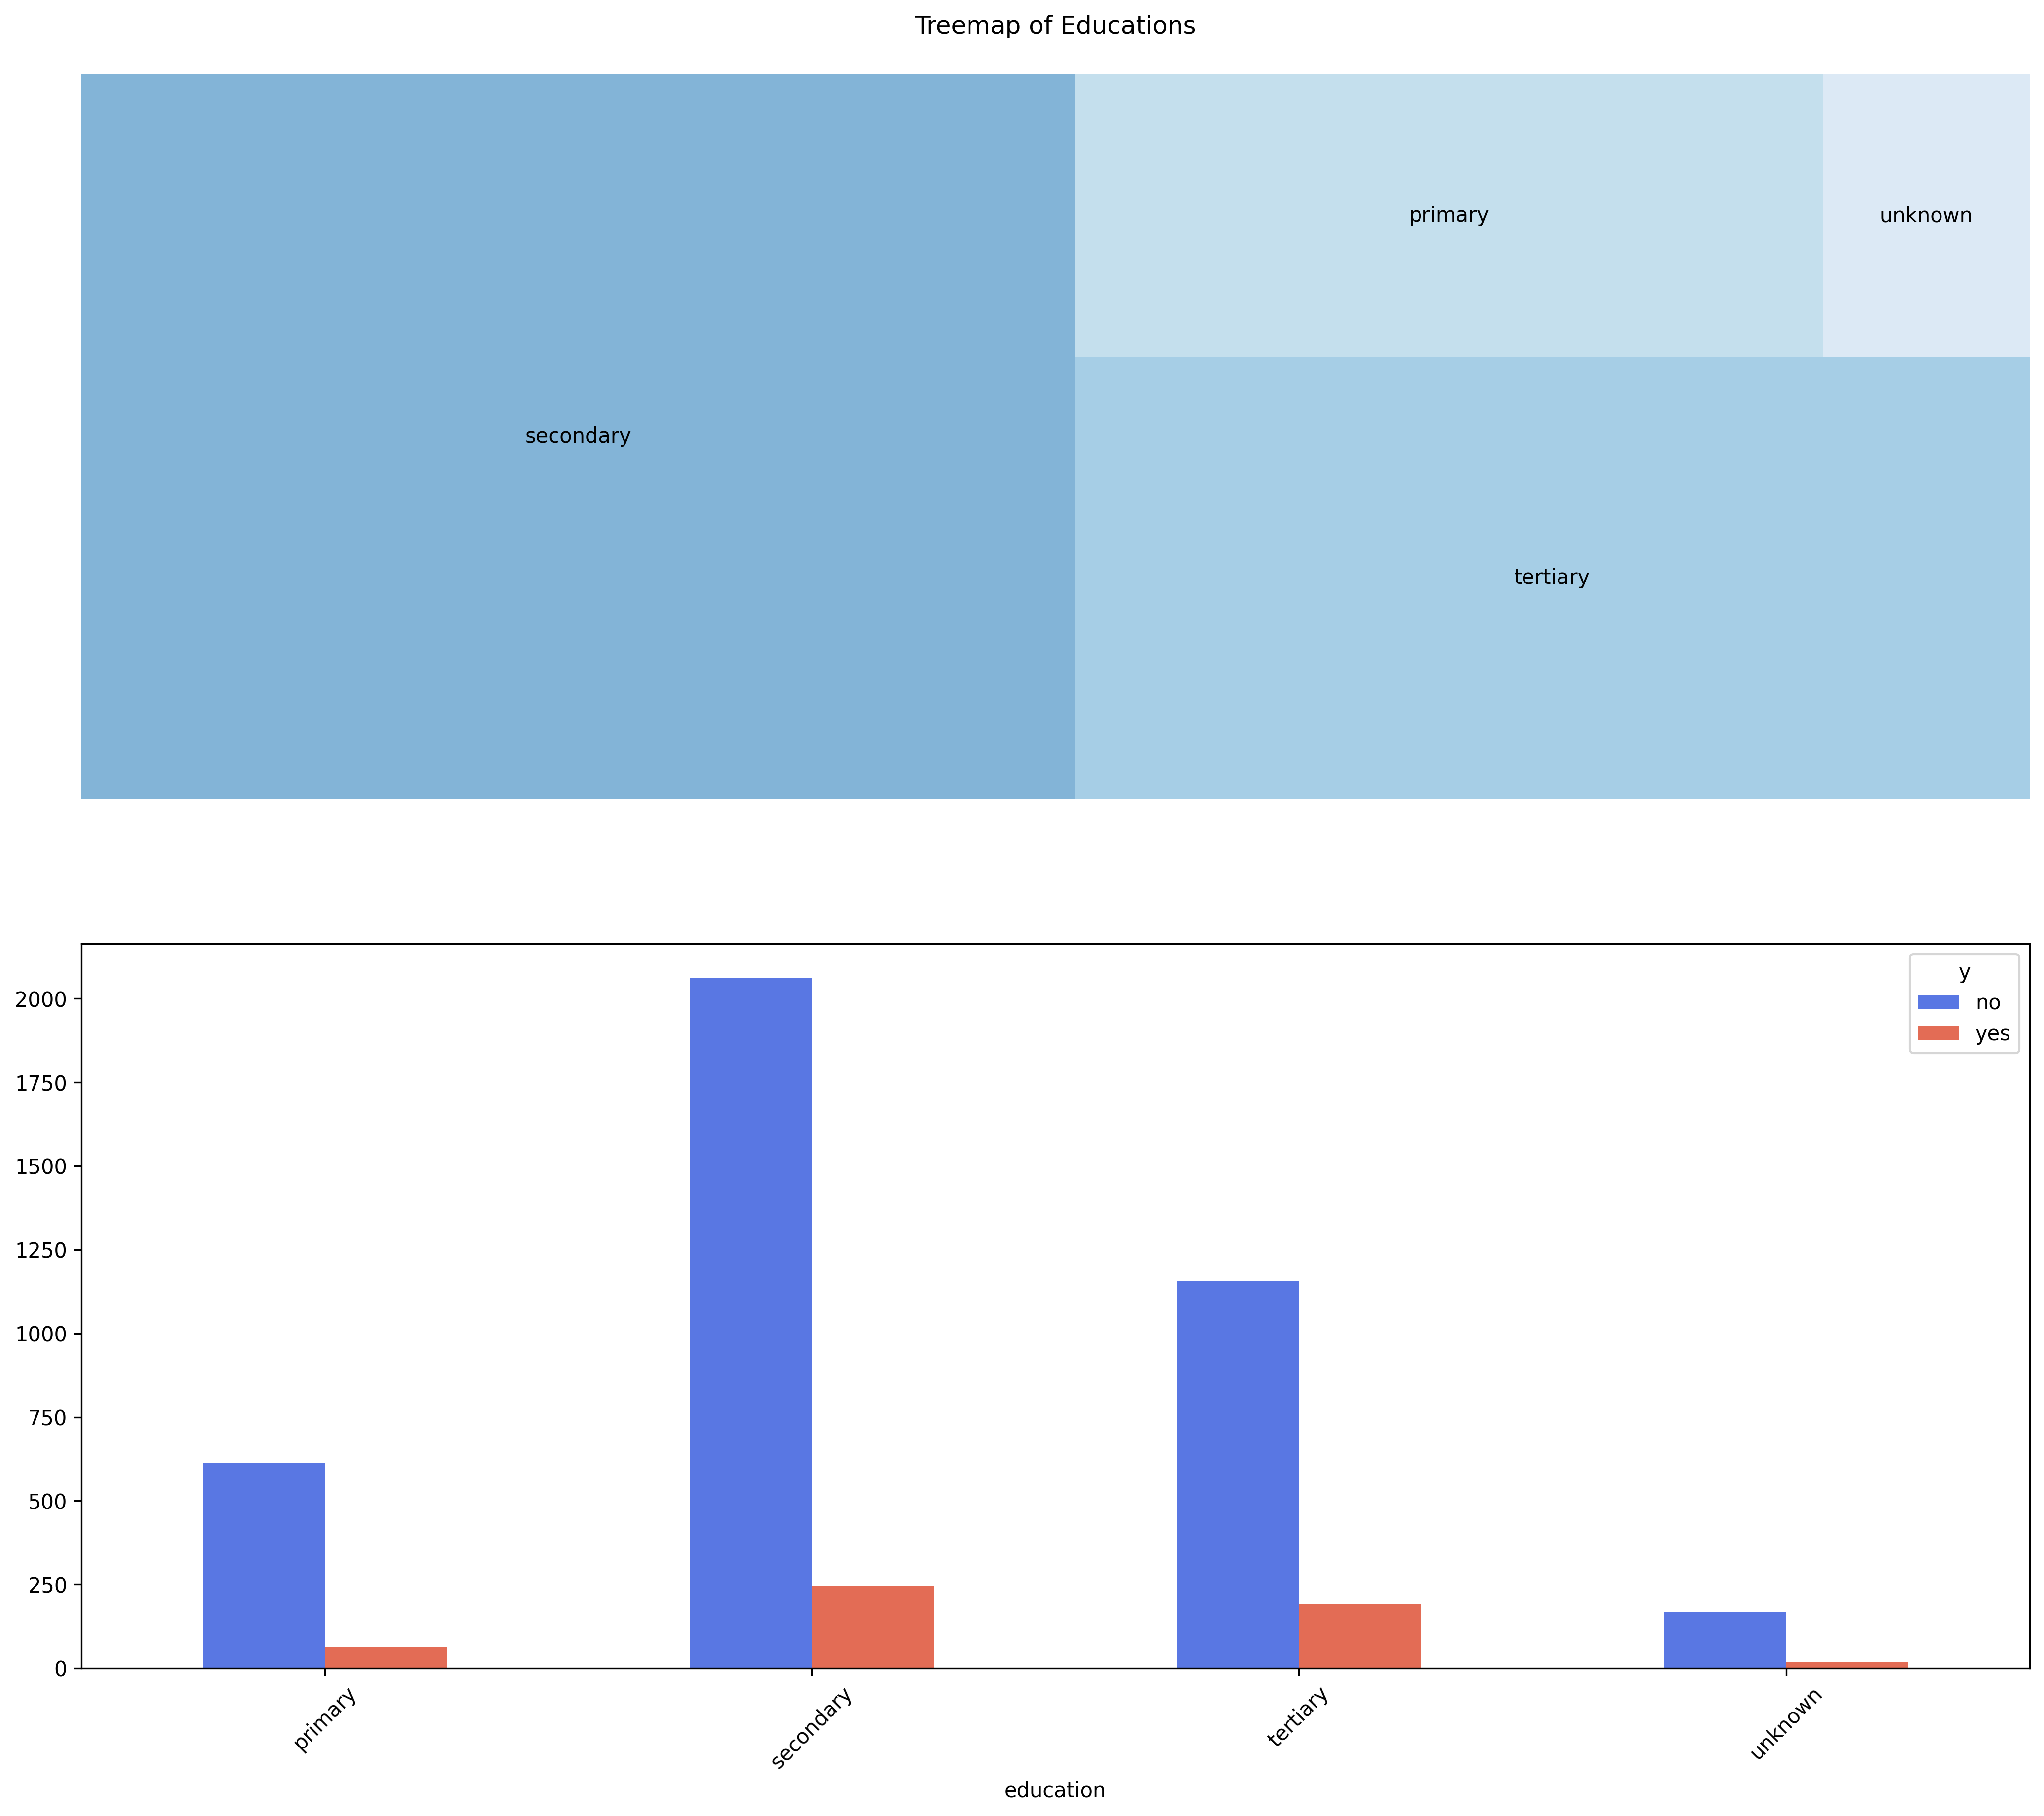

In [37]:
count_categorical_features(column='education')
# upload_plot('distribution_education')

In [38]:
chi2_education, p_education, _, _ = cat_to_target(categorical_df, 'education')
p_education

0.001625240003630989

##### Default

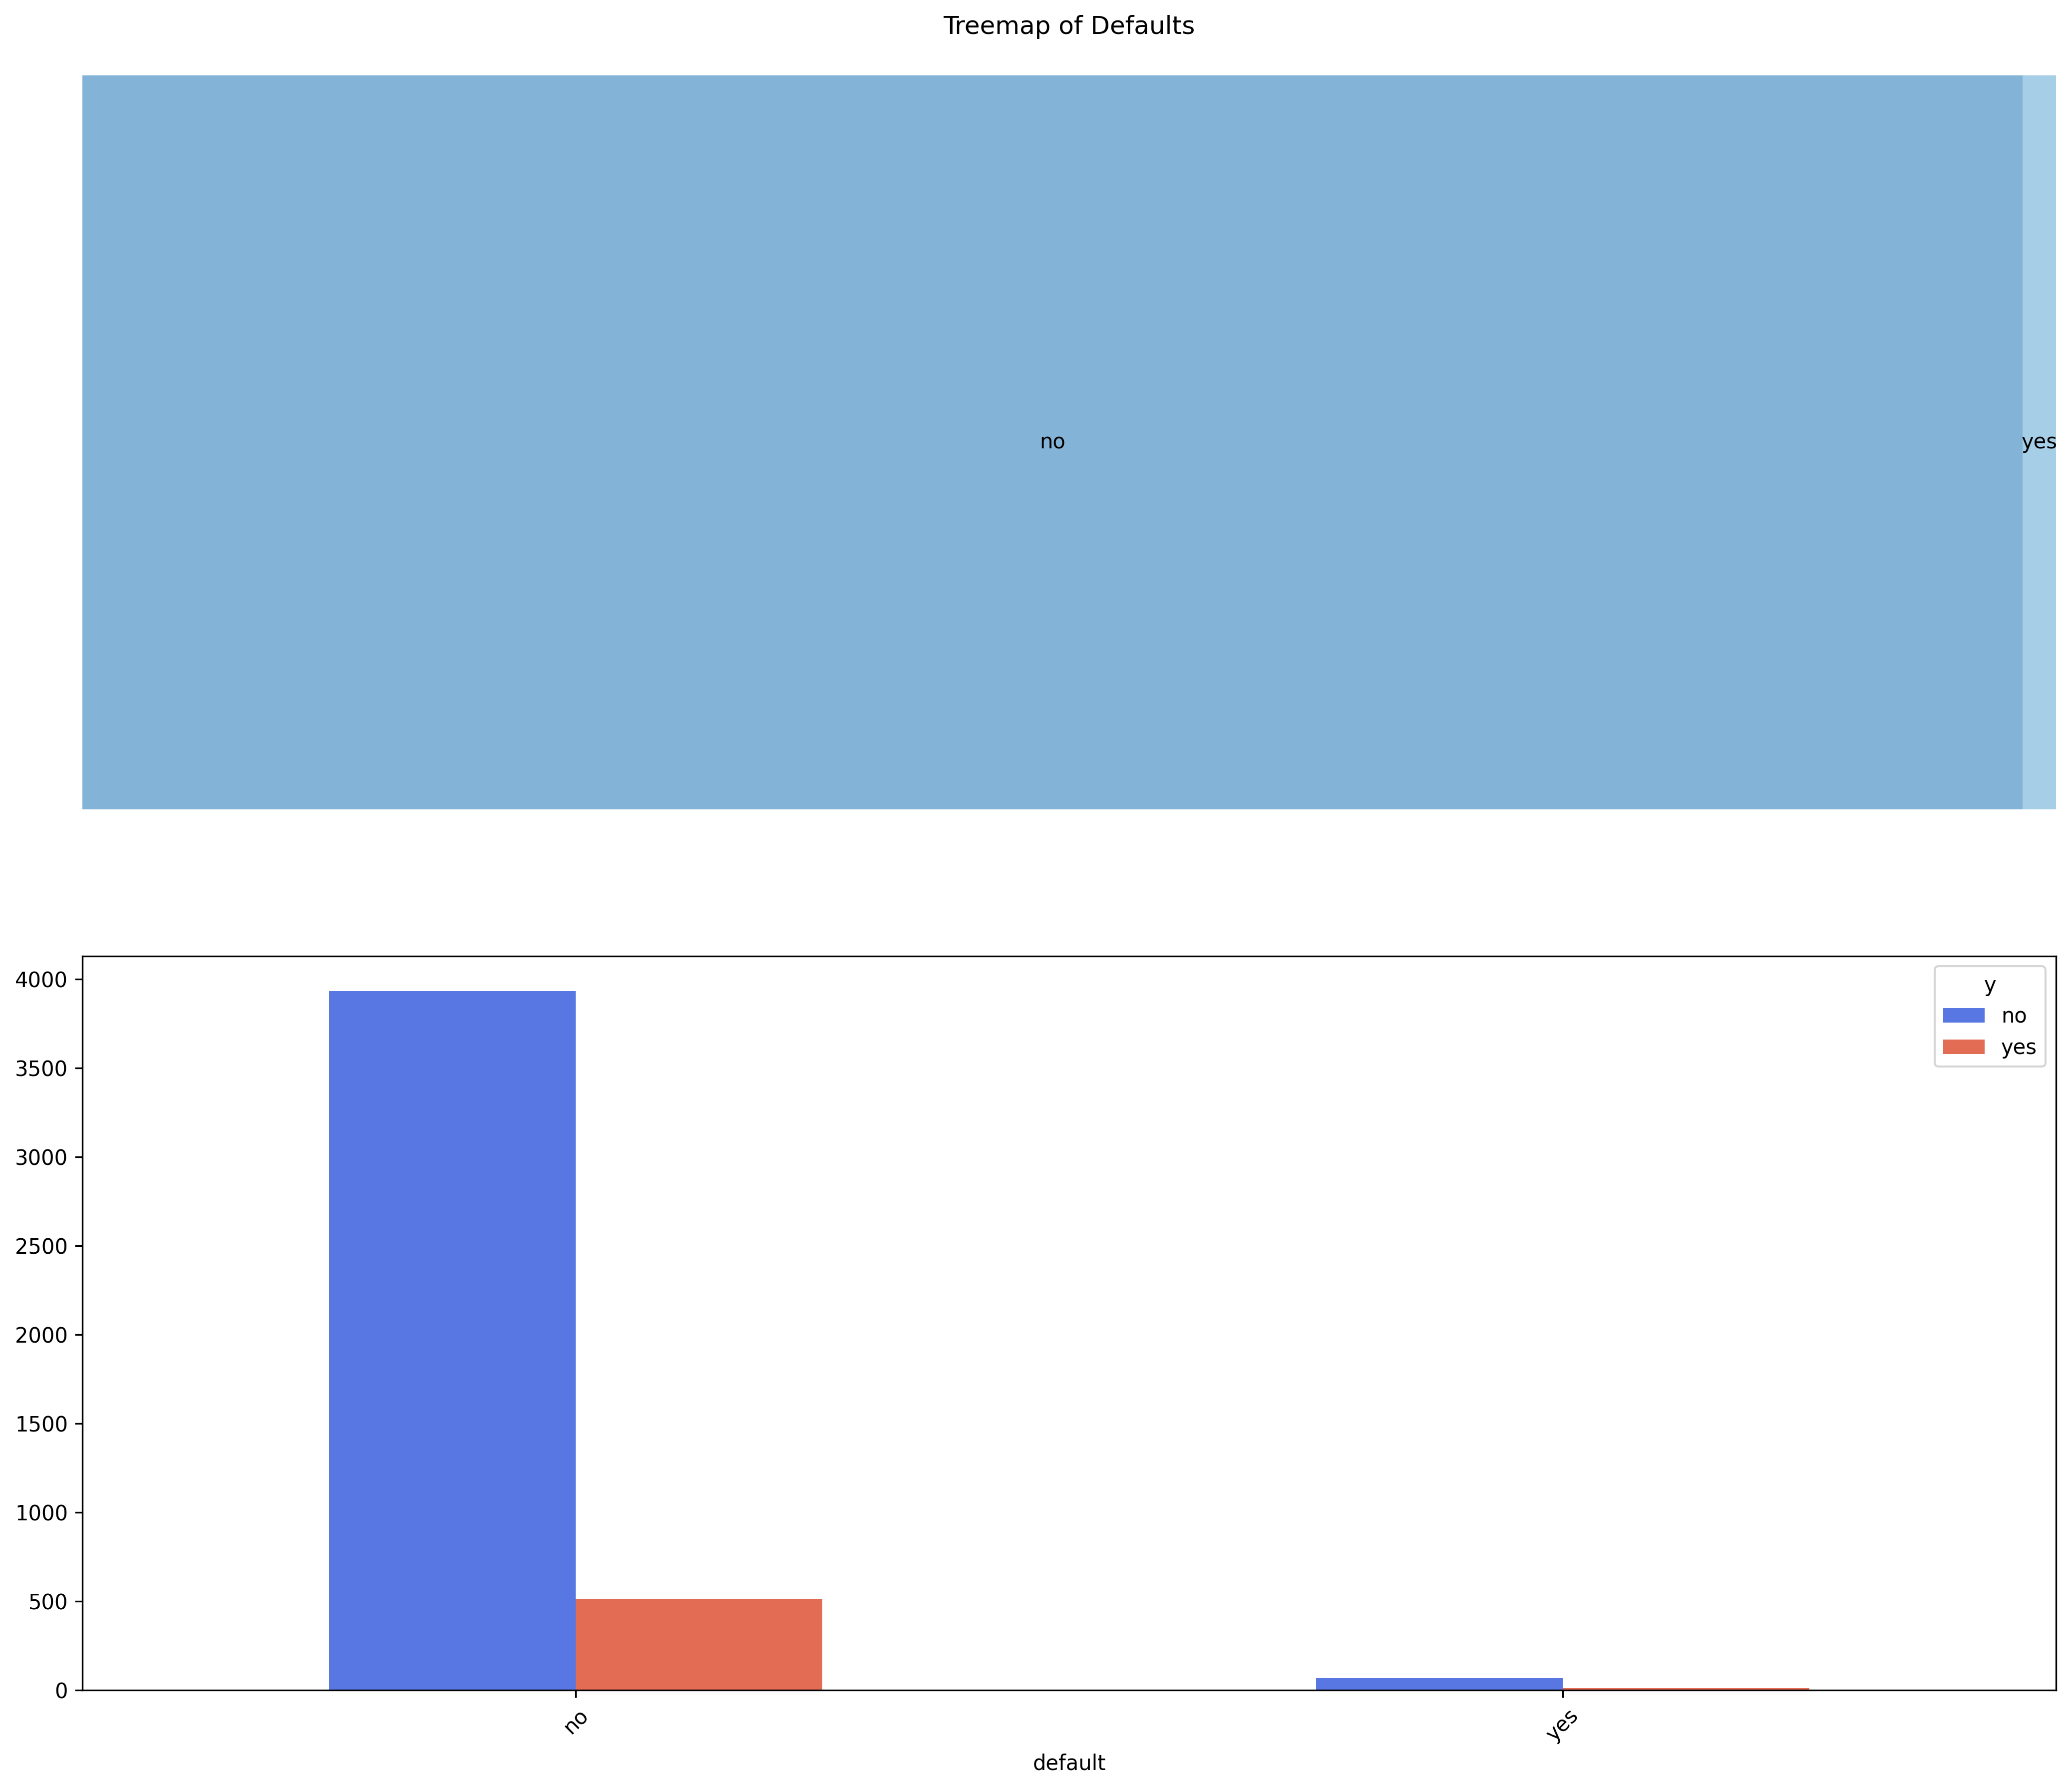

In [39]:
count_categorical_features(column='default')
# upload_plot('distribution_default')

In [40]:
chi2_default, p_default, _, _ = cat_to_target(categorical_df, 'default')
p_default

1.0

##### Housing

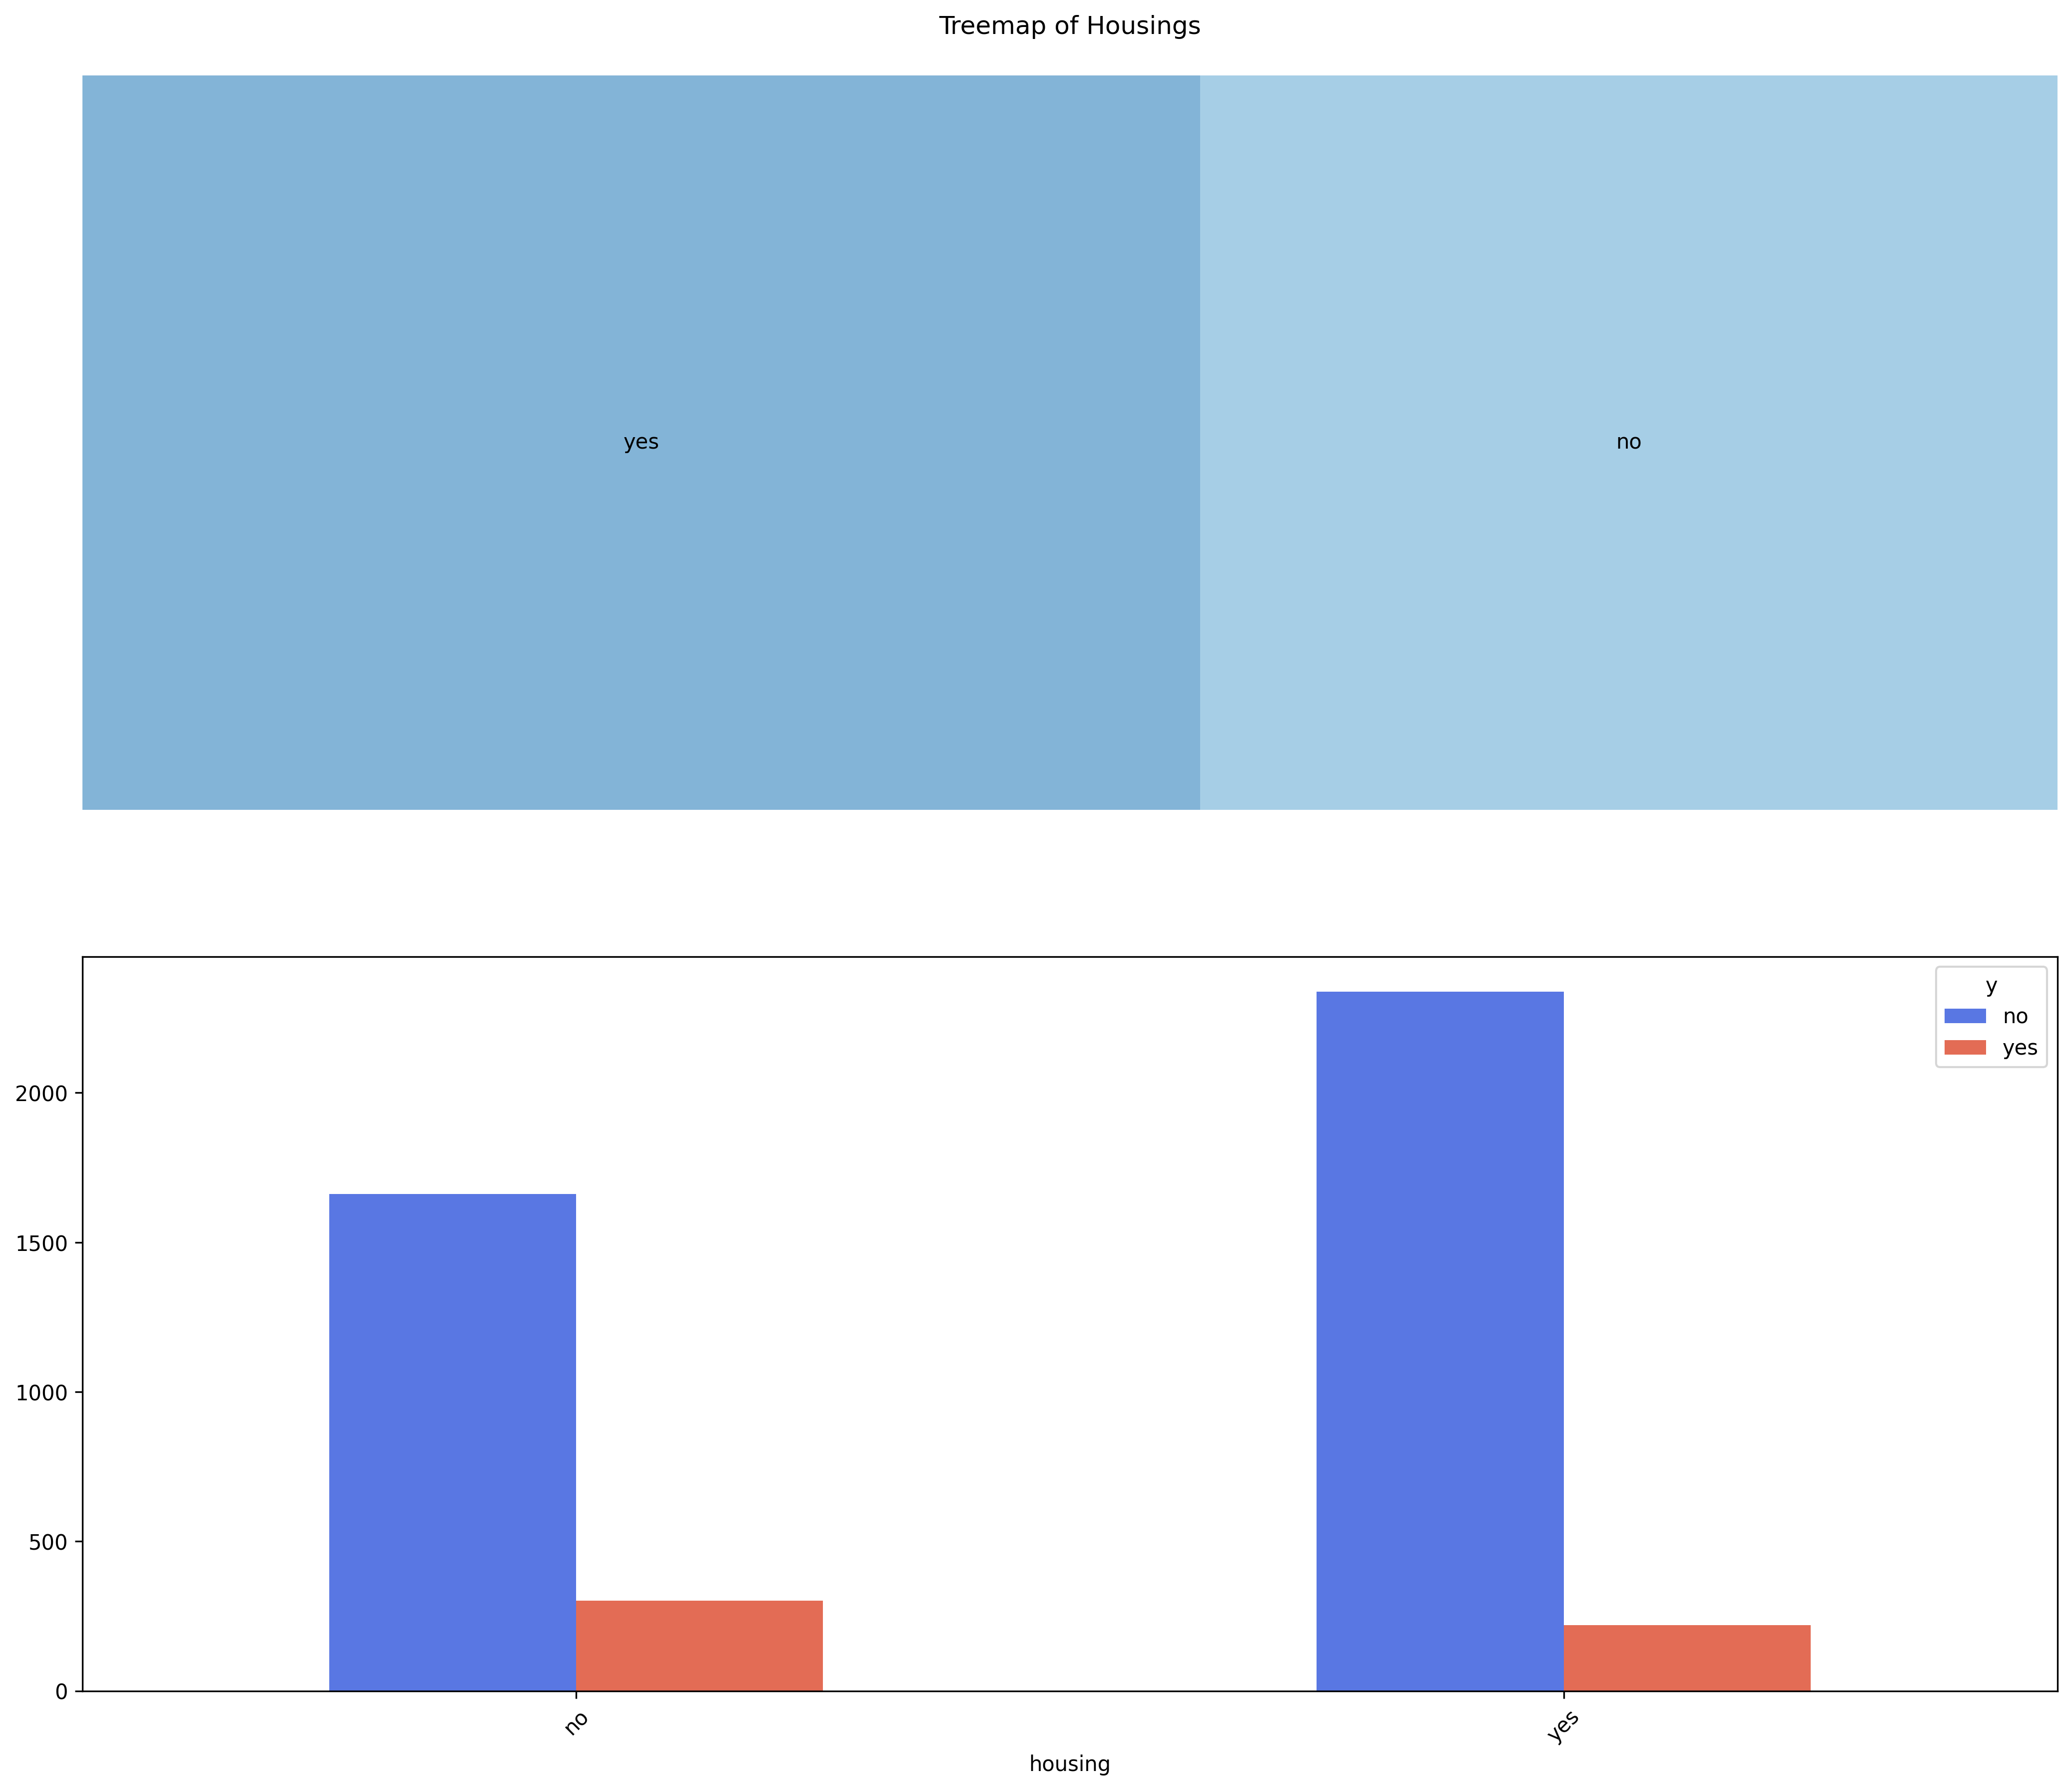

In [41]:
count_categorical_features(column='housing')
# upload_plot('distribution_housing')

In [42]:
chi2_housing, p_housing, _, _ = cat_to_target(categorical_df, 'housing')
p_housing

2.7146998959323014e-12

##### Loan

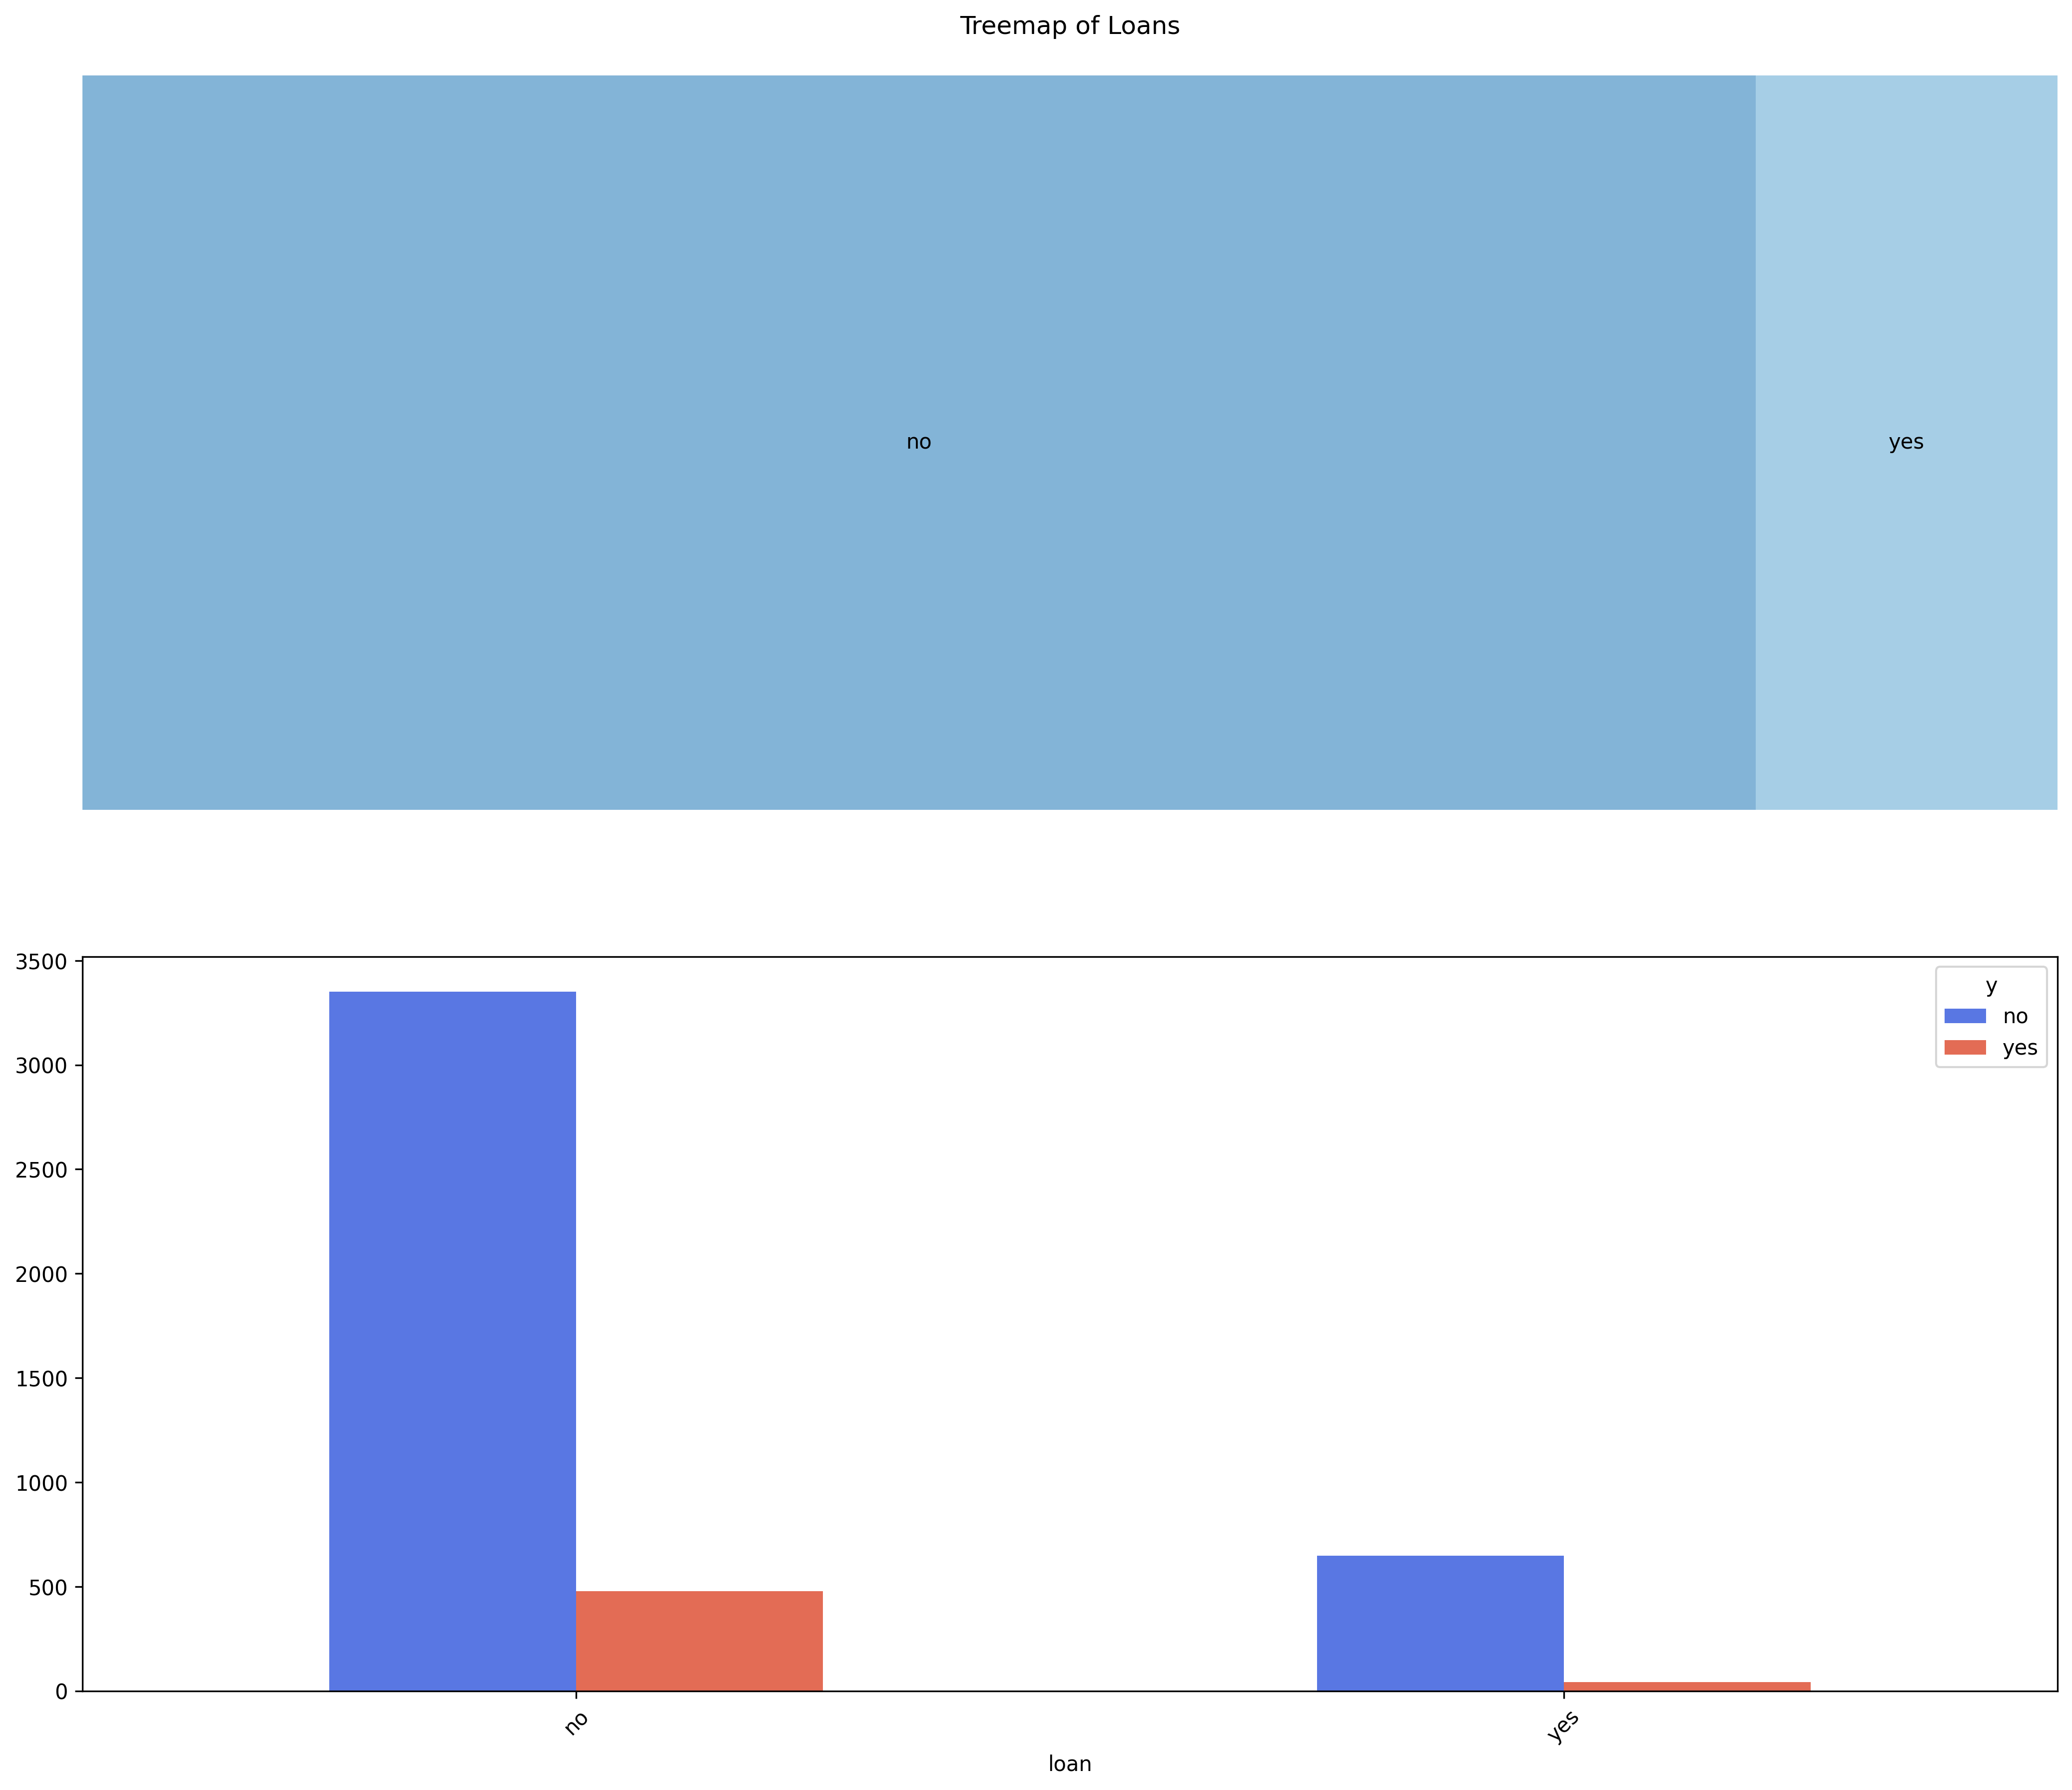

In [43]:
count_categorical_features(column='loan')
# upload_plot('distribution_loan')

In [44]:
chi2_loan, p_loan, _, _ = cat_to_target(categorical_df, 'loan')
p_loan

2.9148288298428256e-06

##### Contact

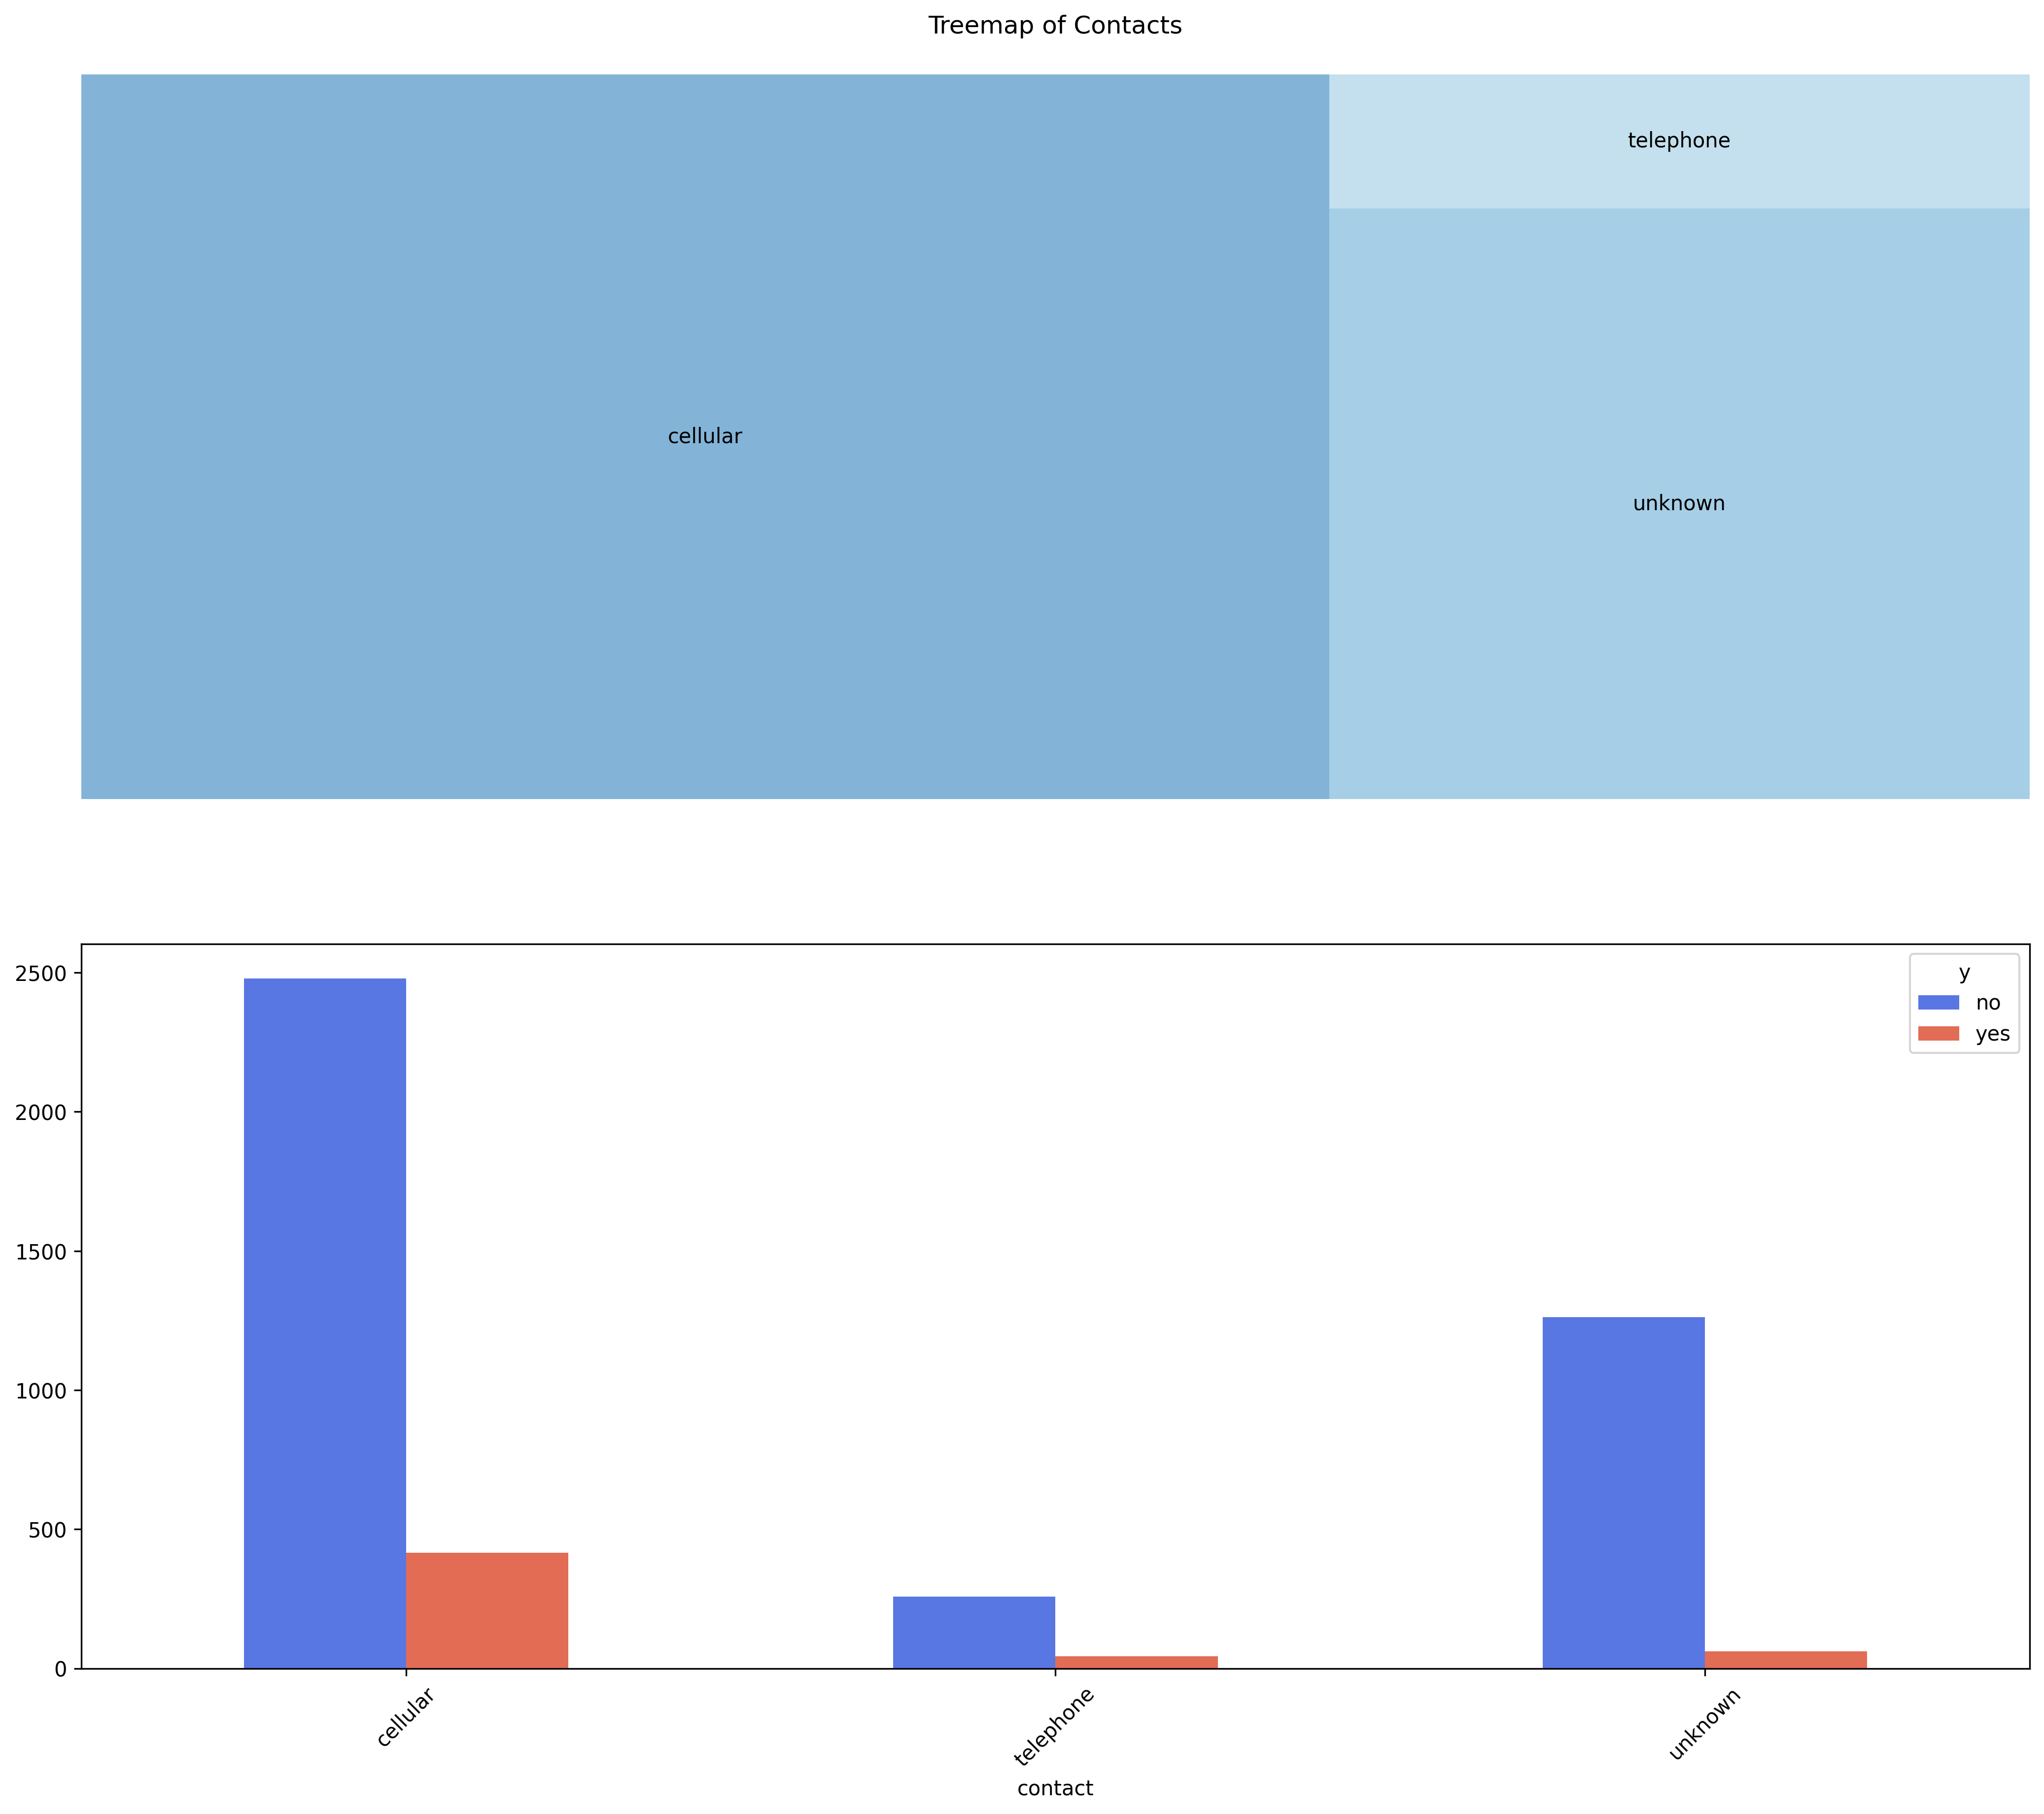

In [45]:
count_categorical_features(column='contact')
# upload_plot('distribution_contact')

In [46]:
chi2_contact, p_contact, _, _ = cat_to_target(categorical_df, 'contact')
p_contact

8.30430129641147e-20

##### Month

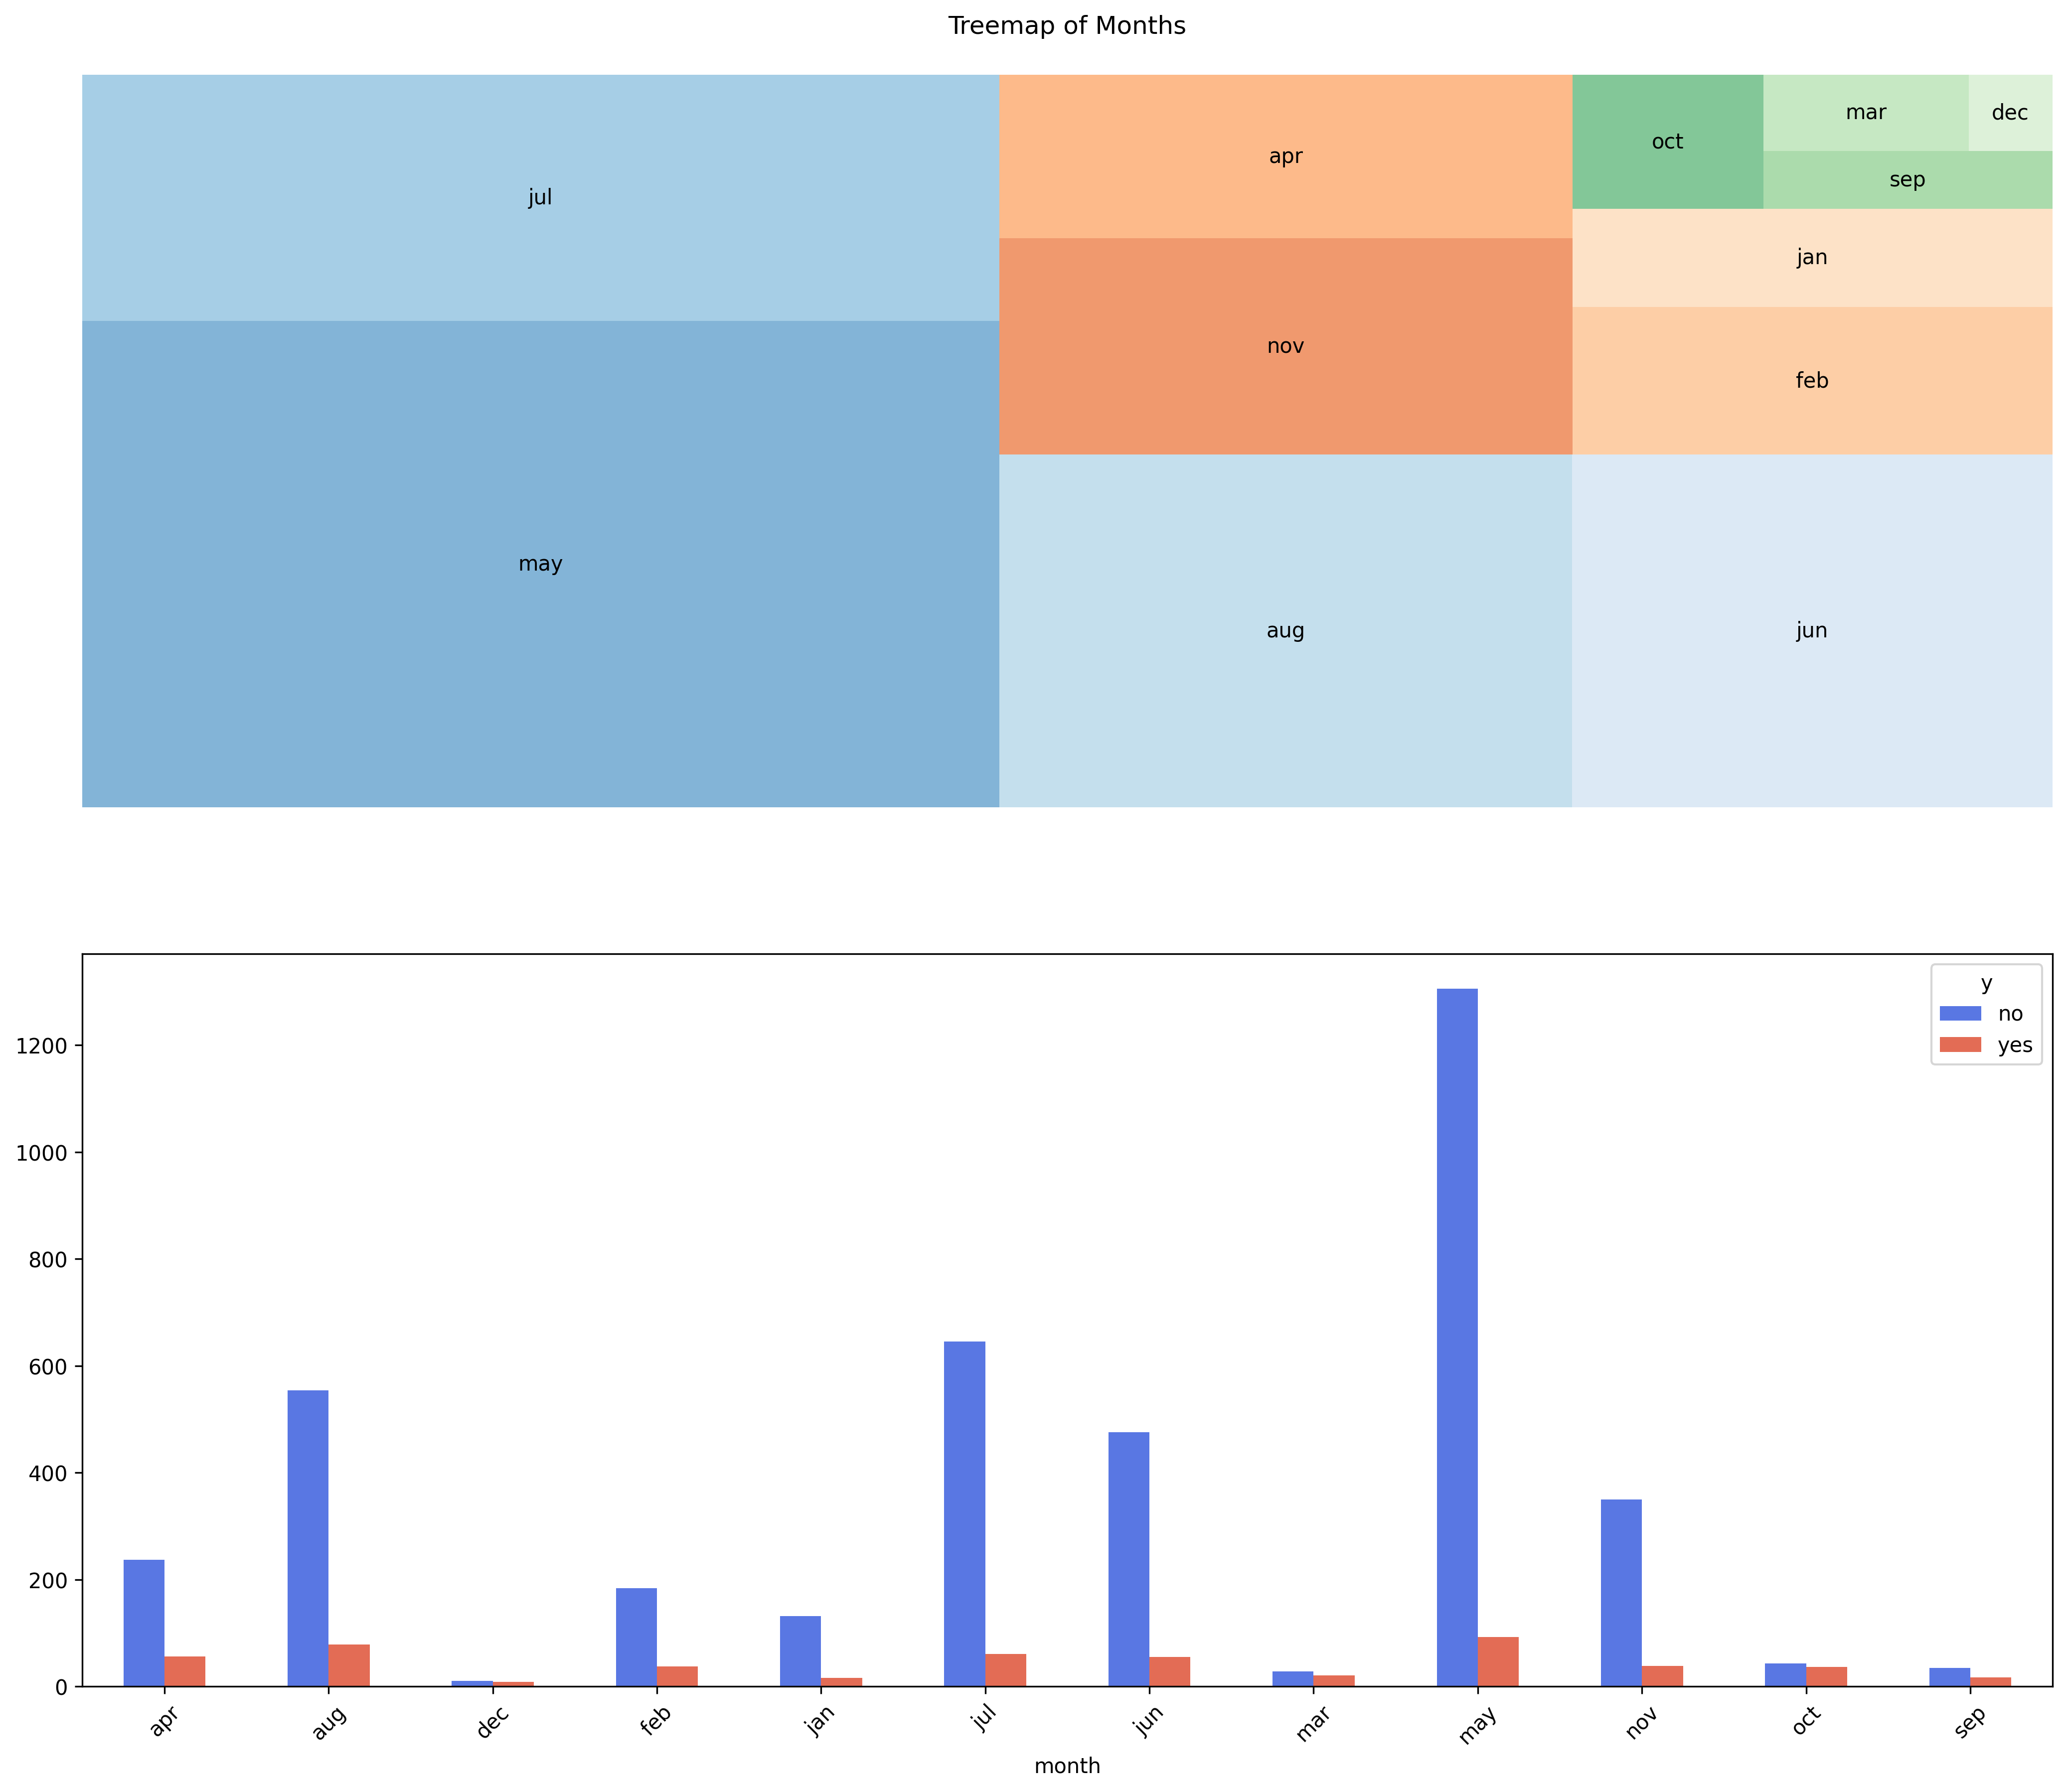

In [47]:
count_categorical_features(column='month')
# upload_plot('distribution_month')

In [48]:
chi2_month, p_month, _, _ = cat_to_target(categorical_df, 'month')
p_month

2.195354833570811e-47

##### Poutcome

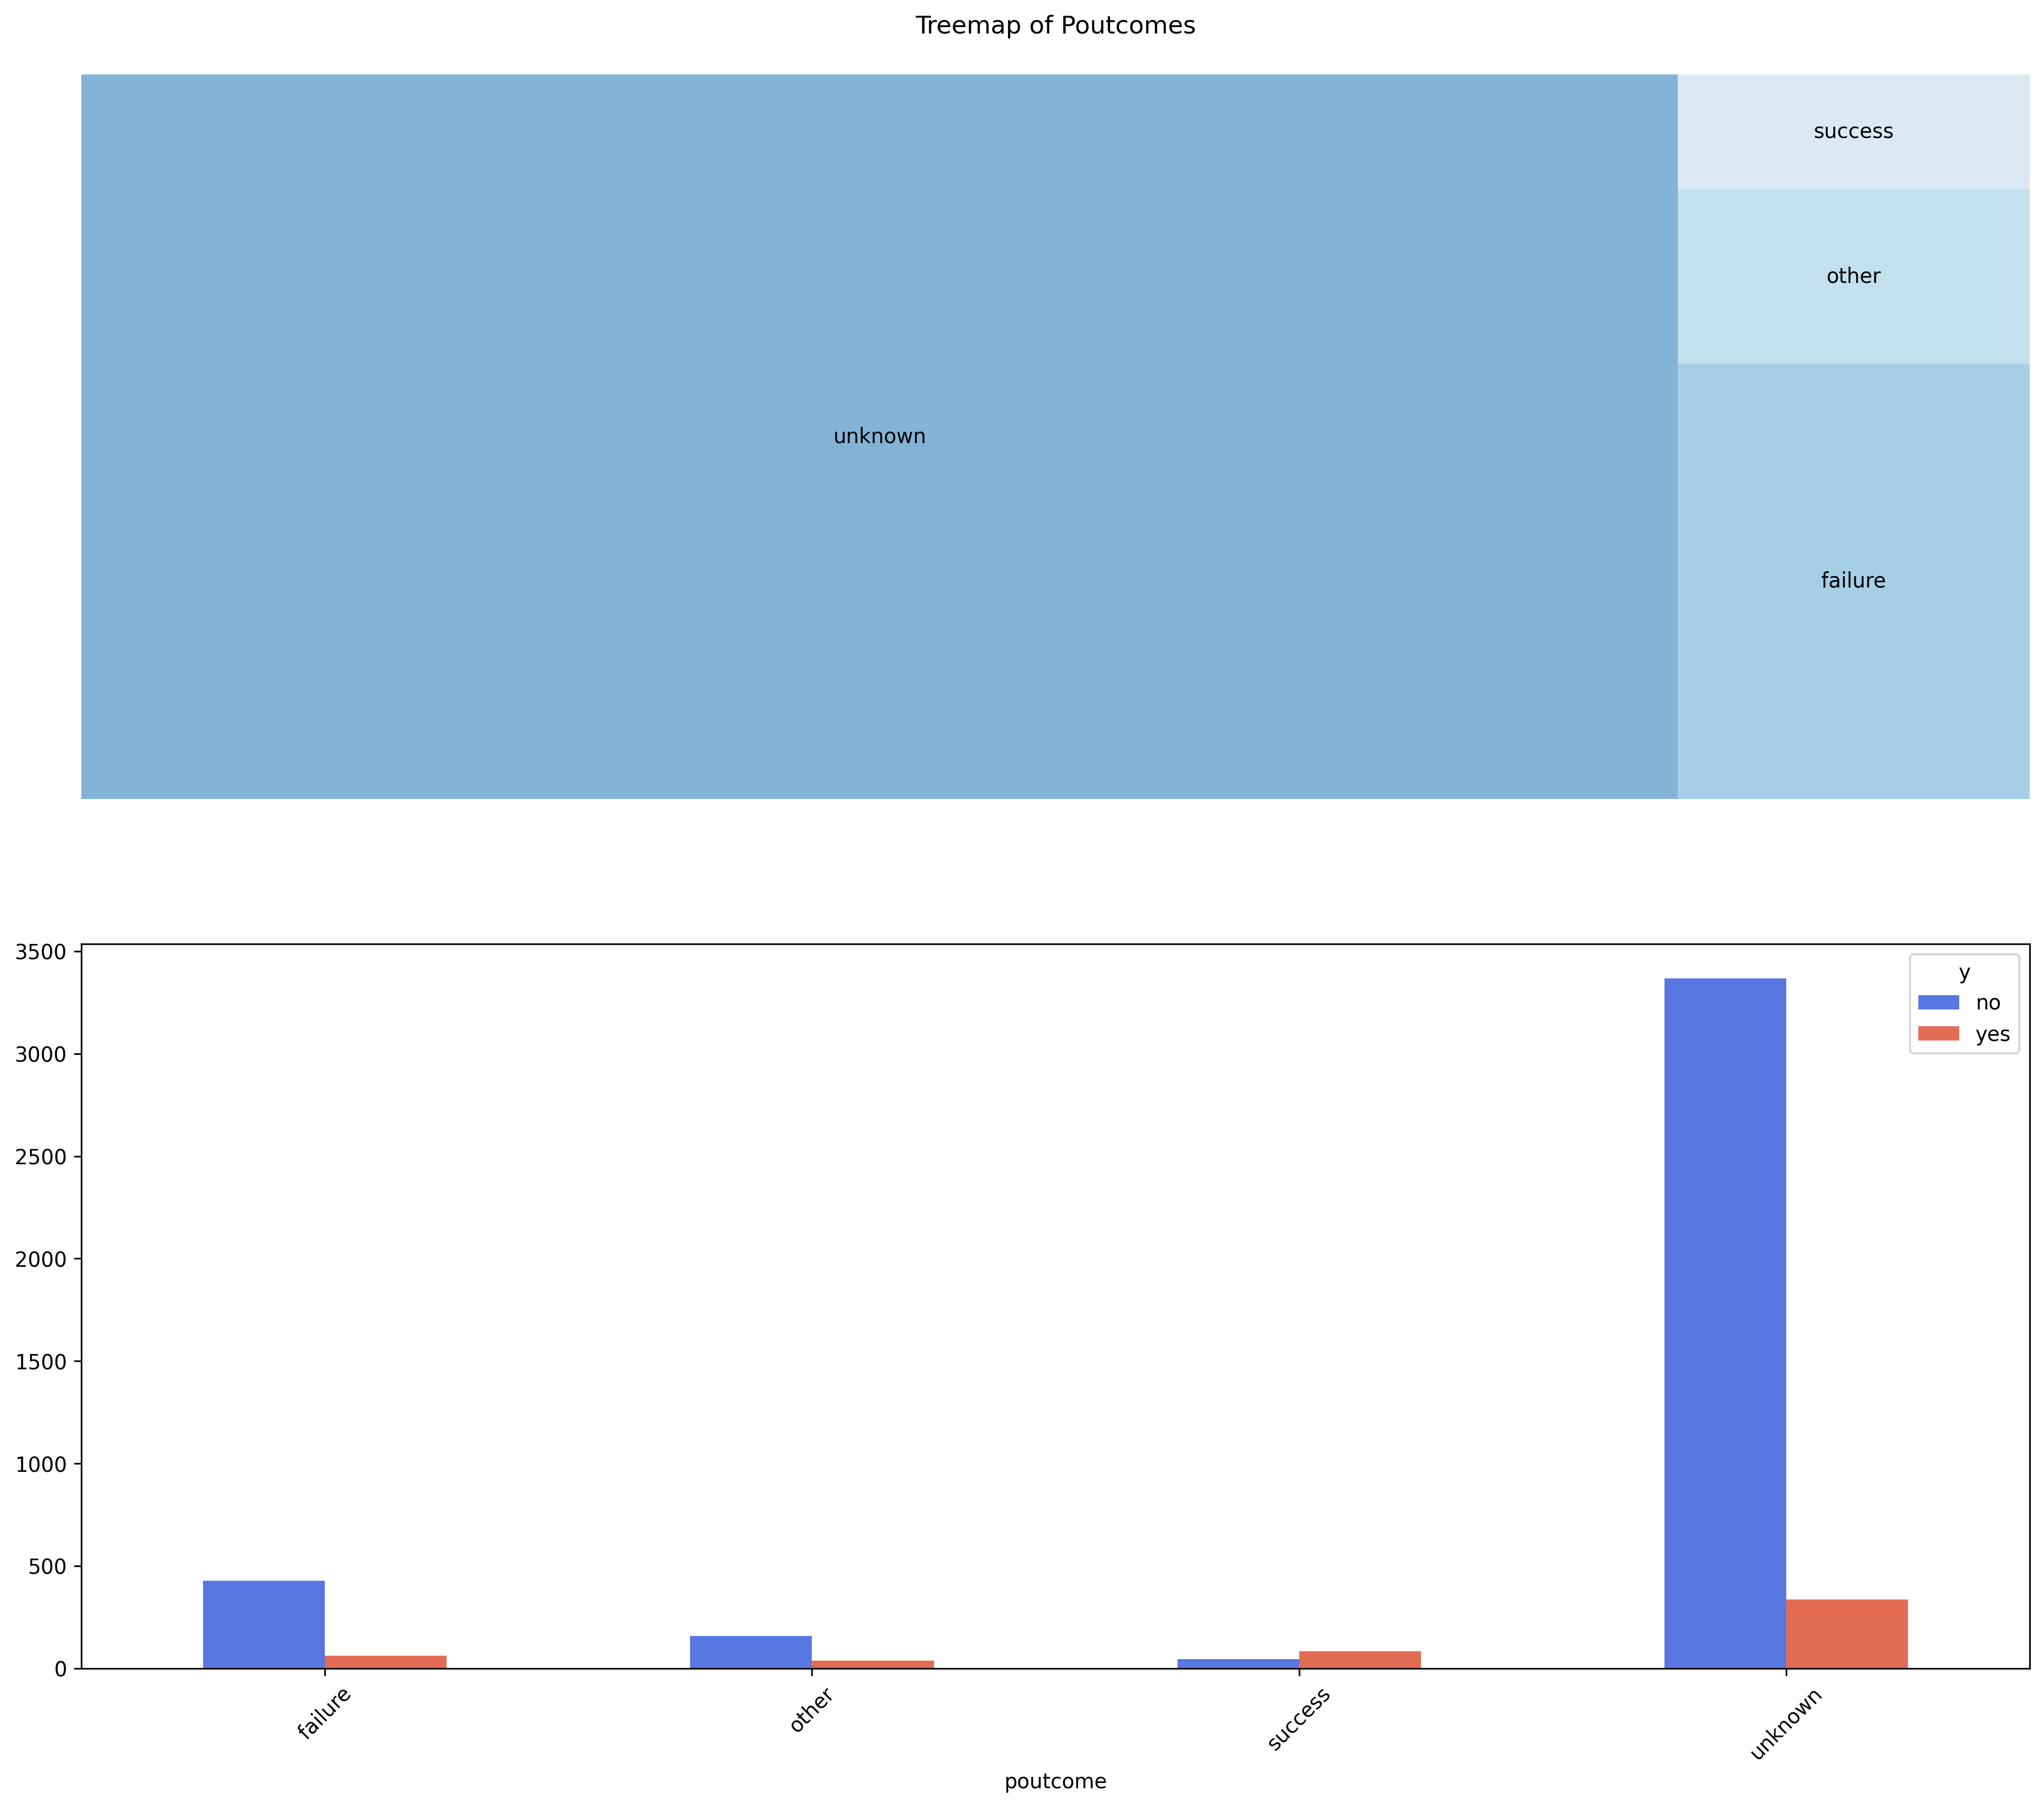

In [49]:
count_categorical_features(column='poutcome')
# upload_plot('distribution_poutcome')

In [50]:
chi2_poutcome, p_poutcome, _, _ = cat_to_target(categorical_df, 'poutcome')
p_poutcome

1.5398831095860172e-83

#### Results of Statistical Tests

In [51]:
categorical_df.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'y'],
      dtype='object')

In [52]:
p_result = pd.DataFrame({
    'category': ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact','month', 'poutcome'],
    'p_value': [p_job, p_marital, p_education, p_default, p_housing, p_loan, p_contact, p_month, p_poutcome], 
    })
p_result['is_it'] = p_result['p_value'].apply(lambda x: 1 if x < 0.05 else 0)
p_result

category       p_value  is_it
0        job  1.901391e-10      1
1    marital  7.373535e-05      1
2  education  1.625240e-03      1
3    default  1.000000e+00      0
4    housing  2.714700e-12      1
5       loan  2.914829e-06      1
6    contact  8.304301e-20      1
7      month  2.195355e-47      1
8   poutcome  1.539883e-83      1

In [ ]:
upload_csv(p_result, 'chi2_test')

After conducting the Chi2 test we see that only one categorical feature, *default*, doesn't have the influence on result, so we can get rid of it

## Modelling

### Base Model. No Feature Engineering.

#### Preparing

In [53]:
df_for_base = df.copy()

In [54]:
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(df_for_base.drop('y', axis=1), 
                                                    df_for_base['y'], 
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df_for_base['y'])


X_train_base.reset_index(drop=True, inplace=True)
X_test_base.reset_index(drop=True, inplace=True)

y_train_base = y_train_base.map({'no': 0, 'yes': 1}).reset_index(drop=True)
y_test_base = y_test_base.map({'no': 0, 'yes': 1}).reset_index(drop=True)

X_train_base_final = pd.get_dummies(
        X_train_base,
        columns=categorical_df.columns[:-1],
        drop_first=True)

X_test_base_final = pd.get_dummies(
        X_test_base,
        columns=categorical_df.columns[:-1],
        drop_first=True)

#### Fit the Models

In [55]:
base_models = {
    'Logistic Regregression': LogisticRegression(max_iter=5000,),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'SVC': SVC()
}

In [56]:
n_folds = 5
s_fold = StratifiedKFold(
    n_splits=n_folds,
    shuffle=True,
    random_state=42
)

In [57]:
base_results_train, trained_base_models = train_models(X_train_base_final, y_train_base, base_models)
base_results_test = test_models(X_test_base_final, y_test_base, trained_base_models)

In [58]:
base_results_train

accuracy    recall  f1 score  precision
Logistic Regregression  0.901274  0.323781  0.429876   0.645604
Random Forest           0.902104  0.292742  0.403817   0.671377
XGBoost                 0.900167  0.398164  0.479020   0.602640
SVC                     0.884403  0.000000  0.000000   0.000000

In [59]:
base_results_test

accuracy    recall  f1 score  precision
Logistic Regregression  0.887293  0.240385  0.328947   0.520833
Random Forest           0.885083  0.201923  0.287671   0.500000
XGBoost                 0.889503  0.336538  0.411765   0.530303
SVC                     0.885083  0.000000  0.000000   0.000000

In [ ]:
upload_csv(base_results_train, csv_name='base_results_train', index=True)
upload_csv(base_results_test, csv_name='base_results_test', index=True)

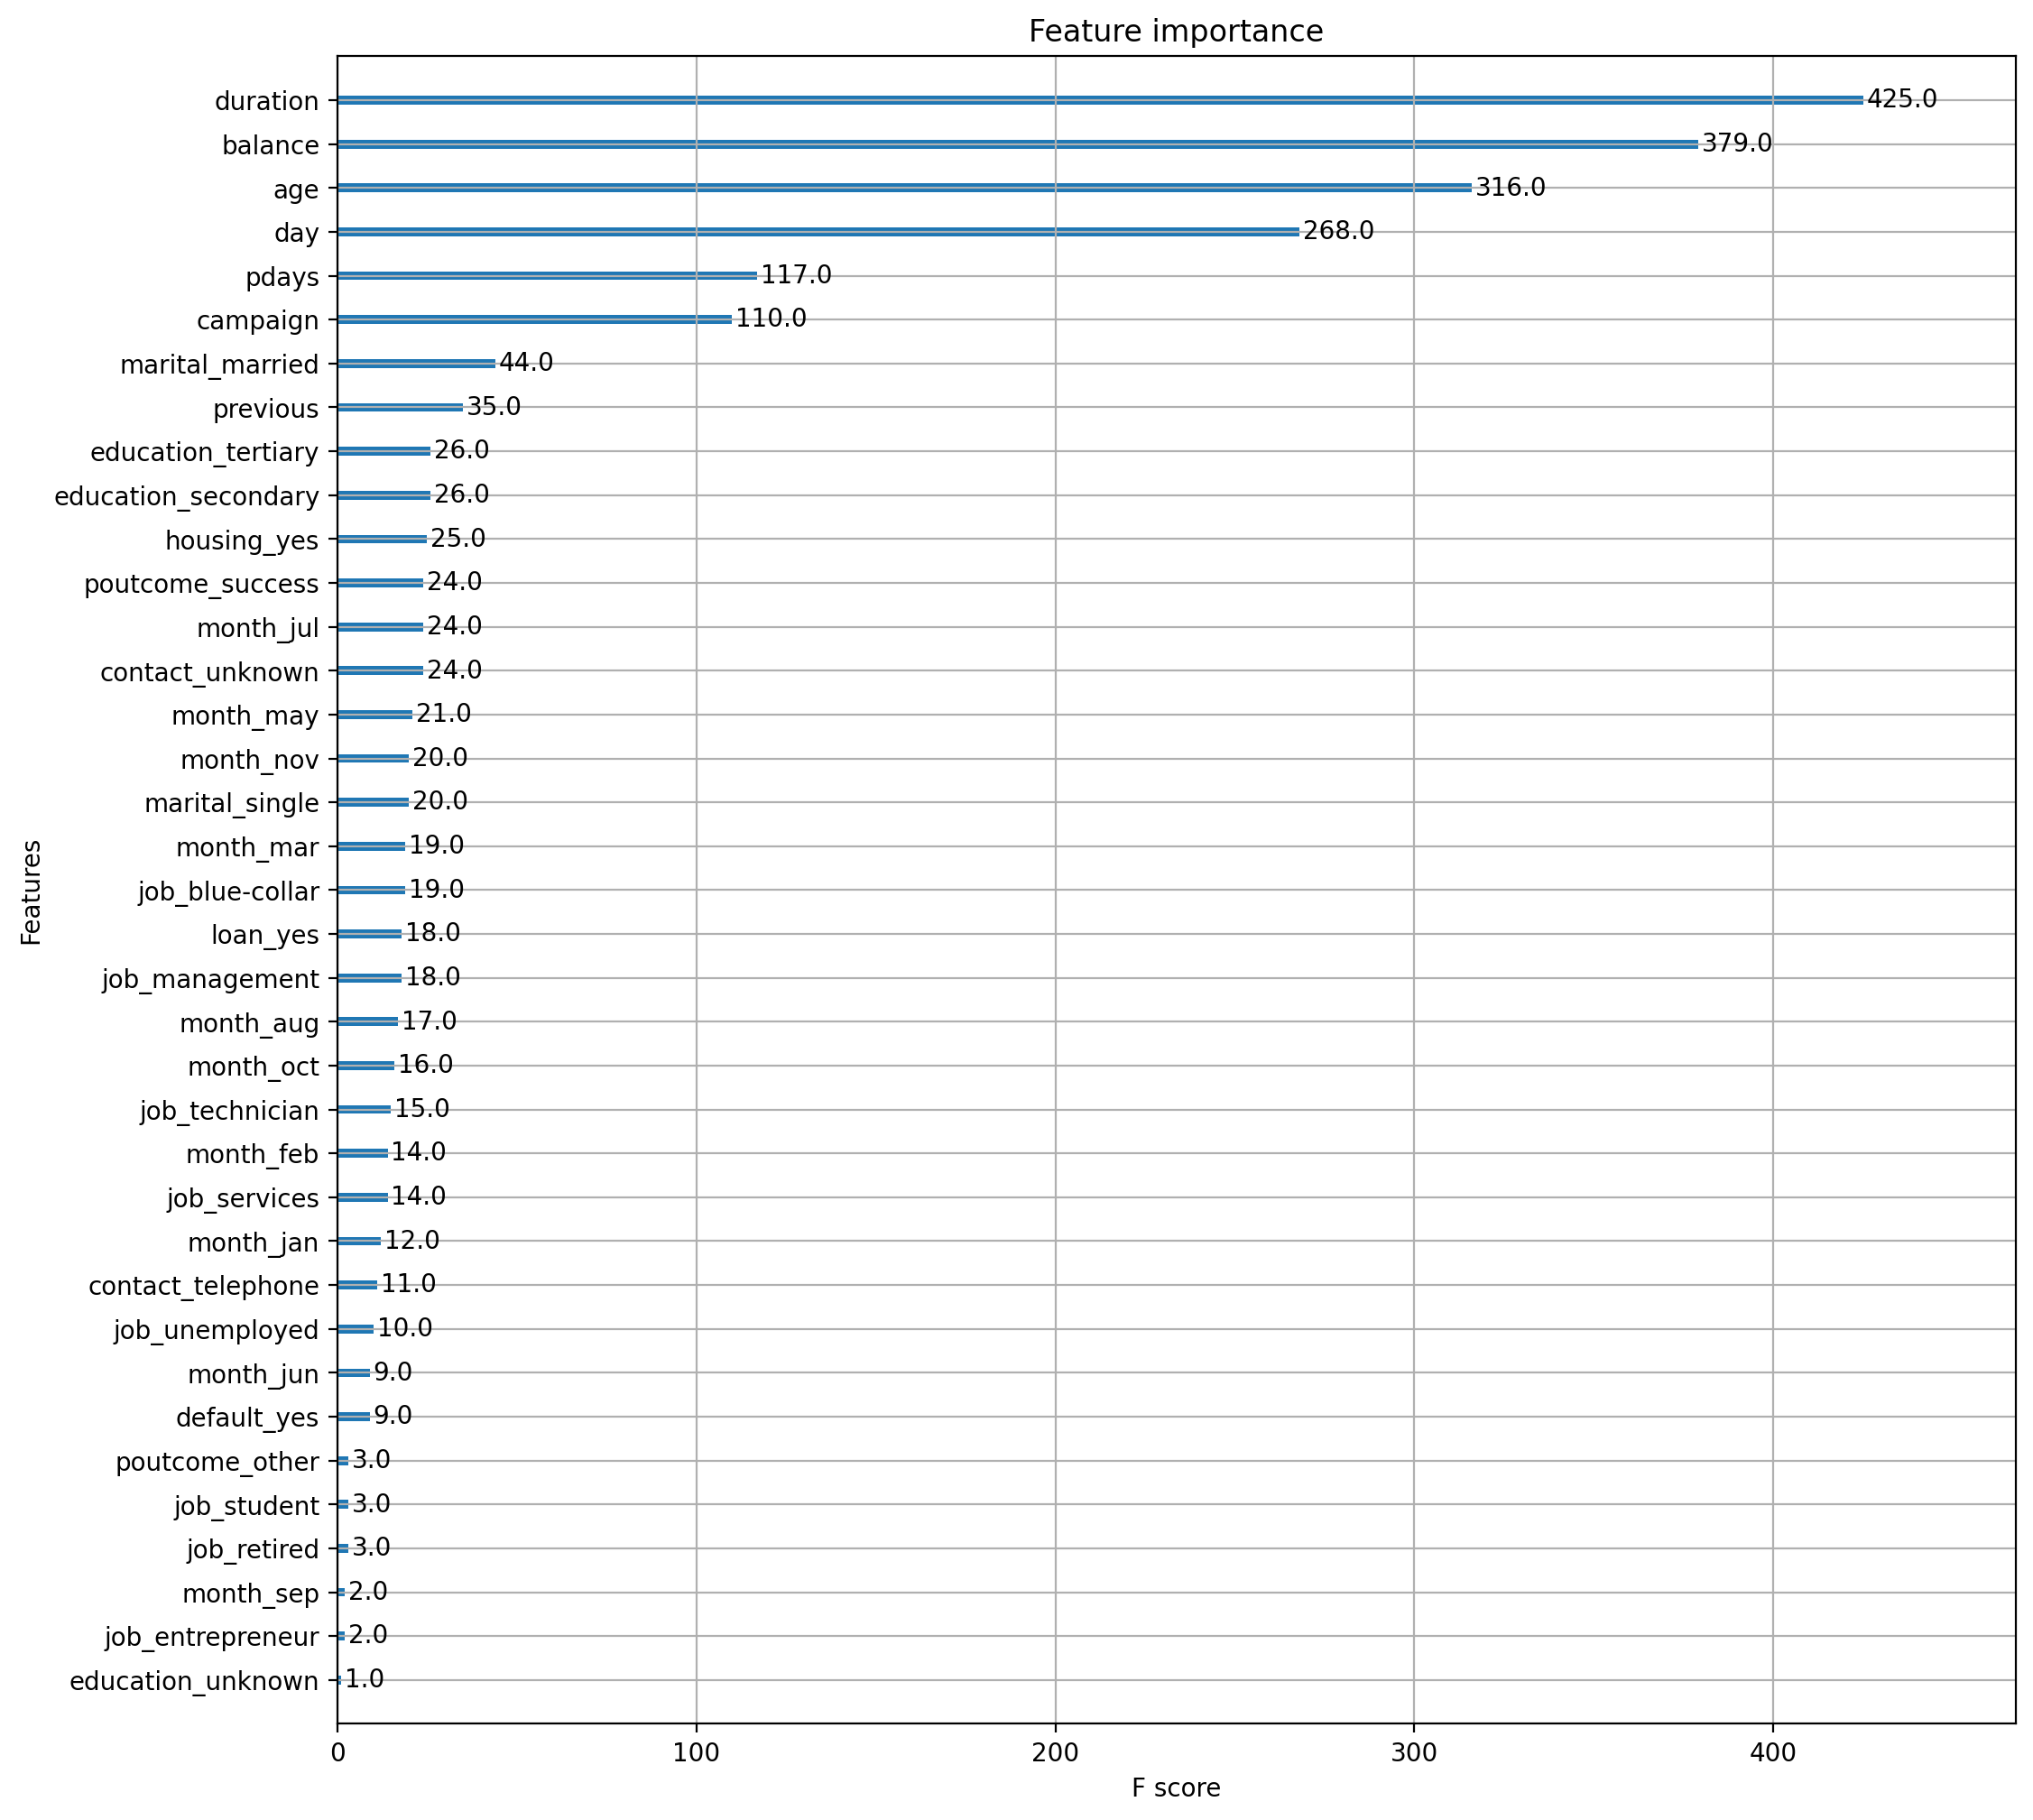

In [60]:
fig, ax = plt.subplots(figsize=(12, 12), dpi=200)
plot_importance(trained_base_models['XGBoost'], ax=ax);
# upload_plot('base_feature_importance')

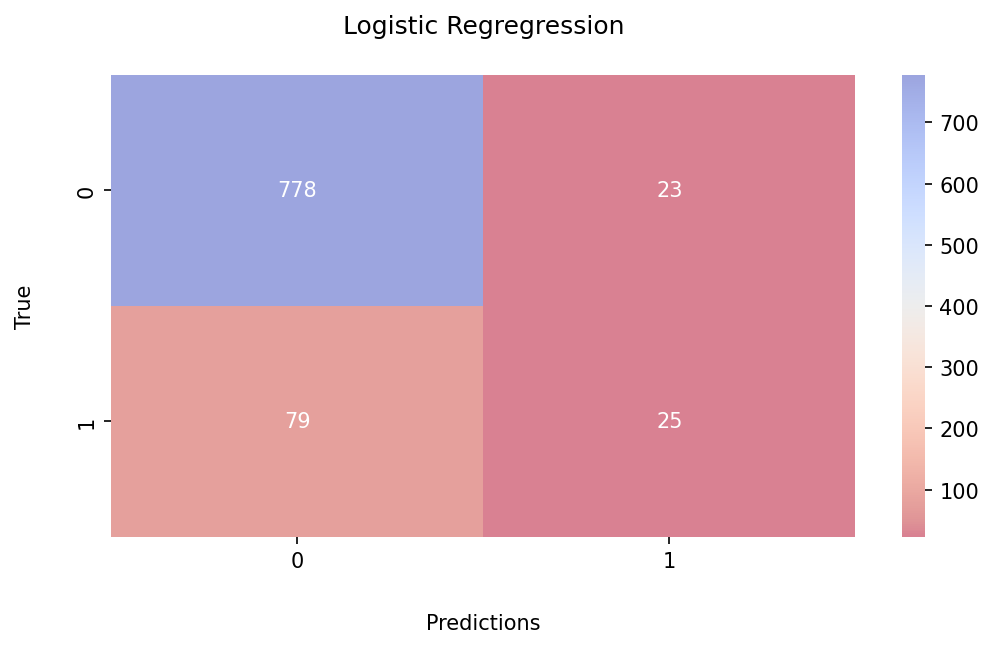

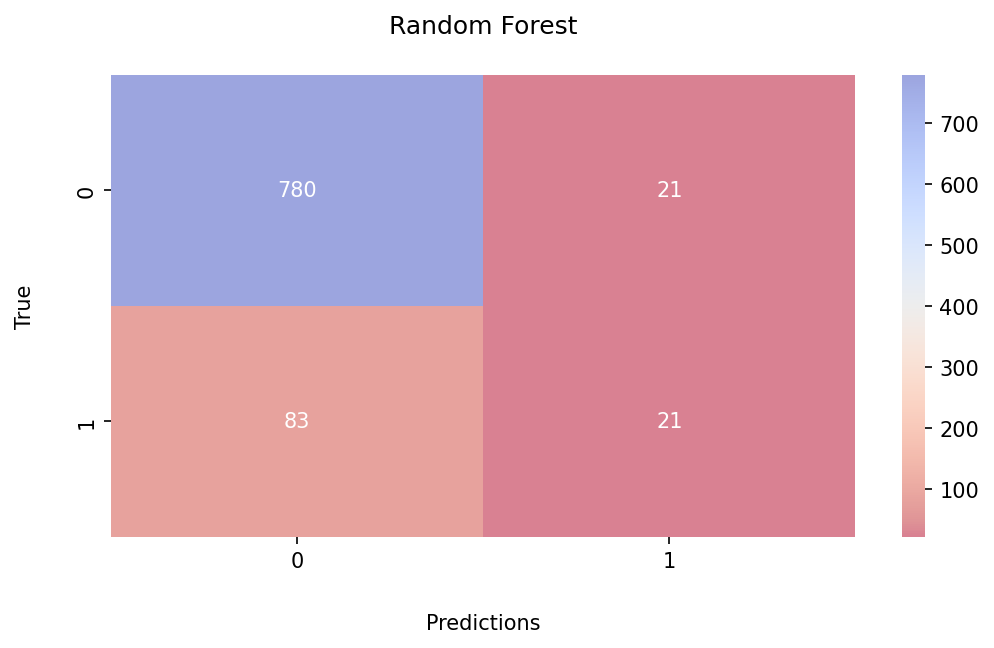

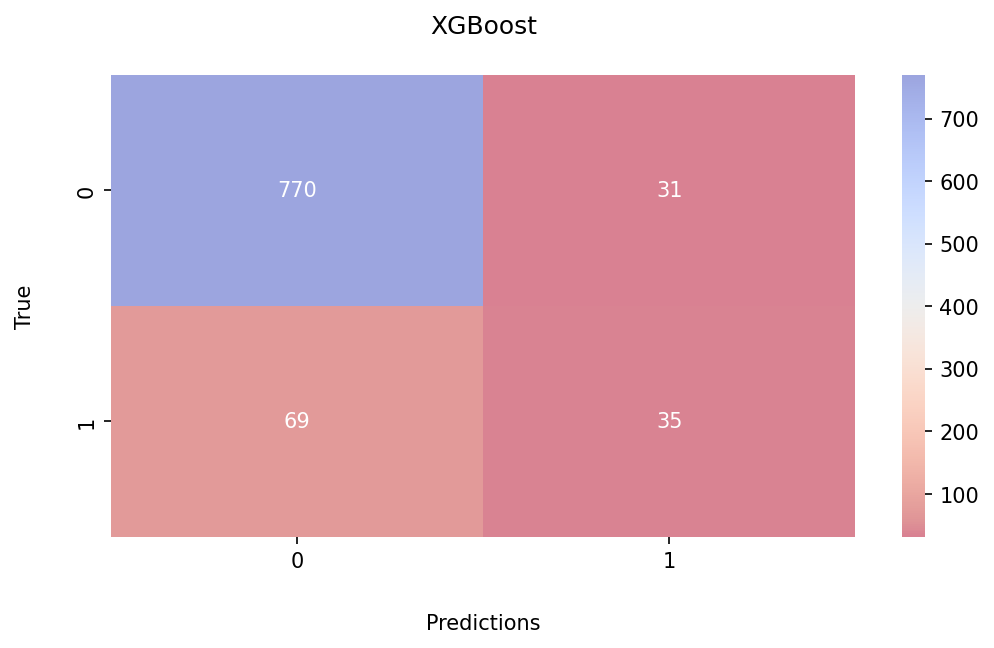

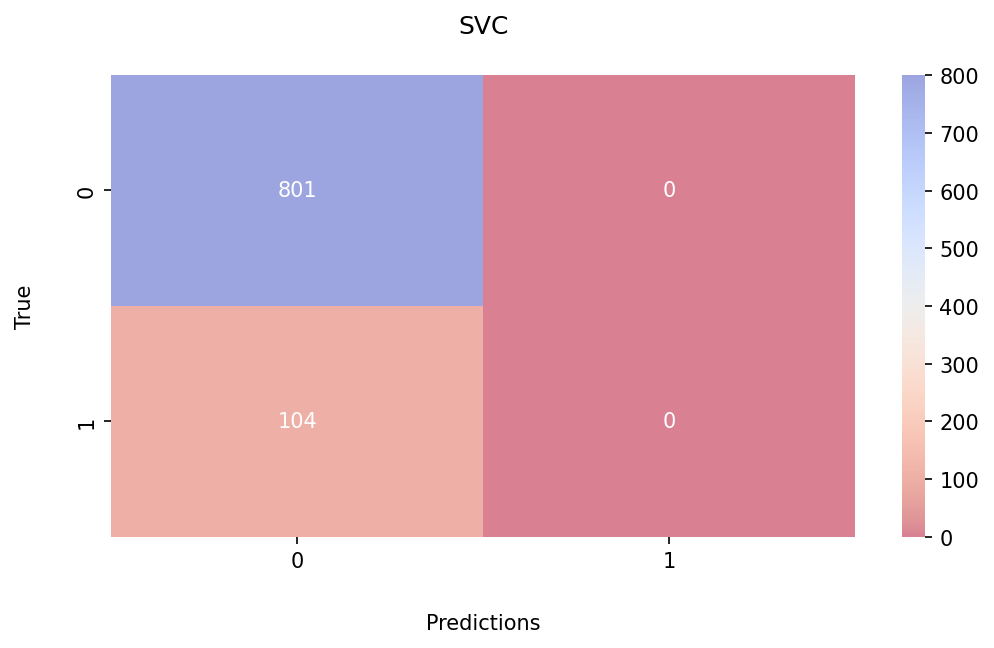

In [62]:
confusion_matrix_plot(X_test_base_final, y_test_base, trained_base_models, upload=0)

### Top Features

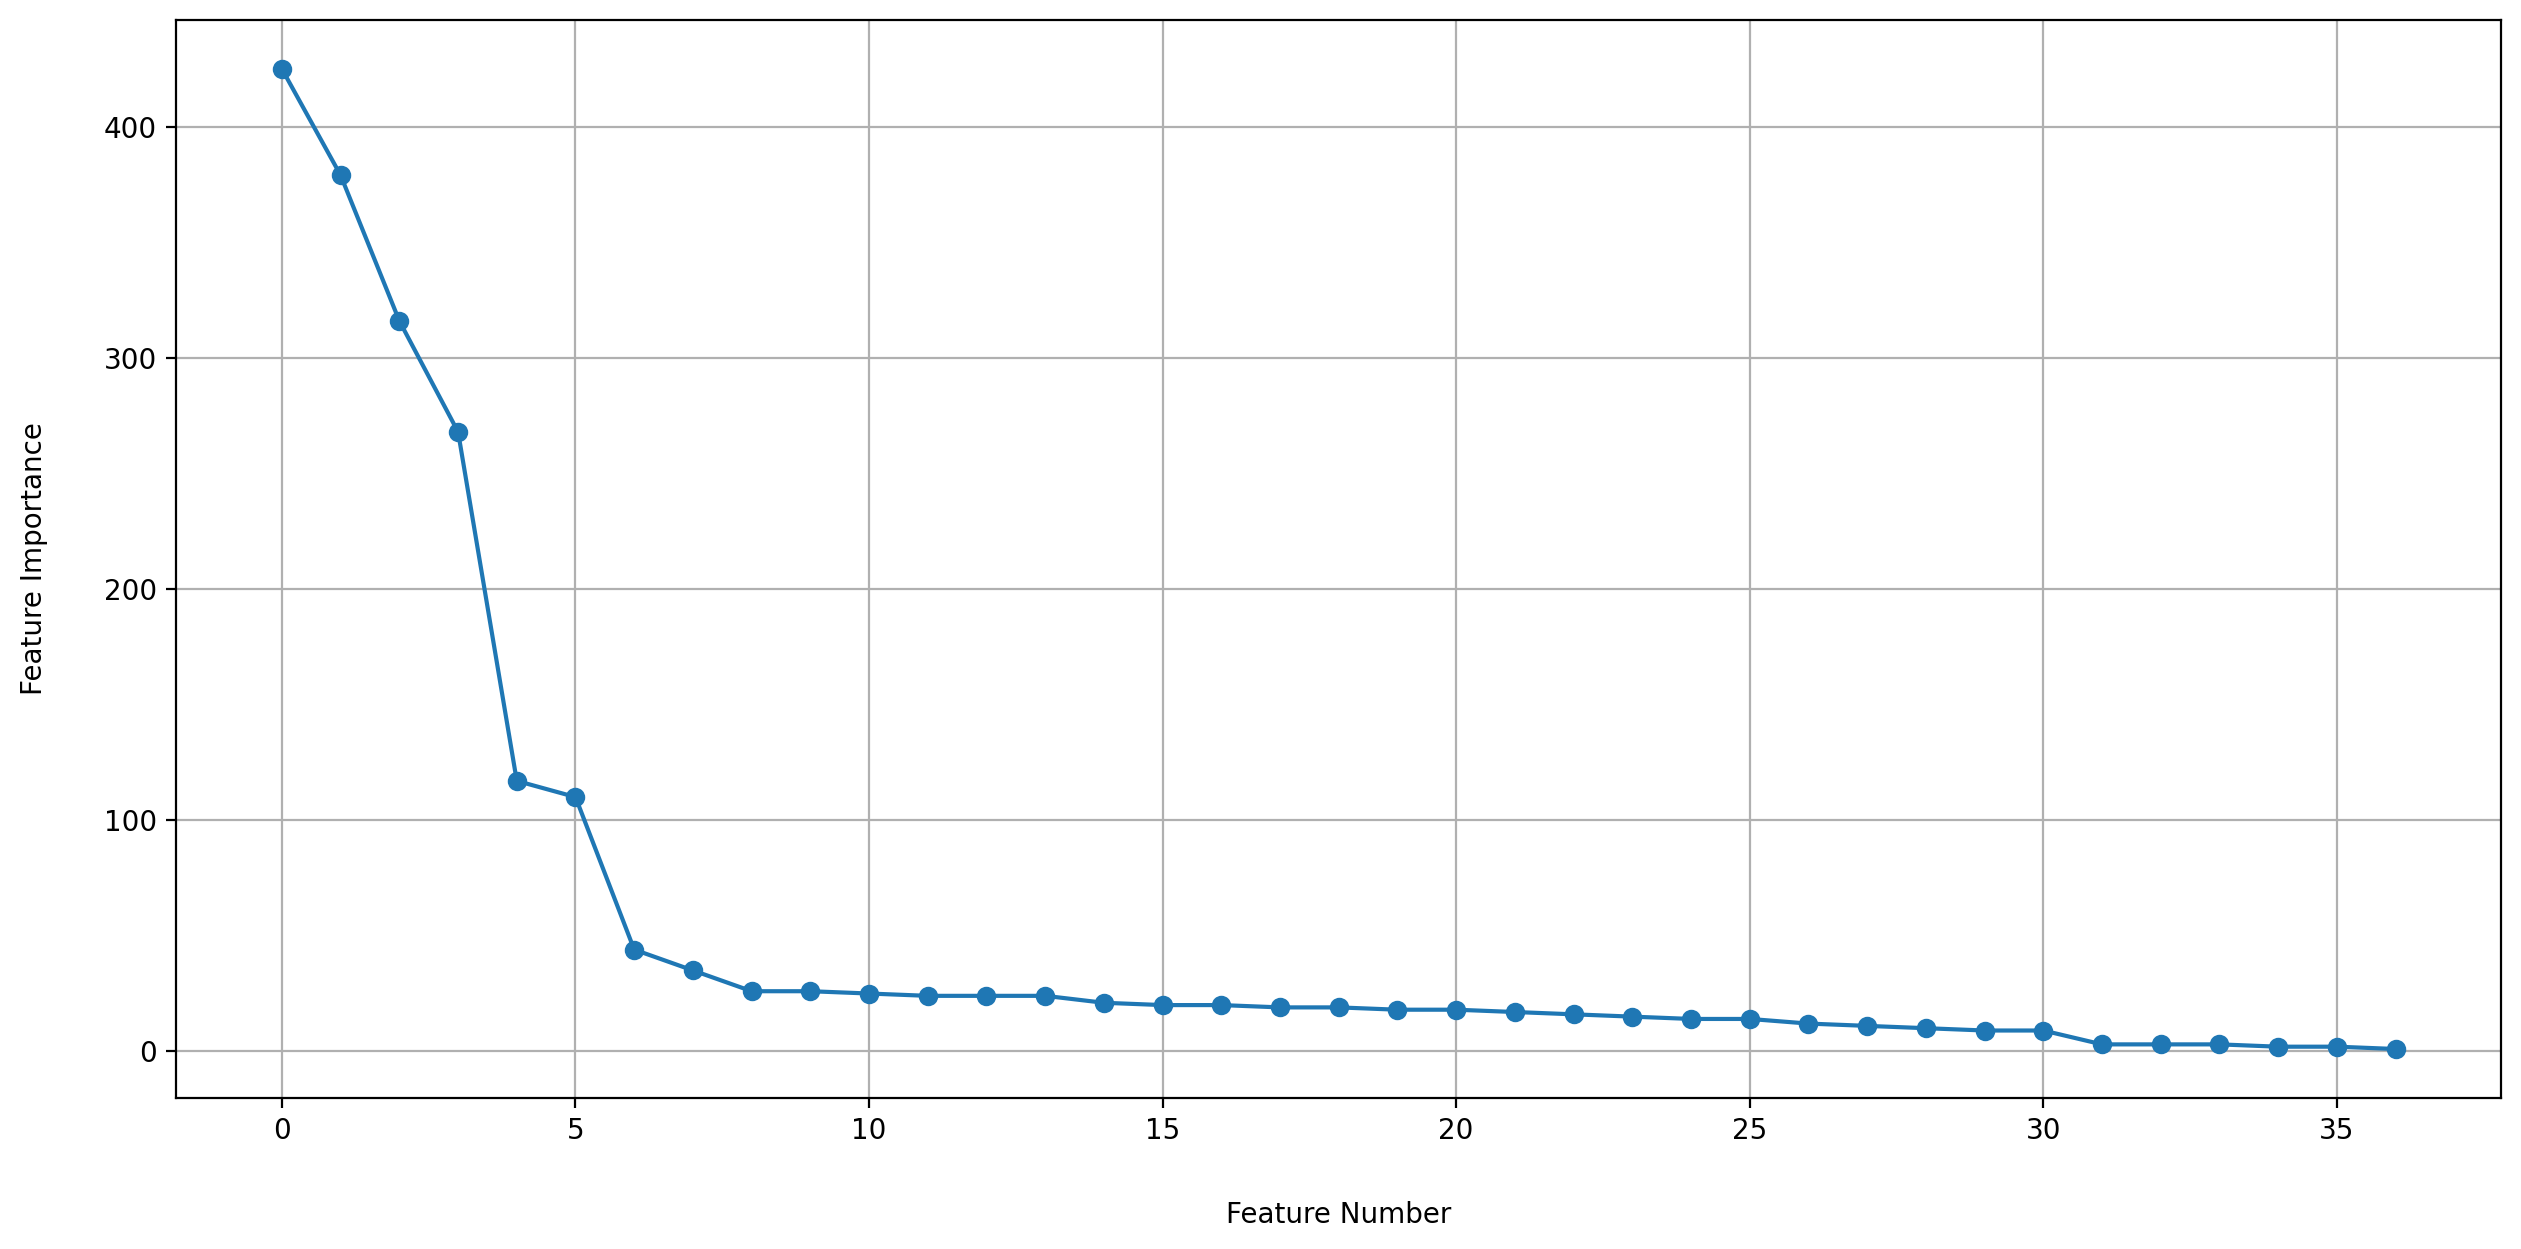

In [63]:
feature_importance = trained_base_models['XGBoost'].get_booster().get_score(importance_type='weight')

sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

fig = plt.figure(figsize=(15, 7), dpi=200)
x = np.arange(len(sorted_importance))
y = [elem[1] for elem in sorted_importance]
plt.plot(x, y, marker='o');
plt.xlabel('Feature Number', labelpad=20)
plt.ylabel('Feature Importance', labelpad=20)
plt.grid(True)
# upload_plot('base_feature_importance_1')

In [64]:
num_features = 20
top_features = [pair[0] for pair in sorted_importance][:num_features]

In [65]:
base_models_top_features = {
    'Logistic Regregression': LogisticRegression(max_iter=5000,),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
}

In [66]:
base_results_top_features_train, trained_base_models_top_features = train_models(
    X_train_base_final[top_features], 
    y_train_base, 
    base_models_top_features
    )
base_results_top_features_test = test_models(X_test_base_final[top_features], y_test_base, trained_base_models_top_features)

In [67]:
base_results_top_features_train

accuracy    recall  f1 score  precision
Logistic Regregression  0.901273  0.314200  0.423275   0.651060
Random Forest           0.902379  0.316523  0.426454   0.661843
XGBoost                 0.893811  0.395869  0.461253   0.557328

In [68]:
base_results_top_features_test

accuracy    recall  f1 score  precision
Logistic Regregression  0.895028  0.298077  0.394904   0.584906
Random Forest           0.880663  0.221154  0.298701   0.460000
XGBoost                 0.891713  0.365385  0.436782   0.542857

In [ ]:
upload_csv(base_results_top_features_train, 'base_results_top_features_train', index=True)
upload_csv(base_results_top_features_test, 'base_results_top_features_test', index=True)

### Grid Search

In [69]:
base_models_grid = {
    'Logistic Regregression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
}

param_grid = {
    'Logistic Regregression': {
        'solver': ['liblinear', 'lbfgs'],
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'max_iter': [5_000]
    },

    'Random Forest': {
        'n_estimators': [10, 50, 100, 500],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 4, 6]
    },

    'XGBoost': {
        'max_depth': [5, 6],
        'learning_rate': [0.001, 0.01],
        'n_estimators': [300, 1000, 2000],
        'subsample': [0.7, 0.85, 1]
        }
}
best_params = {}
for name, model in base_models_grid.items():

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid[name], scoring='precision', cv=3)
    grid_search.fit(X_train_base_final[top_features], y_train_base)
    best_params[name] = grid_search.best_params_
    print(f'For model {name} the best params: {grid_search.best_params_} \n\n')

For model Logistic Regregression the best params: {'C': 1, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'lbfgs'} 


For model Random Forest the best params: {'max_depth': 10, 'min_samples_split': 6, 'n_estimators': 50} 


For model XGBoost the best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7} 




In [71]:
base_best_params = pd.DataFrame(best_params).fillna('-')
base_best_params
# upload_csv(base_best_params, 'base_best_params', index=True)

Logistic Regregression Random Forest XGBoost
C                                      1             -       -
max_iter                            5000             -       -
penalty                               l2             -       -
solver                             lbfgs             -       -
max_depth                              -          10.0     5.0
min_samples_split                      -           6.0       -
n_estimators                           -          50.0   300.0
learning_rate                          -             -    0.01
subsample                              -             -     0.7

In [72]:
base_models_best = {
    'Logistic Regregression': LogisticRegression(**best_params['Logistic Regregression']),
    'Random Forest': RandomForestClassifier(**best_params['Random Forest']),
    'XGBoost': XGBClassifier(**best_params['XGBoost']),
}

base_models_best_results_train, trained_base_models_best = train_models(
    X_train_base_final[top_features], 
    y_train_base, 
    base_models_best
    )

base_models_best_results_test = test_models(X_test_base_final[top_features], y_test_base, base_models_best)

In [73]:
base_models_best_results_train

accuracy    recall  f1 score  precision
Logistic Regregression  0.901273  0.314200  0.423275   0.651060
Random Forest           0.899063  0.275875  0.386387   0.646345
XGBoost                 0.900445  0.330895  0.433481   0.629686

In [74]:
base_models_best_results_test

accuracy    recall  f1 score  precision
Logistic Regregression  0.895028  0.298077  0.394904   0.584906
Random Forest           0.885083  0.230769  0.315789   0.500000
XGBoost                 0.895028  0.355769  0.437870   0.569231

In [ ]:
upload_csv(base_models_best_results_train, 'base_models_best_results_train', index=True)
upload_csv(base_models_best_results_test, 'base_models_best_results_test', index=True)

# Feature Engineering

In [75]:
numerical_df_engineered = numerical_df.copy()
numerical_df_engineered.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

In [76]:
df_engineered = df.copy()

### Age

In [79]:
summary_numerical(df_engineered, 'age', 0.55, 1, 0)

TypeError: summary_numerical() got multiple values for argument 'upload'

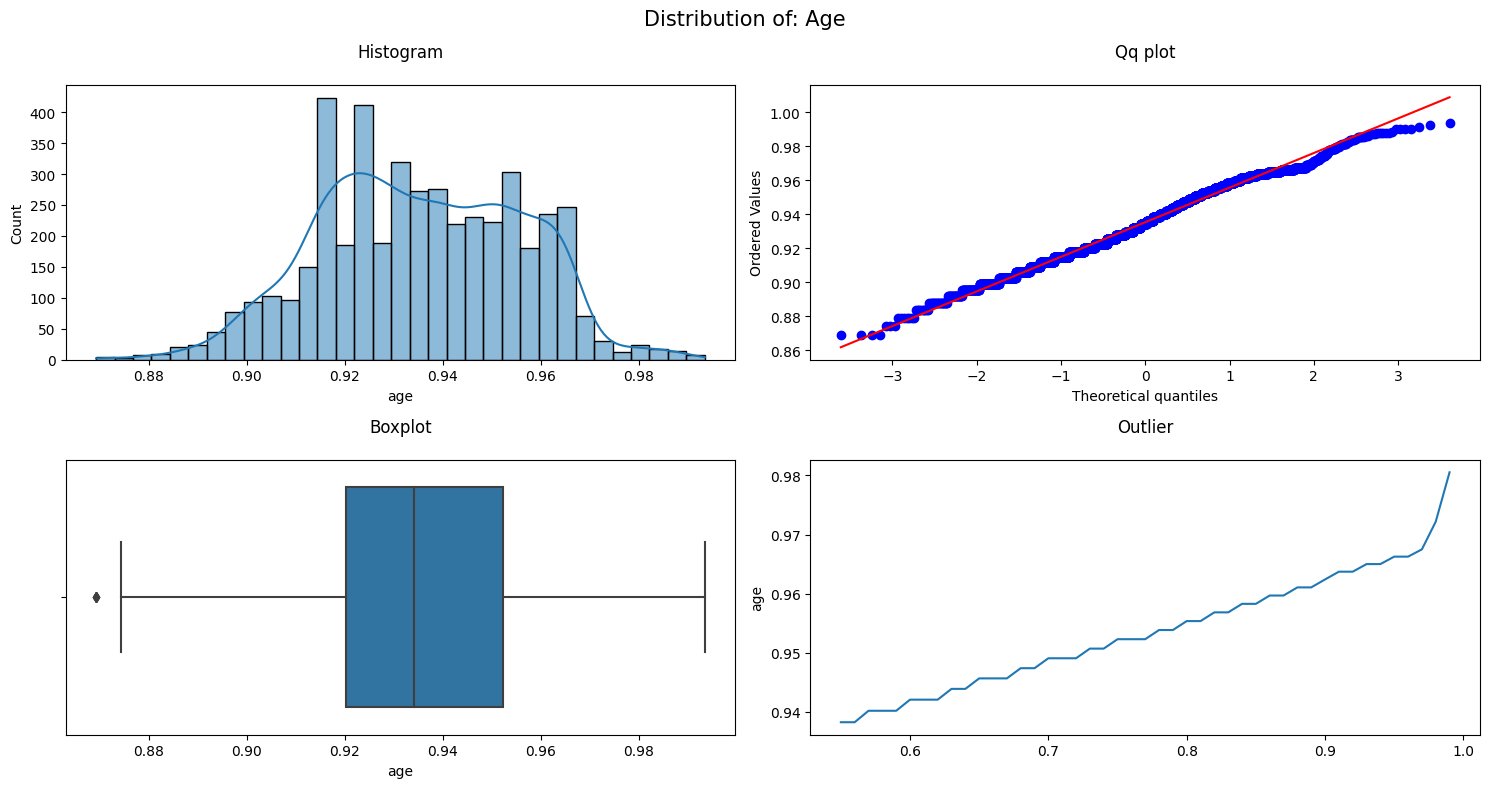

In [81]:
df_engineered['age'] = np.log1p(df_engineered['age'])
summary_numerical(df_engineered, 'age', 0.55, 1, upload=0, engineered=1)

### Balance

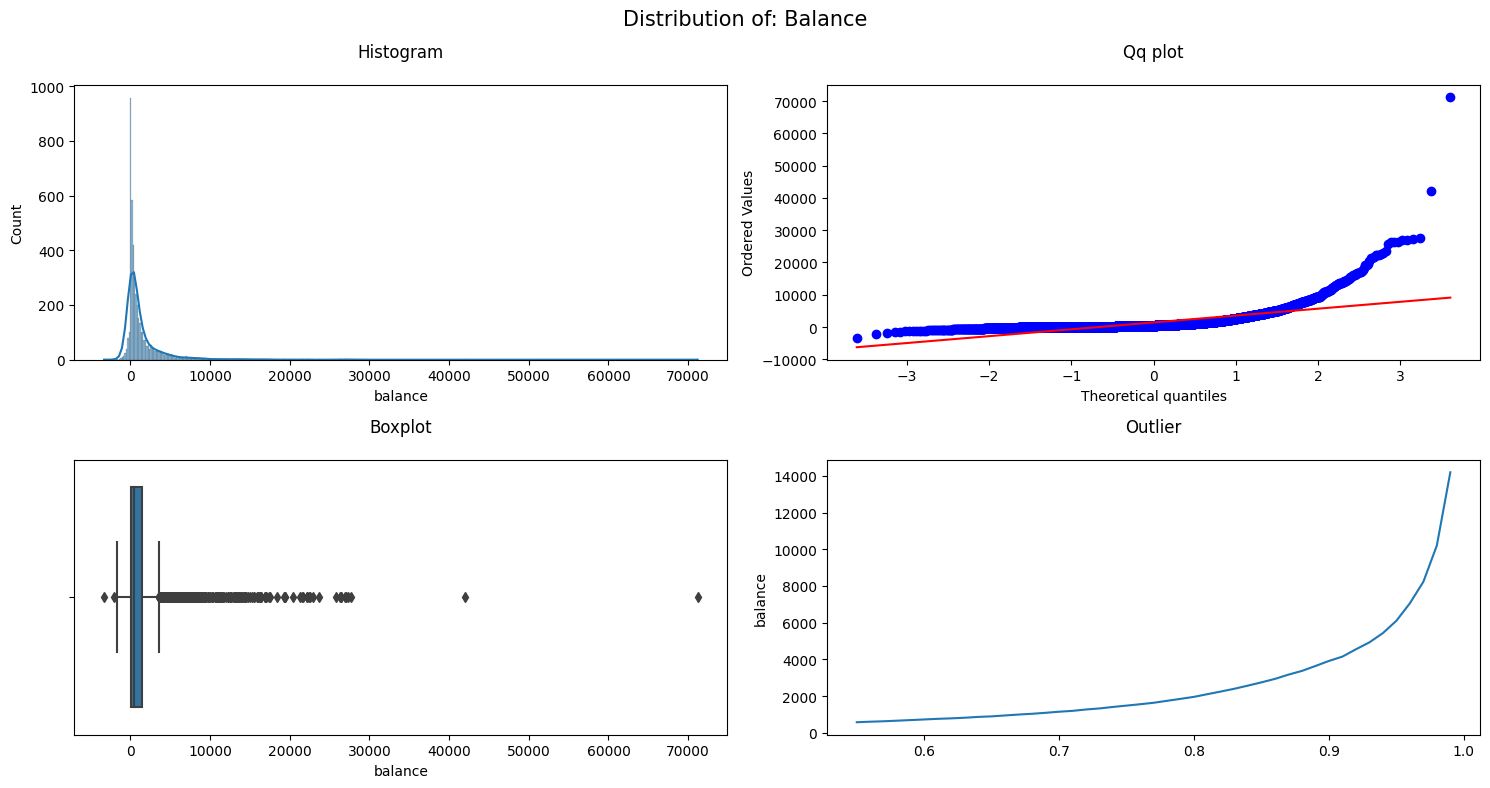

In [82]:
summary_numerical(df_engineered, 'balance', 0.55, 1, 0)

In [83]:
df_engineered = df_engineered[df_engineered['balance'] < 30_000]

In [84]:
# %%writefile /Users/konstantinsokolovskiy/Desktop/My_Big_Project/final/projects/projects/project_3/data/code_snippets/balance_engineered.txt
min_balance = abs(df_engineered['balance'].min())
df_engineered = df_engineered[df_engineered['balance'] != -min_balance]
df_engineered['balance'] = df_engineered['balance'] + min_balance + 1
df_engineered['balance'] = np.log1p(df_engineered['balance'])

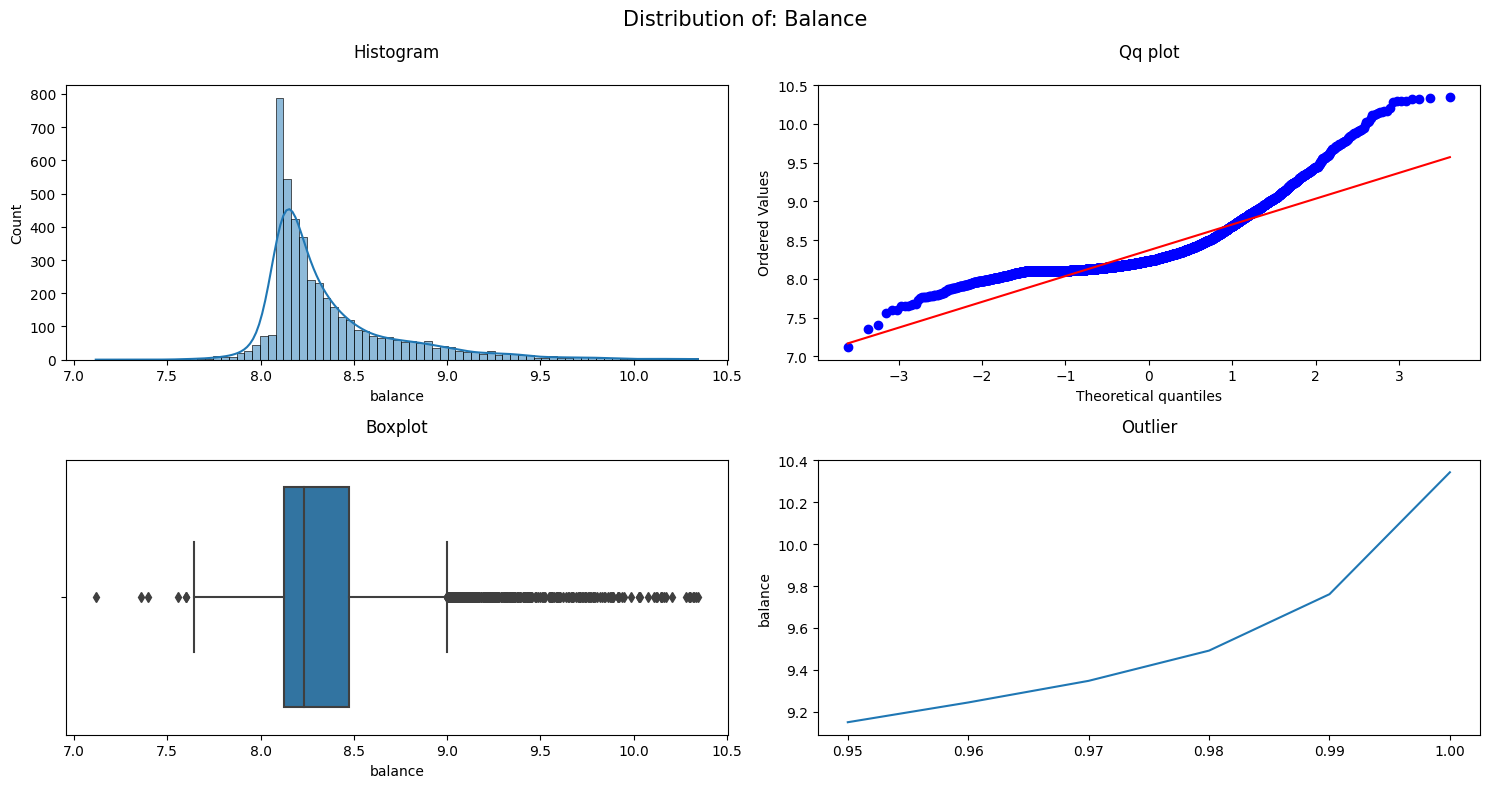

In [85]:
summary_numerical(df_engineered, 'balance', 0.95, 1, upload=0, engineered=1)

### Duration

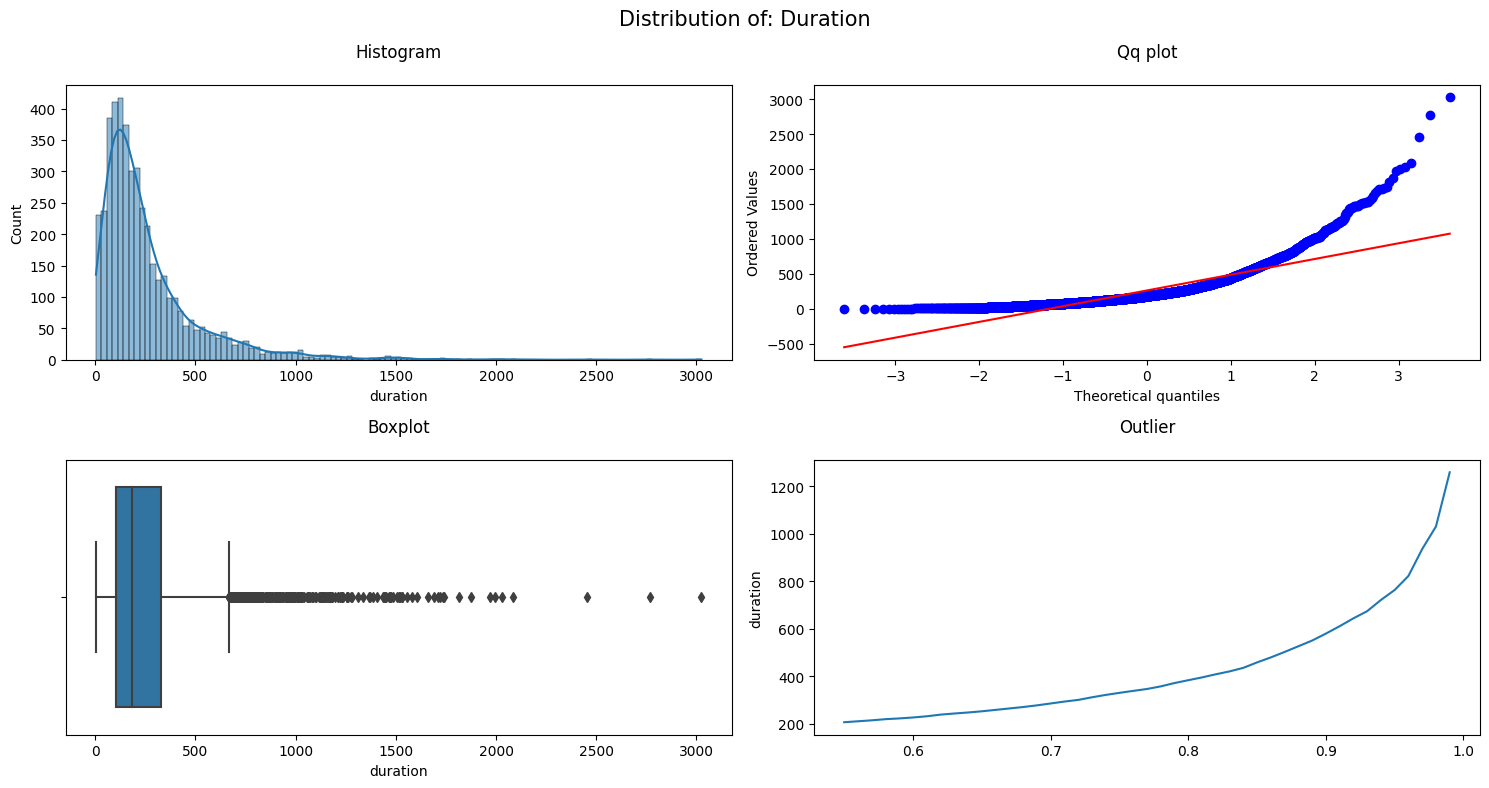

In [86]:
summary_numerical(df_engineered, 'duration', 0.55, 1, 0)

In [87]:
df_engineered[df_engineered['duration'] > 2_000]['y'].value_counts()

yes    4
no     1
Name: y, dtype: int64

In [88]:
df_engineered = df_engineered[df_engineered['duration'] <= 2_000]

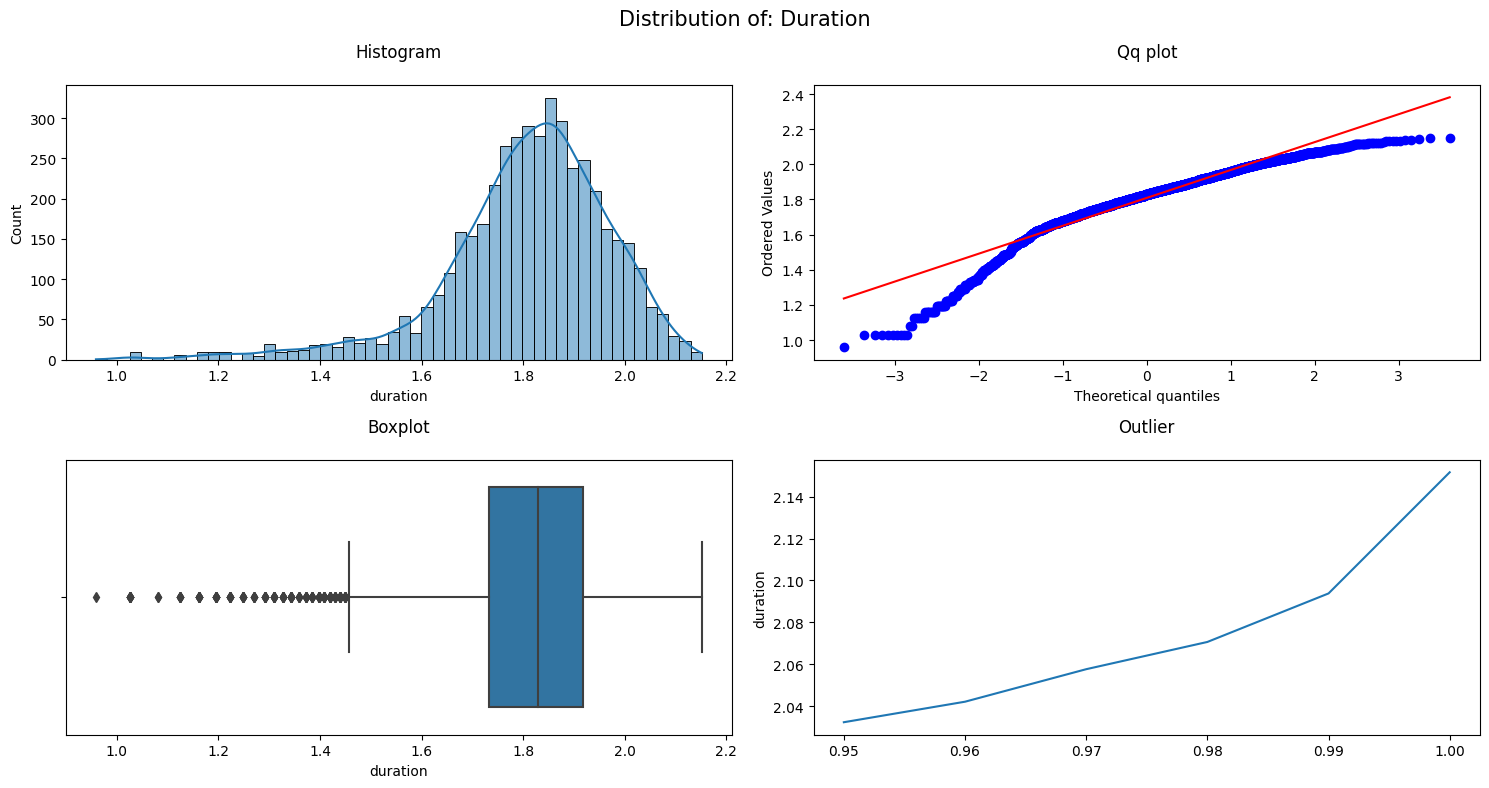

In [90]:
df_engineered['duration'] = np.log1p(df_engineered['duration'])
summary_numerical(df_engineered, 'duration', 0.95, 1, upload=0, engineered=1)

### Campaign

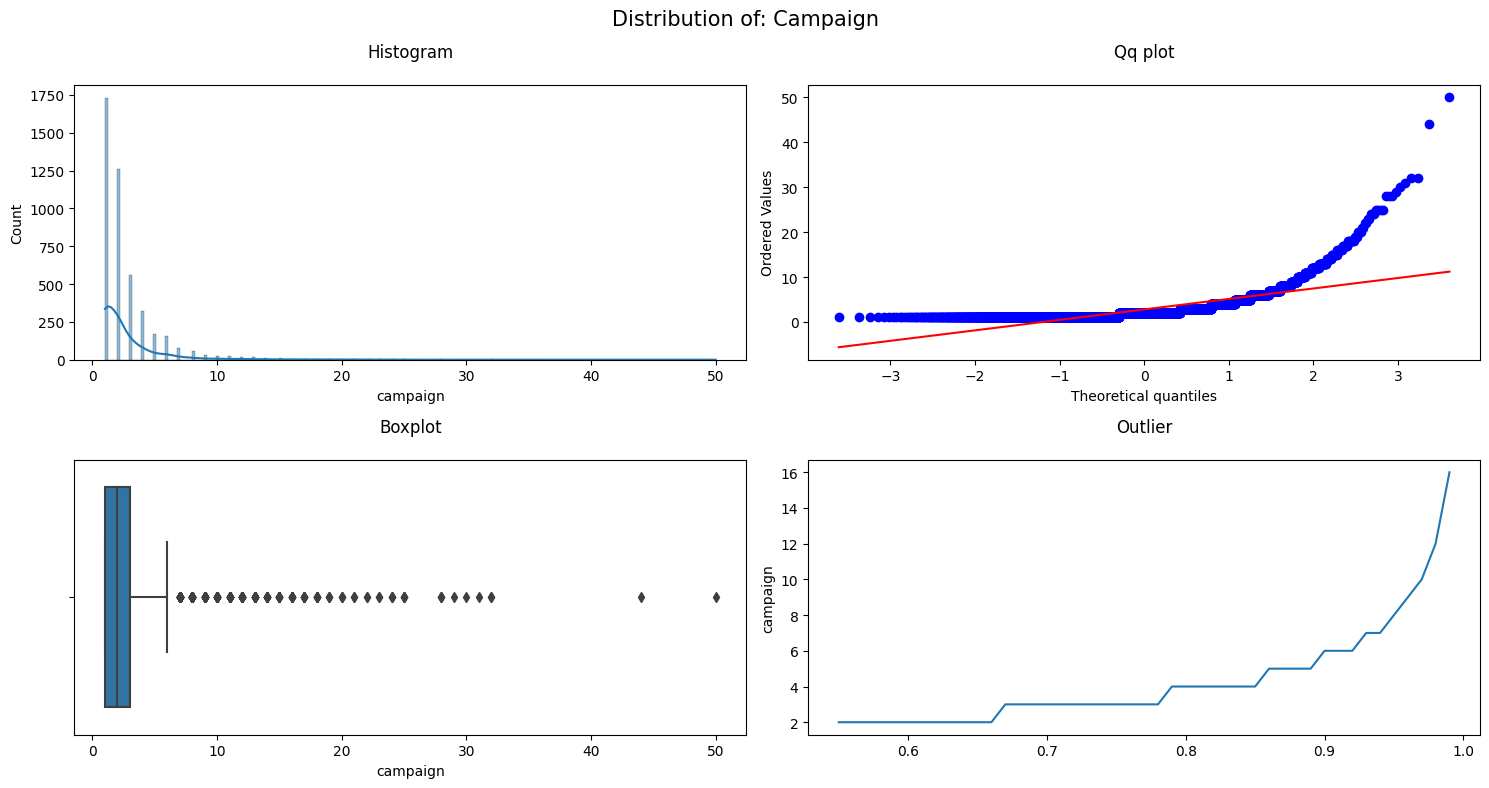

In [91]:
summary_numerical(df_engineered, 'campaign', 0.55, 1, 0)

In [92]:
numerical_df['campaign'].value_counts()

1     1734
2     1264
3      558
4      325
5      167
6      155
7       75
8       56
9       30
10      27
11      22
12      21
13      17
14      10
15       9
16       8
17       7
18       7
25       4
19       3
20       3
28       3
24       3
32       2
21       2
23       2
22       2
31       1
29       1
50       1
30       1
44       1
Name: campaign, dtype: int64

In [93]:
def define_campaign(x):
    if x == 1:
        return '1'
    elif x == 2:
        return '2'
    elif x in [3, 4]:
        return '3-4'
    elif x >= 5:
        return '5+'

df_engineered['campaign'] = df_engineered['campaign'].apply(define_campaign)

_, p_value, _, _ = cat_to_target(df_engineered, 'campaign')

In [94]:
p_value

2.2868299453696617e-05

### Pdays

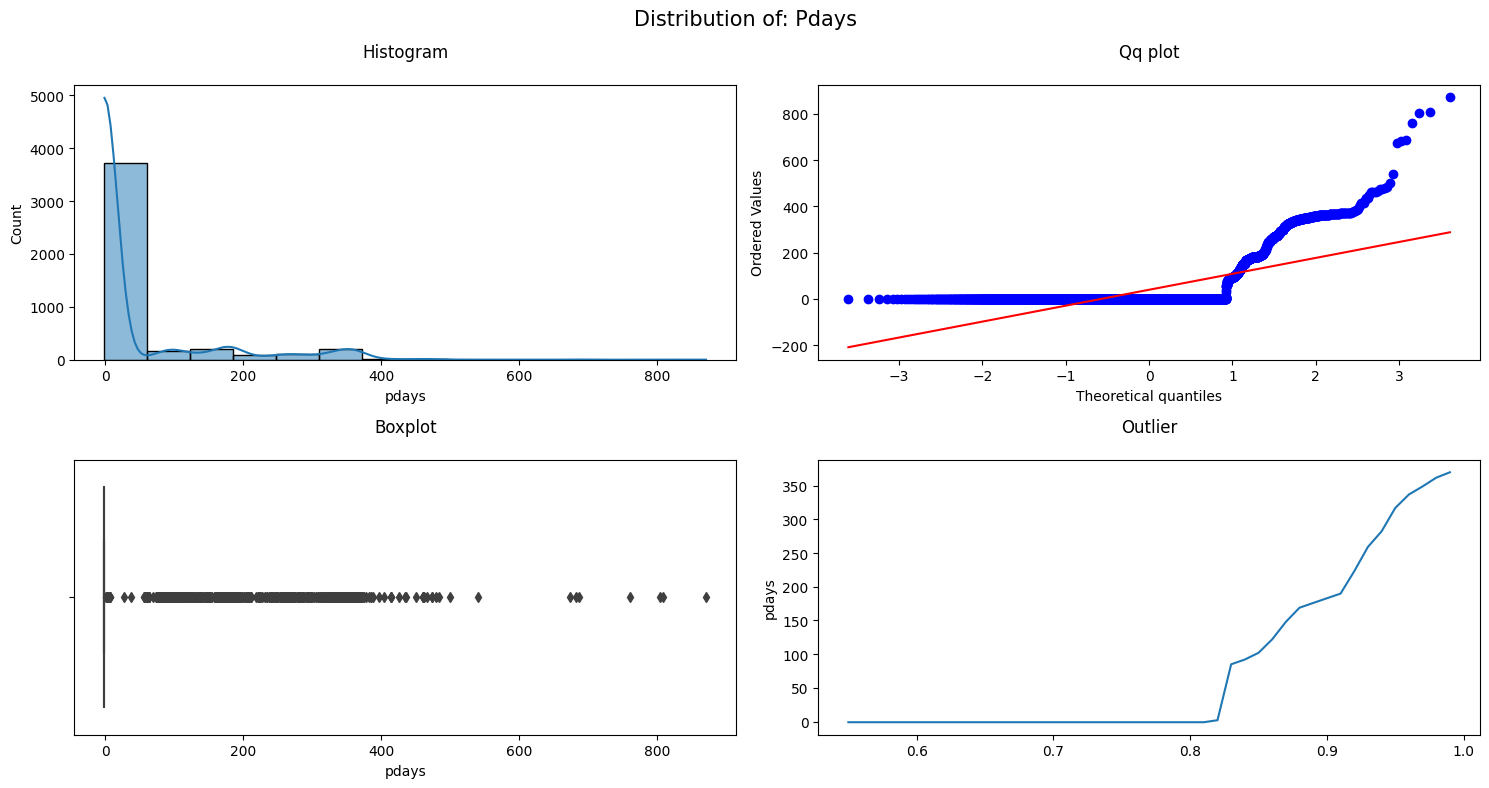

In [95]:
summary_numerical(df_engineered, 'pdays', 0.55, 1, 0)

In [96]:
df_engineered['pdays'].value_counts()

-1      3697
 182      23
 183      20
 363      12
 92       12
        ... 
 118       1
 386       1
 63        1
 81        1
 234       1
Name: pdays, Length: 292, dtype: int64

In [97]:
def define_pdays(x):
    if x == -1:
        return 'no'
    elif -1 < x <= 200:
        return '< 200'
    else:
        return '>= 200'

df_engineered['pdays'] = df_engineered['pdays'].apply(define_pdays)
_, p_value, _, _ = cat_to_target(df_engineered, 'pdays')

In [98]:
p_value

1.5425036569918175e-38

### Previous

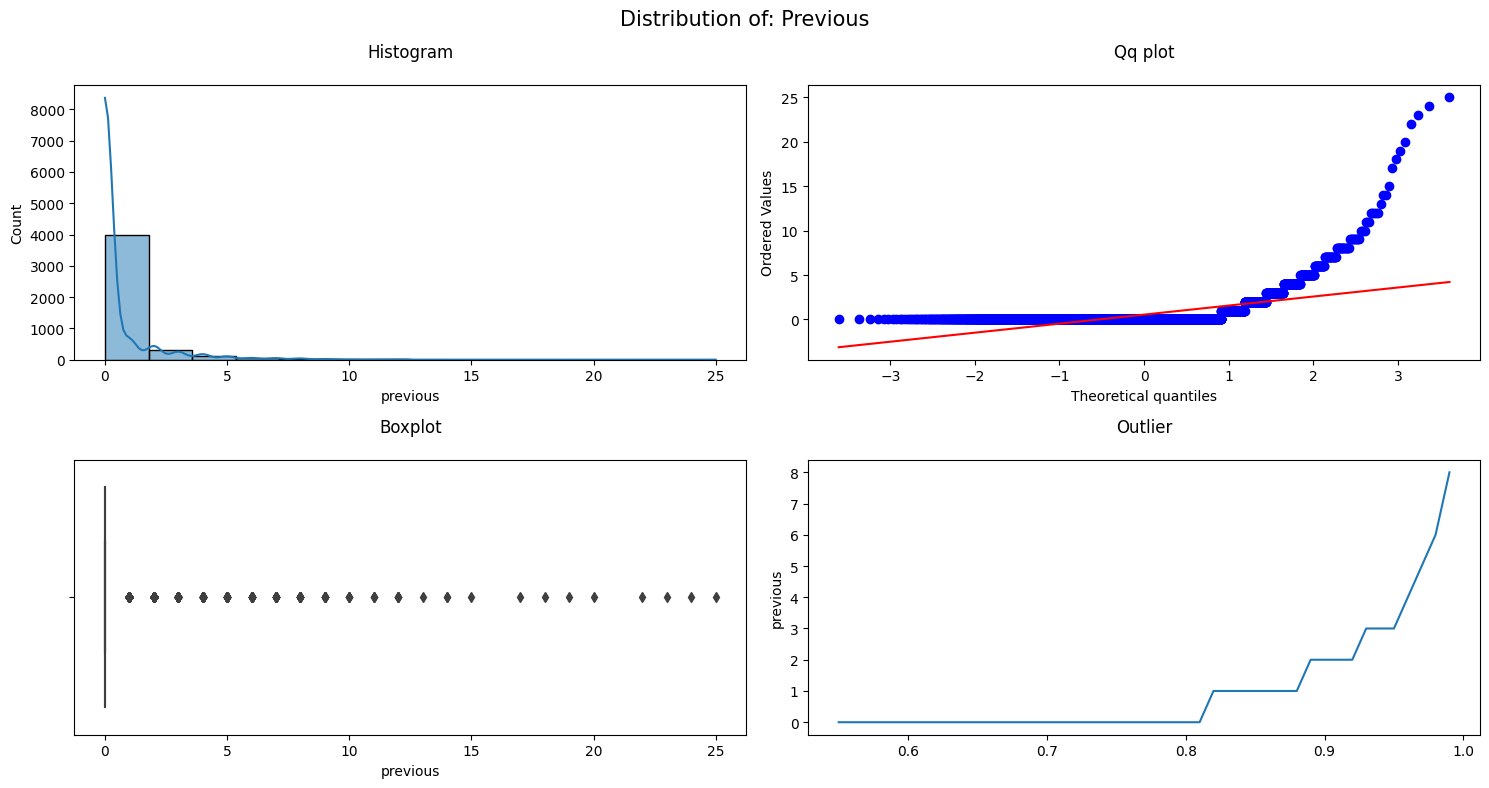

In [99]:
summary_numerical(df_engineered, 'previous', 0.55, 1, 0)

In [100]:
df_engineered['previous'].value_counts()

0     3697
1      286
2      193
3      113
4       78
5       47
6       25
7       22
8       18
9       10
12       5
10       4
11       3
14       2
24       1
22       1
23       1
17       1
18       1
15       1
13       1
19       1
20       1
25       1
Name: previous, dtype: int64

In [101]:
def define_previous(x):
    if x == 0:
        return '0'
    elif x in [1, 2, 3]:
        return '1-3'
    else:
        return '>3'

df_engineered['previous'] = df_engineered['previous'].apply(define_previous)

_, p_value, _, _ = cat_to_target(df_engineered, 'previous')

In [102]:
p_value

2.0358725433069983e-28

# Re-Train with fixed Parameters

#### Preparing

In [103]:
df_for_engineered = df_engineered.copy()
X_train_engineered, X_test_engineered, y_train_engineered, y_test_engineered = train_test_split(df_for_engineered.drop('y', axis=1), 
                                                    df_for_engineered['y'], 
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df_for_engineered['y'])

X_train_engineered.reset_index(drop=True, inplace=True)
X_test_engineered.reset_index(drop=True, inplace=True)

y_train_engineered_final = y_train_engineered.map({'no': 0, 'yes': 1}).reset_index(drop=True)
y_test_engineered_final = y_test_engineered.map({'no': 0, 'yes': 1}).reset_index(drop=True)

columns_cat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'campaign', 'pdays', 'previous', 'poutcome']

X_train_engineered_final = pd.get_dummies(
        X_train_engineered,
        columns=columns_cat,
        drop_first=True)

X_test_engineered_final = pd.get_dummies(
        X_test_engineered,
        columns=columns_cat,
        drop_first=True)

#### Fit the Models

In [104]:
engineered_models = {
    'Logistic Regregression': LogisticRegression(max_iter=5000,),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(**{'n_estimators': 600, 'subsample': 0.85, 'learning_rate': 0.001530897464421364, 'max_depth': 4})
}

In [105]:
engineered_results_train, trained_engineered_models = train_models(X_train_engineered_final, y_train_engineered_final, engineered_models)
engineered_results_test = test_models(X_test_engineered_final, y_test_engineered_final, trained_engineered_models)

In [106]:
engineered_results_train

accuracy    recall  f1 score  precision
Logistic Regregression  0.898061  0.236615  0.344836   0.650412
Random Forest           0.897507  0.236527  0.343318   0.641281
XGBoost                 0.897507  0.299354  0.399673   0.608605

In [107]:
engineered_results_test

accuracy    recall  f1 score  precision
Logistic Regregression  0.893688  0.194175  0.294118   0.606061
Random Forest           0.901440  0.262136  0.377622   0.675000
XGBoost                 0.901440  0.339806  0.440252   0.625000

In [ ]:
upload_csv(engineered_results_train, 'engineered_results_train', index=True)
upload_csv(engineered_results_test, 'engineered_results_test', index=True)

## Optuna Optimisation

In [108]:
import optuna
from optuna.samplers import TPESampler

In [109]:
from sklearn.model_selection import cross_val_score

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', low=300, high=1500, step=100)
    subsample = trial.suggest_float('subsample', low=0.75, high=0.9, step=0.05)
    learning_rate = trial.suggest_float('learning_rate', low=0.001, high=0.05, log=True)
    max_depth = trial.suggest_int('max_depth', low=3, high=7, step=1)

    xgb_clf = XGBClassifier(
        n_estimators=n_estimators,
        subsample=subsample,
        learning_rate=learning_rate,
        max_depth=max_depth
    )

    return cross_val_score(
        estimator=xgb_clf,
        X=X_train_engineered_final,
        y=y_train_engineered_final,
        scoring='precision'
        ).mean()

study = optuna.create_study(
    sampler=TPESampler(),
    direction='maximize'
)

study.optimize(objective, n_trials=100)

[I 2024-04-30 03:54:20,282] A new study created in memory with name: no-name-72f733f5-b402-4b5b-bd01-8b9d0a7a2cd7
[I 2024-04-30 03:54:29,132] Trial 0 finished with value: 0.6105203761755487 and parameters: {'n_estimators': 700, 'subsample': 0.85, 'learning_rate': 0.0409883616966606, 'max_depth': 5}. Best is trial 0 with value: 0.6105203761755487.
[I 2024-04-30 03:54:34,177] Trial 1 finished with value: 0.5951937509108839 and parameters: {'n_estimators': 600, 'subsample': 0.75, 'learning_rate': 0.0010280329016068399, 'max_depth': 3}. Best is trial 0 with value: 0.6105203761755487.
[I 2024-04-30 03:54:53,205] Trial 2 finished with value: 0.6110023953650277 and parameters: {'n_estimators': 1100, 'subsample': 0.85, 'learning_rate': 0.0017839238798664835, 'max_depth': 7}. Best is trial 2 with value: 0.6110023953650277.
[I 2024-04-30 03:55:19,821] Trial 3 finished with value: 0.612069368084945 and parameters: {'n_estimators': 1300, 'subsample': 0.8, 'learning_rate': 0.003557557969596891, 'ma

In [110]:
print("---Bayesian Optimization---")
print('Number of iterations: 100')
print(f"Best trial index: {study.best_trial.number}")
print(f"Best score: {study.best_trial.value}")
print(f"Best hyperparameters: {study.best_params}")

---Bayesian Optimization---
Number of iterations: 100
Best trial index: 62
Best score: 0.6740925039872409
Best hyperparameters: {'n_estimators': 600, 'subsample': 0.85, 'learning_rate': 0.00392612729746882, 'max_depth': 3}


In [111]:
xgb_clf = XGBClassifier(
        n_estimators=300,
        subsample=0.9,
        learning_rate=0.0024,
        max_depth=6
    )
xgb_clf.fit(X_train_engineered_final, y_train_engineered_final)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0024, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [112]:
scores = cross_val_score(xgb_clf, X_train_engineered_final, y_train_engineered_final, cv=s_fold, scoring='precision')
print(scores.mean())

0.5954011323576541


In [113]:
preds = xgb_clf.predict(X_train_engineered_final)
1 - (preds.shape[0] - (preds == y_train_engineered_final.to_numpy()).sum()) / preds.shape[0]

0.9373961218836565

In [114]:
preds = xgb_clf.predict(X_test_engineered_final)
1 - (preds.shape[0] - (preds == y_test_engineered_final.to_numpy()).sum()) / preds.shape[0]

0.9058693244739756